In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
#         self.salfeh = abund[0,0]+np.log10(0.638*(10**(abund[1,0]))+0.362) # Salaris Corrected [Fe/H]
#         self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.362/(0.638*(10**(abund[1,0]))+0.362))*abund[1,1])**2)
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
#         self.salfeh_err =  # Salaris Corrected [Fe/H] Error
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
#         self.wang = {'abpak':/0.078,'arpak':/0.078,'ajak':/0.078,'ahak':/0.078,'akak':1.0}
    
#     def salariscorrectedfeh(self,abund):
#         '''
#         Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
#         Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
#         # hydrogen_wgt = 1.008 #IUPAC
#         # atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
#         # asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
#         # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
#         # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
#         # b = 1-a # b = 0.21036372868803943
        
#         Inputs:
#         ------
#             feh: metallcity of a star
#             _alpha: array of abundances np.array([O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
#         Output:
#         ------
#             salfeh: Salaris corrected metallicity
#         '''
        
#         # Set things up
#         nsamples = 1000
#         asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
#         feh = abund[0,0]
#         feh_err = abund[0,1]
#         _alpha = abund[1:,0]
#         _alpha_err = abund[1:,1]
        
#         salfehdist = 999999.0*np.ones(nsamples)
        
#         for i in range(nsamples):
        
#             # Assign solar value to stars if abundance is bad
#             for j in range(len(_alpha)):
#                 if _alpha[j] < -100. or _alpha[j] > 10. or np.isfinite(_alpha[j])==False:
#                     _alpha[j] = 0.0
#                 if _alpha_err[j] < -100. or _alpha_err[j] > 10. or np.isfinite(_alpha_err[j])==False:
#                     _alpha_err[j] = 0.0

#             if np.isfinite(feh) == False:
#                 feh = 0.0
#                 feh_err = 0.0

#             # Create distribution for the different abundances
#             feh_new = np.random.normal(feh,feh_err)
#             _alpha_new = 999999.0*np.ones(len(_alpha))
#             for k in range(len(_alpha)):
#                 _alpha_new[k] = np.random.normal(_alpha[k],_alpha_err[k])
            
#             # Calculate enhancement factor and corrected metallicity
#             fac_acn = sum(10**(asplund+_alpha_new))/sum(10**asplund)
#             salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
            
#             salfehdist[i] = salfeh
        
#         # Calculate the value and error from the distribution
#         calc_salfeh = np.nanmedian(salfehdist)
#         calc_salfeh_err = self.mad(salfehdist)
        
#         return calc_salfeh, calc_salfeh_err 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        self.age = age
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def get_mass(self,verbose=False):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        massdist = 999999.0*np.ones(nsamples)

        if self.age == 999999.0:
            return np.array([999999.0,999999.0])
        
        lgage = np.log10(self.age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]
                
                ### Use spline to find mass for a point in lgteffdist
                mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
                massdist[j] = mass_spl(np.log10(lgteffdist[j]))

                if verbose:
                    print('mass',mass_spl(np.log10(lgteffdist[j])))

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('mass: ',999999.0)   
                    massdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('mass: ',999999.0)
                    massdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9

                mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
                mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

                massdist[j] = age_spl_interp(self.age)
            
        med_calc_mass = np.nanmedian(massdist)
        mad_calc_mass = self.mad(massdist)
        
        if np.isfinite(med_calc_mass)==False:
            med_calc_mass = 999999.0
        if np.isfinite(mad_calc_mass)==False:
            mad_calc_mass = 999999.0
        
        self.mass = med_calc_mass
        self.mass_err = mad_calc_mass
        
        mass_arr = np.array([med_calc_mass,mad_calc_mass])
        return mass_arr
    
#     def test(self,x=3.0):
#         print('Hello World!')
    
    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Gaia Errors

In [4]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

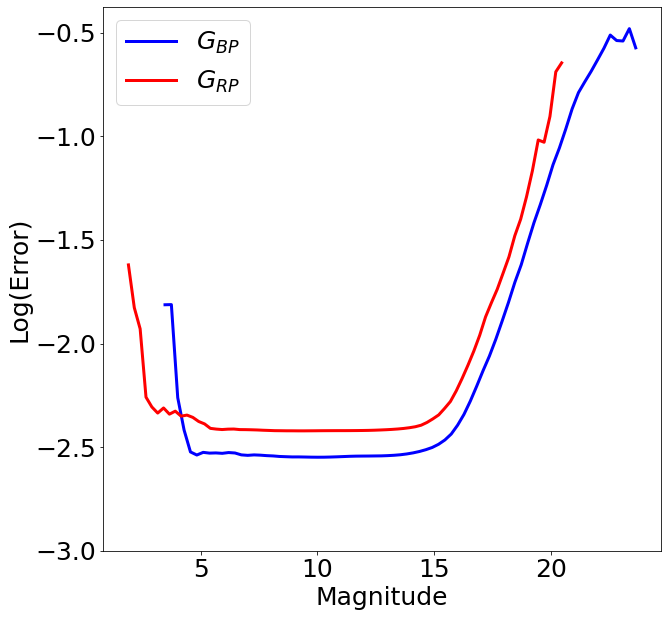

In [5]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

# OCCAM

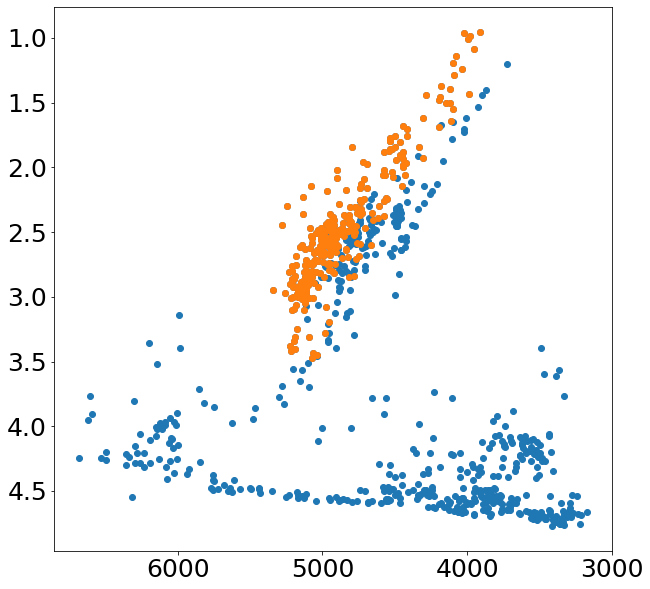

In [72]:
from astropy.io import ascii

### read in DR17 
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

### Read in membership list and do OCCAM selection 
ocmember = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/occam_member-DR16.fits.gz') 
ocmember = ocmember[np.where((ocmember['PM_PROB']>0.01)&(ocmember['RV_PROB']>0.01)&(ocmember['FEH_PROB']>0.01))]

### xmatch dr17 allstar file with OCCAM membership list 
_, dr17_occam, occam_dr17 = np.intersect1d(dr17['APOGEE_ID'],ocmember['APOGEE_ID'],return_indices=True)
occamdr17 = dr17[dr17_occam]
ocmemdr17 = ocmember[occam_dr17]

### Table from Donor et al. 2020 
octab1 = ascii.read('/Users/joshuapovick/Desktop/Research/dats/OCCAM_IV_tab1.dat',
                    names=['Name','Qual','GLON','GLAT','Radius','Age','Rgc','pmRA','e_pmRA','pmDE','e_pmDE','HRV',
                           'e_HRV','FEH','e_FEH','N'])

### Find RGB stars
# rgbcut = np.where((occamdr17['LOGG']<=3.5)&(occamdr17['TEFF']<=5500)&(occamdr17['TEFF']>=3500))
rgbcut = np.where((occamdr17['LOGG']<=3.5)&(occamdr17['TEFF']<=5500)&(occamdr17['TEFF']>=3500)&
                  (occamdr17['FE_H']<0.0)&(occamdr17['FE_H']>-10.0))
plt.figure(figsize=[10,10])
plt.scatter(occamdr17['TEFF'],occamdr17['LOGG'])
plt.scatter(occamdr17['TEFF'][rgbcut],occamdr17['LOGG'][rgbcut])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

occamdr17 = occamdr17[rgbcut]
ocmemdr17 = ocmemdr17[rgbcut]

### Gaia BP and RP ERRs
bperr = 10**bperrfunc(occamdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(occamdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

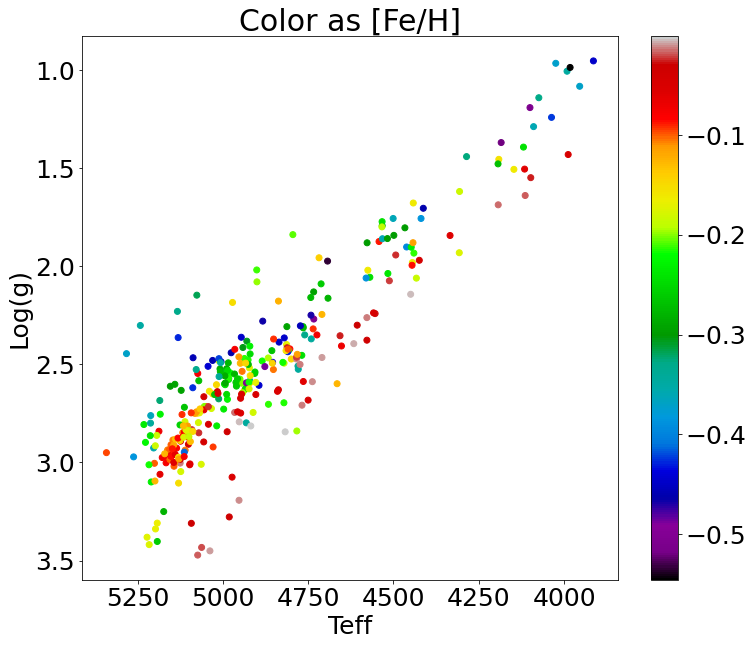

In [74]:
# rgbcut = np.where((occamdr17['LOGG']<=3.5)&(occamdr17['TEFF']<=5500)&(occamdr17['TEFF']>=3500))
plt.figure(figsize=[12,10])
plt.scatter(occamdr17['TEFF'][rgbcut],occamdr17['LOGG'][rgbcut],c=occamdr17['FE_H'][rgbcut],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.savefig(r'../plots/occamHR.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [75]:
len(np.squeeze(rgbcut))

319

In [76]:
from tqdm import tqdm_notebook

occam_ak = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occam_ak_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occam_age = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occam_age_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occam_mass = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occam_mass_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))

apoafe = occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']
apoafe_err = np.sqrt(occamdr17['ALPHA_M']**2+occamdr17['M_H']**2-occamdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(occamdr17)))):
    te = np.array([occamdr17['TEFF'][i],occamdr17['TEFF_ERR'][i]])
    ab = np.array([[occamdr17['M_H'][i],occamdr17['ALPHA_M'][i]],
                   [apoafe[i],apoafe[i]]]).T
    op = np.array([[occamdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    occamdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    occamdr17['J'][i],occamdr17['H'][i],
                    occamdr17['K'][i]],
                   [bperr[i],rperr[i],occamdr17['J_ERR'][i],
                    occamdr17['H_ERR'][i],occamdr17['K_ERR'][i]]]).T
    di = (1/occamdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    ak_val = CalcAge.get_ak(age = 12.0)
    occam_ak[i] = ak_val[0] #CalcAge.get_ak(age = 6.0)[0]
    occam_ak_err[i] = ak_val[1] #CalcAge.get_ak(age = 6.0)[1]
    
    age_val = CalcAge.get_age()
    occam_age[i] = age_val[0] #CalcAge.get_age()[0]
    occam_age_err[i] = age_val[1] #CalcAge.get_age()[1]
    
    mass_val = CalcAge.get_mass()
    occam_mass[i] = mass_val[0]
    occam_mass_err[i] = mass_val[1]

<ipython-input-76-7f994c3733ac>:11: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(occamdr17['ALPHA_M']**2+occamdr17['M_H']**2-occamdr17['FE_H']**2)
<ipython-input-76-7f994c3733ac>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(occamdr17)))):


<ipython-input-1-3a39e8c9f4df>:46: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


In [77]:
### save ages to fits file
from astropy.table import Table, Column

cname = Column(occamdr17['APOGEE_ID'], name='NAME')
cage = Column(occam_age,name='AGE')
cage_err = Column(occam_age_err,name='AGE_ERR')
cak = Column(occam_ak,name='AK')
cak_err = Column(occam_ak_err,name='AK_ERR')
cmass = Column(occam_mass,name='MASS')
cmass_err = Column(occam_mass_err,name='MASS_ERR')

agetable = Table([cname,cage,cage_err,cak,cak_err,cmass,cmass_err])
agetable.write('aetas_occam_results.fits', format='fits', overwrite=True)

In [78]:
### Import saved ages
agetab = Table(fits.getdata('aetas_occam_results.fits'))

In [79]:
calc_age = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_age_spread = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_feh = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_salfeh = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_alp = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_ak = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_n = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calc_dist = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
oc_glon = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
oc_glat = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))

for i in range(len(np.unique(ocmemdr17['CLUSTER']))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[i])
    calc_age[i] = np.nanmedian(agetab['AGE'][clus])
    calc_age_spread[i] = mad(agetab['AGE'][clus])
    calc_ak[i] = np.nanmedian(agetab['AK'][clus])
    calc_feh[i] = np.nanmedian(occamdr17['FE_H'][clus])
    calc_salfeh[i] = (np.nanmedian(occamdr17['FE_H'][clus])+np.log10(0.655*10**(np.nanmedian((occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H'])[clus])) + 0.345))
    calc_alp[i] = np.nanmedian((occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H'])[clus])
    calc_n[i] = np.size(np.squeeze(clus))
    calc_dist[i] = 5*np.log10(np.nanmedian((1/occamdr17['GAIAEDR3_PARALLAX'][clus])*1000))-5.
    
    oc_glon[i] = np.nanmedian(occamdr17['GLON'][clus])
    oc_glat[i] = np.nanmedian(occamdr17['GLAT'][clus])

In [138]:
np.unique(ocmemdr17['CLUSTER'])

chararray(['ASCC 116', 'Basel 11b', 'Berkeley 17', 'Berkeley 19',
           'Berkeley 20', 'Berkeley 29', 'Berkeley 31', 'Berkeley 33',
           'Berkeley 43', 'Berkeley 44', 'Berkeley 53', 'Berkeley 66',
           'Berkeley 71', 'Berkeley 9', 'Berkeley 98', 'Collinder 220',
           'Collinder 92', 'Czernik 20', 'Czernik 21', 'Czernik 23',
           'Czernik 30', 'Czernik 7', 'Dol Dzim 4', 'FSR 0304',
           'FSR 0394', 'FSR 0494', 'FSR 0496', 'FSR 0542', 'FSR 0546',
           'FSR 0656', 'FSR 0667', 'FSR 0687', 'FSR 0716', 'FSR 0823',
           'FSR 0940', 'FSR 0942', 'FSR 1113', 'Haffner 4', 'IC 1369',
           'IC 166', 'King 2', 'King 5', 'King 7', 'King 8', 'Koposov 62',
           'Melotte 71', 'NGC 1193', 'NGC 1245', 'NGC 136', 'NGC 1664',
           'NGC 1798', 'NGC 1802', 'NGC 1857', 'NGC 1907', 'NGC 1912',
           'NGC 2158', 'NGC 2202', 'NGC 2204', 'NGC 2232', 'NGC 2240',
           'NGC 2243', 'NGC 2304', 'NGC 2311', 'NGC 2318', 'NGC 2324',
           'NG

In [152]:
ngc1245 = np.where(ocmemdr17['CLUSTER']=='NGC 1245')
ngc1245
print(occamdr17['FE_H'][ngc1245])
print(apoafe[ngc1245])
print(occamdr17['FE_H'][ngc1245]+np.log10(0.655*10**apoafe[ngc1245]+0.345))
ngc1245salfeh = occamdr17['FE_H'][ngc1245]+np.log10(0.655*10**apoafe[ngc1245]+0.345)

[-0.052518 -0.089764 -0.16264  -0.10544  -0.10112  -0.08165  -0.10071
 -0.080995 -0.1047   -0.09195  -0.078485 -0.10017  -0.11657  -0.071792
 -0.061607 -0.12439  -0.040401 -0.089478 -0.057439 -0.10376  -0.084316
 -0.063896 -0.1315   -0.087851 -0.082955]
[-0.004439   -0.01085301 -0.01152299 -0.02295399 -0.017722   -0.028782
 -0.006901    0.00411601 -0.016075   -0.015164   -0.003311   -0.008661
 -0.011709   -0.012071    0.005007   -0.023554   -0.008372   -0.035289
 -0.01436199 -0.029667   -0.03109799  0.000102   -0.01963601 -0.02350099
  0.007925  ]
[-0.05542043 -0.096842   -0.17015295 -0.12033707 -0.11264589 -0.10028527
 -0.10521774 -0.07829461 -0.11516168 -0.10182239 -0.08065088 -0.10582343
 -0.12420364 -0.07966048 -0.05832092 -0.13967274 -0.04586638 -0.11226564
 -0.06679225 -0.12296135 -0.10443178 -0.06382922 -0.14426085 -0.10309969
 -0.07774785]


In [166]:
print('NGC 1245')
for i in ngc1245salfeh:
    print('Salfeh:{:.3f}; Closest:{:.3f}; Diff:{:.4f}'.format(i,closest(massive['MH'],i),
                                                              i-closest(massive['MH'],i)))
    
print(np.median(occamdr17['FE_H'][ngc1245]))
print(np.median(apoafe[ngc1245]))
print(np.median(occamdr17['FE_H'][ngc1245])+np.log10(0.655*10**(np.median(apoafe[ngc1245]))+0.345))
print(np.median(ngc1245salfeh))

NGC 1245
Salfeh:-0.055; Closest:-0.060; Diff:0.0046
Salfeh:-0.097; Closest:-0.100; Diff:0.0032
Salfeh:-0.170; Closest:-0.170; Diff:-0.0002
Salfeh:-0.120; Closest:-0.120; Diff:-0.0003
Salfeh:-0.113; Closest:-0.110; Diff:-0.0026
Salfeh:-0.100; Closest:-0.100; Diff:-0.0003
Salfeh:-0.105; Closest:-0.110; Diff:0.0048
Salfeh:-0.078; Closest:-0.080; Diff:0.0017
Salfeh:-0.115; Closest:-0.120; Diff:0.0048
Salfeh:-0.102; Closest:-0.100; Diff:-0.0018
Salfeh:-0.081; Closest:-0.080; Diff:-0.0007
Salfeh:-0.106; Closest:-0.110; Diff:0.0042
Salfeh:-0.124; Closest:-0.120; Diff:-0.0042
Salfeh:-0.080; Closest:-0.080; Diff:0.0003
Salfeh:-0.058; Closest:-0.060; Diff:0.0017
Salfeh:-0.140; Closest:-0.140; Diff:0.0003
Salfeh:-0.046; Closest:-0.050; Diff:0.0041
Salfeh:-0.112; Closest:-0.110; Diff:-0.0023
Salfeh:-0.067; Closest:-0.070; Diff:0.0032
Salfeh:-0.123; Closest:-0.120; Diff:-0.0030
Salfeh:-0.104; Closest:-0.100; Diff:-0.0044
Salfeh:-0.064; Closest:-0.060; Diff:-0.0038
Salfeh:-0.144; Closest:-0.140; Dif

In [170]:
print(np.round(agetab['AGE'][ngc1245],3))
print(np.nanmedian(np.round(agetab['AGE'][ngc1245],3)))

[0.945 0.9   0.946 0.524 1.932 0.85  2.2   0.7   0.537 0.474 0.784 2.25
 0.524 0.953 0.996 2.    0.524 2.043 1.023 0.542 2.363 1.006 0.499 0.85
 0.716]
0.9


In [171]:
(1.06-0.9)/1.06

0.15094339622641512

In [174]:
(1.06-0.9)

0.16000000000000003

In [177]:
10**closest(massive['logAge'],np.log10(1.06*10**9))/10**9

1.0500016946500323

In [178]:
10**closest(massive['logAge'],np.log10(0.9*10**9))/10**9

0.8999947996371984

In [182]:
10**closest(massive['logAge'],np.log10(1.06*10**9))/10**9-10**closest(massive['logAge'],np.log10(0.9*10**9))/10**9

0.15000689501283393

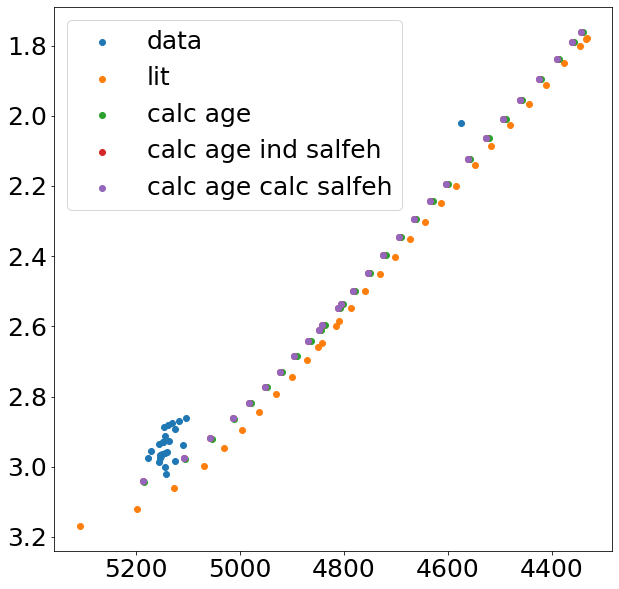

In [188]:
a106f008 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(1.06*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.08)))

a090f009 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(0.9*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.09)))

a090f0097 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(0.9*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.097)))

a090f0103 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(0.9*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.103)))

plt.figure(figsize=[10,10])
plt.scatter(occamdr17['TEFF'][ngc1245],occamdr17['LOGG'][ngc1245],label='data')
plt.scatter(10**massive['logTe'][a106f008],massive['logg'][a106f008],label='lit')
plt.scatter(10**massive['logTe'][a090f009],massive['logg'][a090f009],label='calc age')
plt.scatter(10**massive['logTe'][a090f0097],massive['logg'][a090f0097],label='calc age ind salfeh')
plt.scatter(10**massive['logTe'][a090f0103],massive['logg'][a090f0103],label='calc age calc salfeh')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

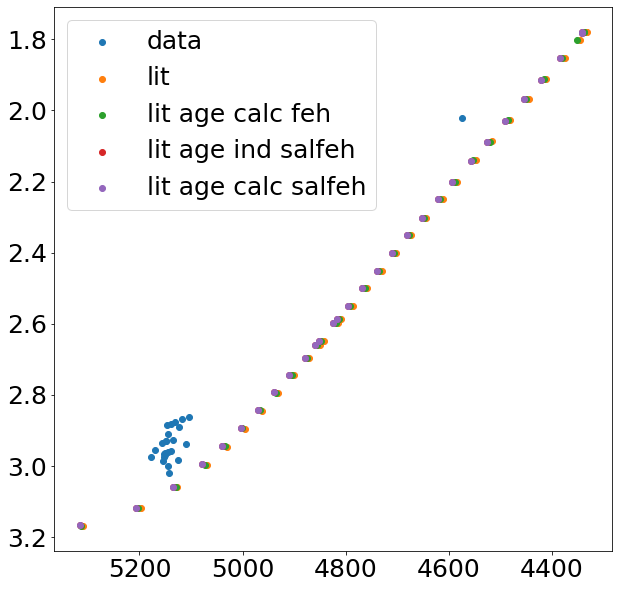

In [189]:
a106f009 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(1.06*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.09)))

a106f0097 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(1.06*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.097)))

a106f0103 = np.where((massive['logAge']==closest(massive['logAge'],np.log10(1.06*10**9)))&
                    (massive['MH']==closest(massive['MH'],-0.103)))

plt.figure(figsize=[10,10])
plt.scatter(occamdr17['TEFF'][ngc1245],occamdr17['LOGG'][ngc1245],label='data')
plt.scatter(10**massive['logTe'][a106f008],massive['logg'][a106f008],label='lit')
plt.scatter(10**massive['logTe'][a106f009],massive['logg'][a106f009],label='lit age calc feh')
plt.scatter(10**massive['logTe'][a106f0097],massive['logg'][a106f0097],label='lit age ind salfeh')
plt.scatter(10**massive['logTe'][a106f0103],massive['logg'][a106f0103],label='lit age calc salfeh')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [173]:
(-0.08-np.median(occamdr17['FE_H'][ngc1245]))/0.08

0.11847501248121259

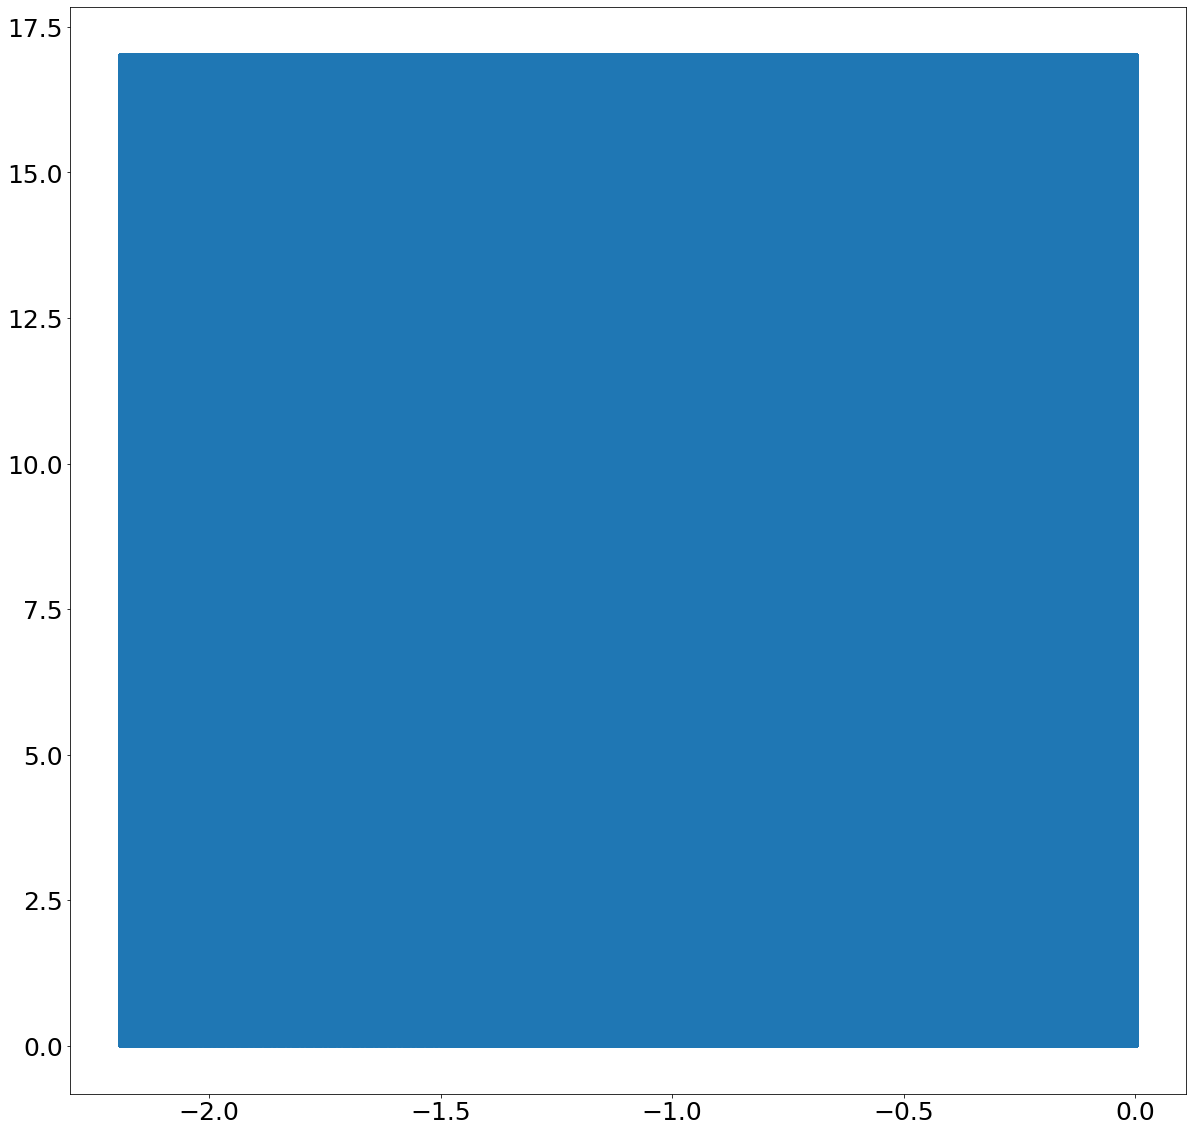

In [163]:
plt.figure(figsize=[20,20])
plt.scatter(massive['MH'],10**massive['logAge']/10**9)

In [80]:
_, tab_ind, oc_ind = np.intersect1d(octab1['Name'],np.unique(ocmemdr17['CLUSTER']).replace(" ", "_"),
                                    return_indices=True)

In [169]:
octab1[tab_ind][np.where(octab1[tab_ind]['Name']=='NGC_1245')]

<Table length=1>
  Name    Qual   GLON     GLAT   Radius ...  e_HRV    FEH    e_FEH    N  
 str13   int64 float64  float64 float64 ... float64 float64 float64 int64
-------- ----- -------- ------- ------- ... ------- ------- ------- -----
NGC_1245     2 146.6533 -8.9081    11.4 ...     0.8   -0.08    0.02    24

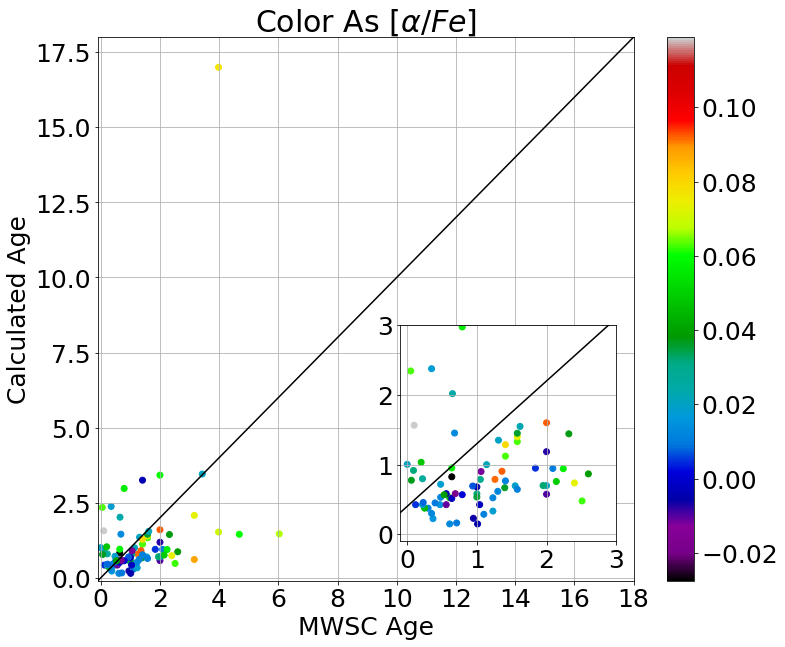

In [110]:
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_alp,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As [$\alpha/Fe$]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_alp,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/occam_age_age_alpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

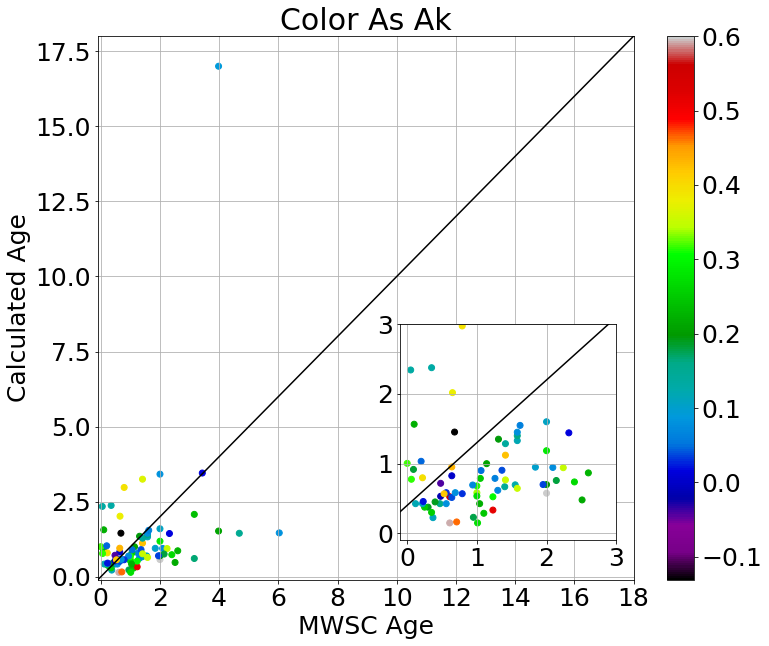

In [111]:
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_ak,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As Ak')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_ak,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/occam_age_age_ak.pdf',dpi=300,bbox_inches='tight')
plt.show()

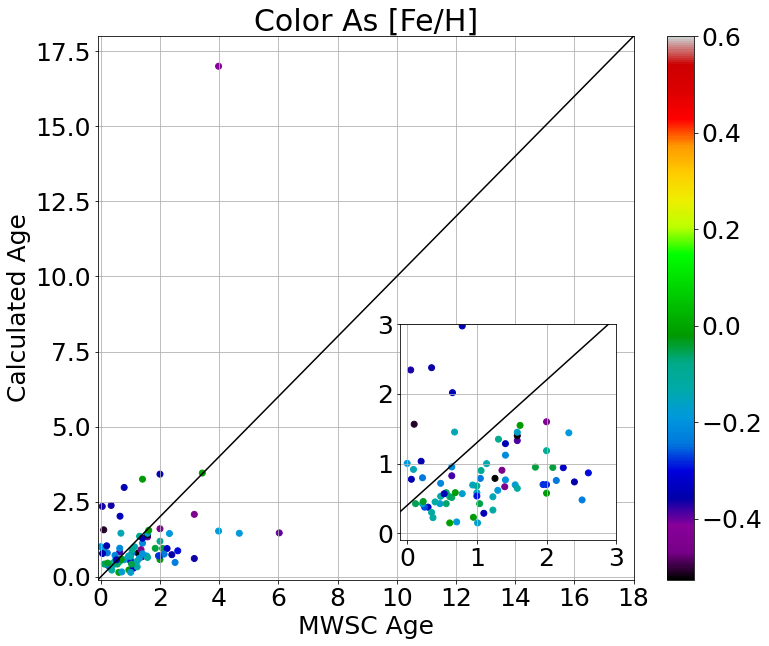

In [112]:
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_feh,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As [Fe/H]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_feh,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/occam_age_age_feh.pdf',dpi=300,bbox_inches='tight')
plt.show()

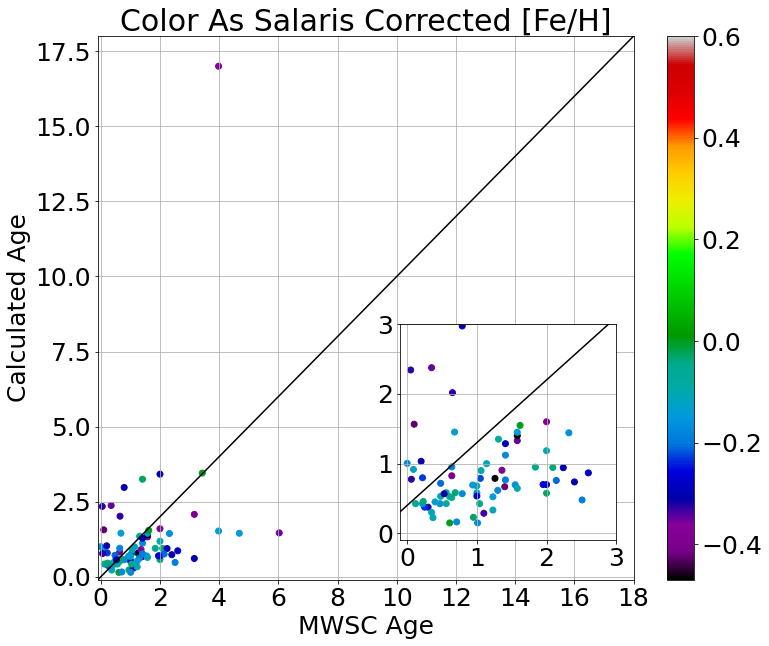

In [113]:
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_salfeh,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As Salaris Corrected [Fe/H]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_salfeh,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/occam_age_age_corrfeh.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [114]:
# plt.figure(figsize=[12,10])
# plt.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_alp,cmap='nipy_spectral')
# plt.colorbar()
# plt.plot([-0.5,18],[-0.5,18],c='k')

# plt.title(r'Color As [$\alpha/Fe$]')
# plt.xlabel(r'MWSC Age')
# plt.ylabel(r'Calculated Age')

# plt.xlim(-0.1,18.)
# plt.ylim(-0.1,18.)
# plt.xticks(np.arange(0,20)[::2])
# plt.grid()

# sub_axes = plt.axes([.45, .18, .3, .3])
# sub_axes.set_aspect('equal')
# sub_axes.scatter(octab1[tab_ind]['Age'],calc_age,c=calc_alp,cmap='nipy_spectral') 
# sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
# sub_axes.grid()

# sub_axes.set_xticks(range(4))
# sub_axes.set_xlim(-0.1,3.0)
# sub_axes.set_ylim(-0.1,3.0)
# # plt.savefig('../plots/oc_age_age_alpha.pdf',dpi=300,bbox_inches='tight')
# plt.show()

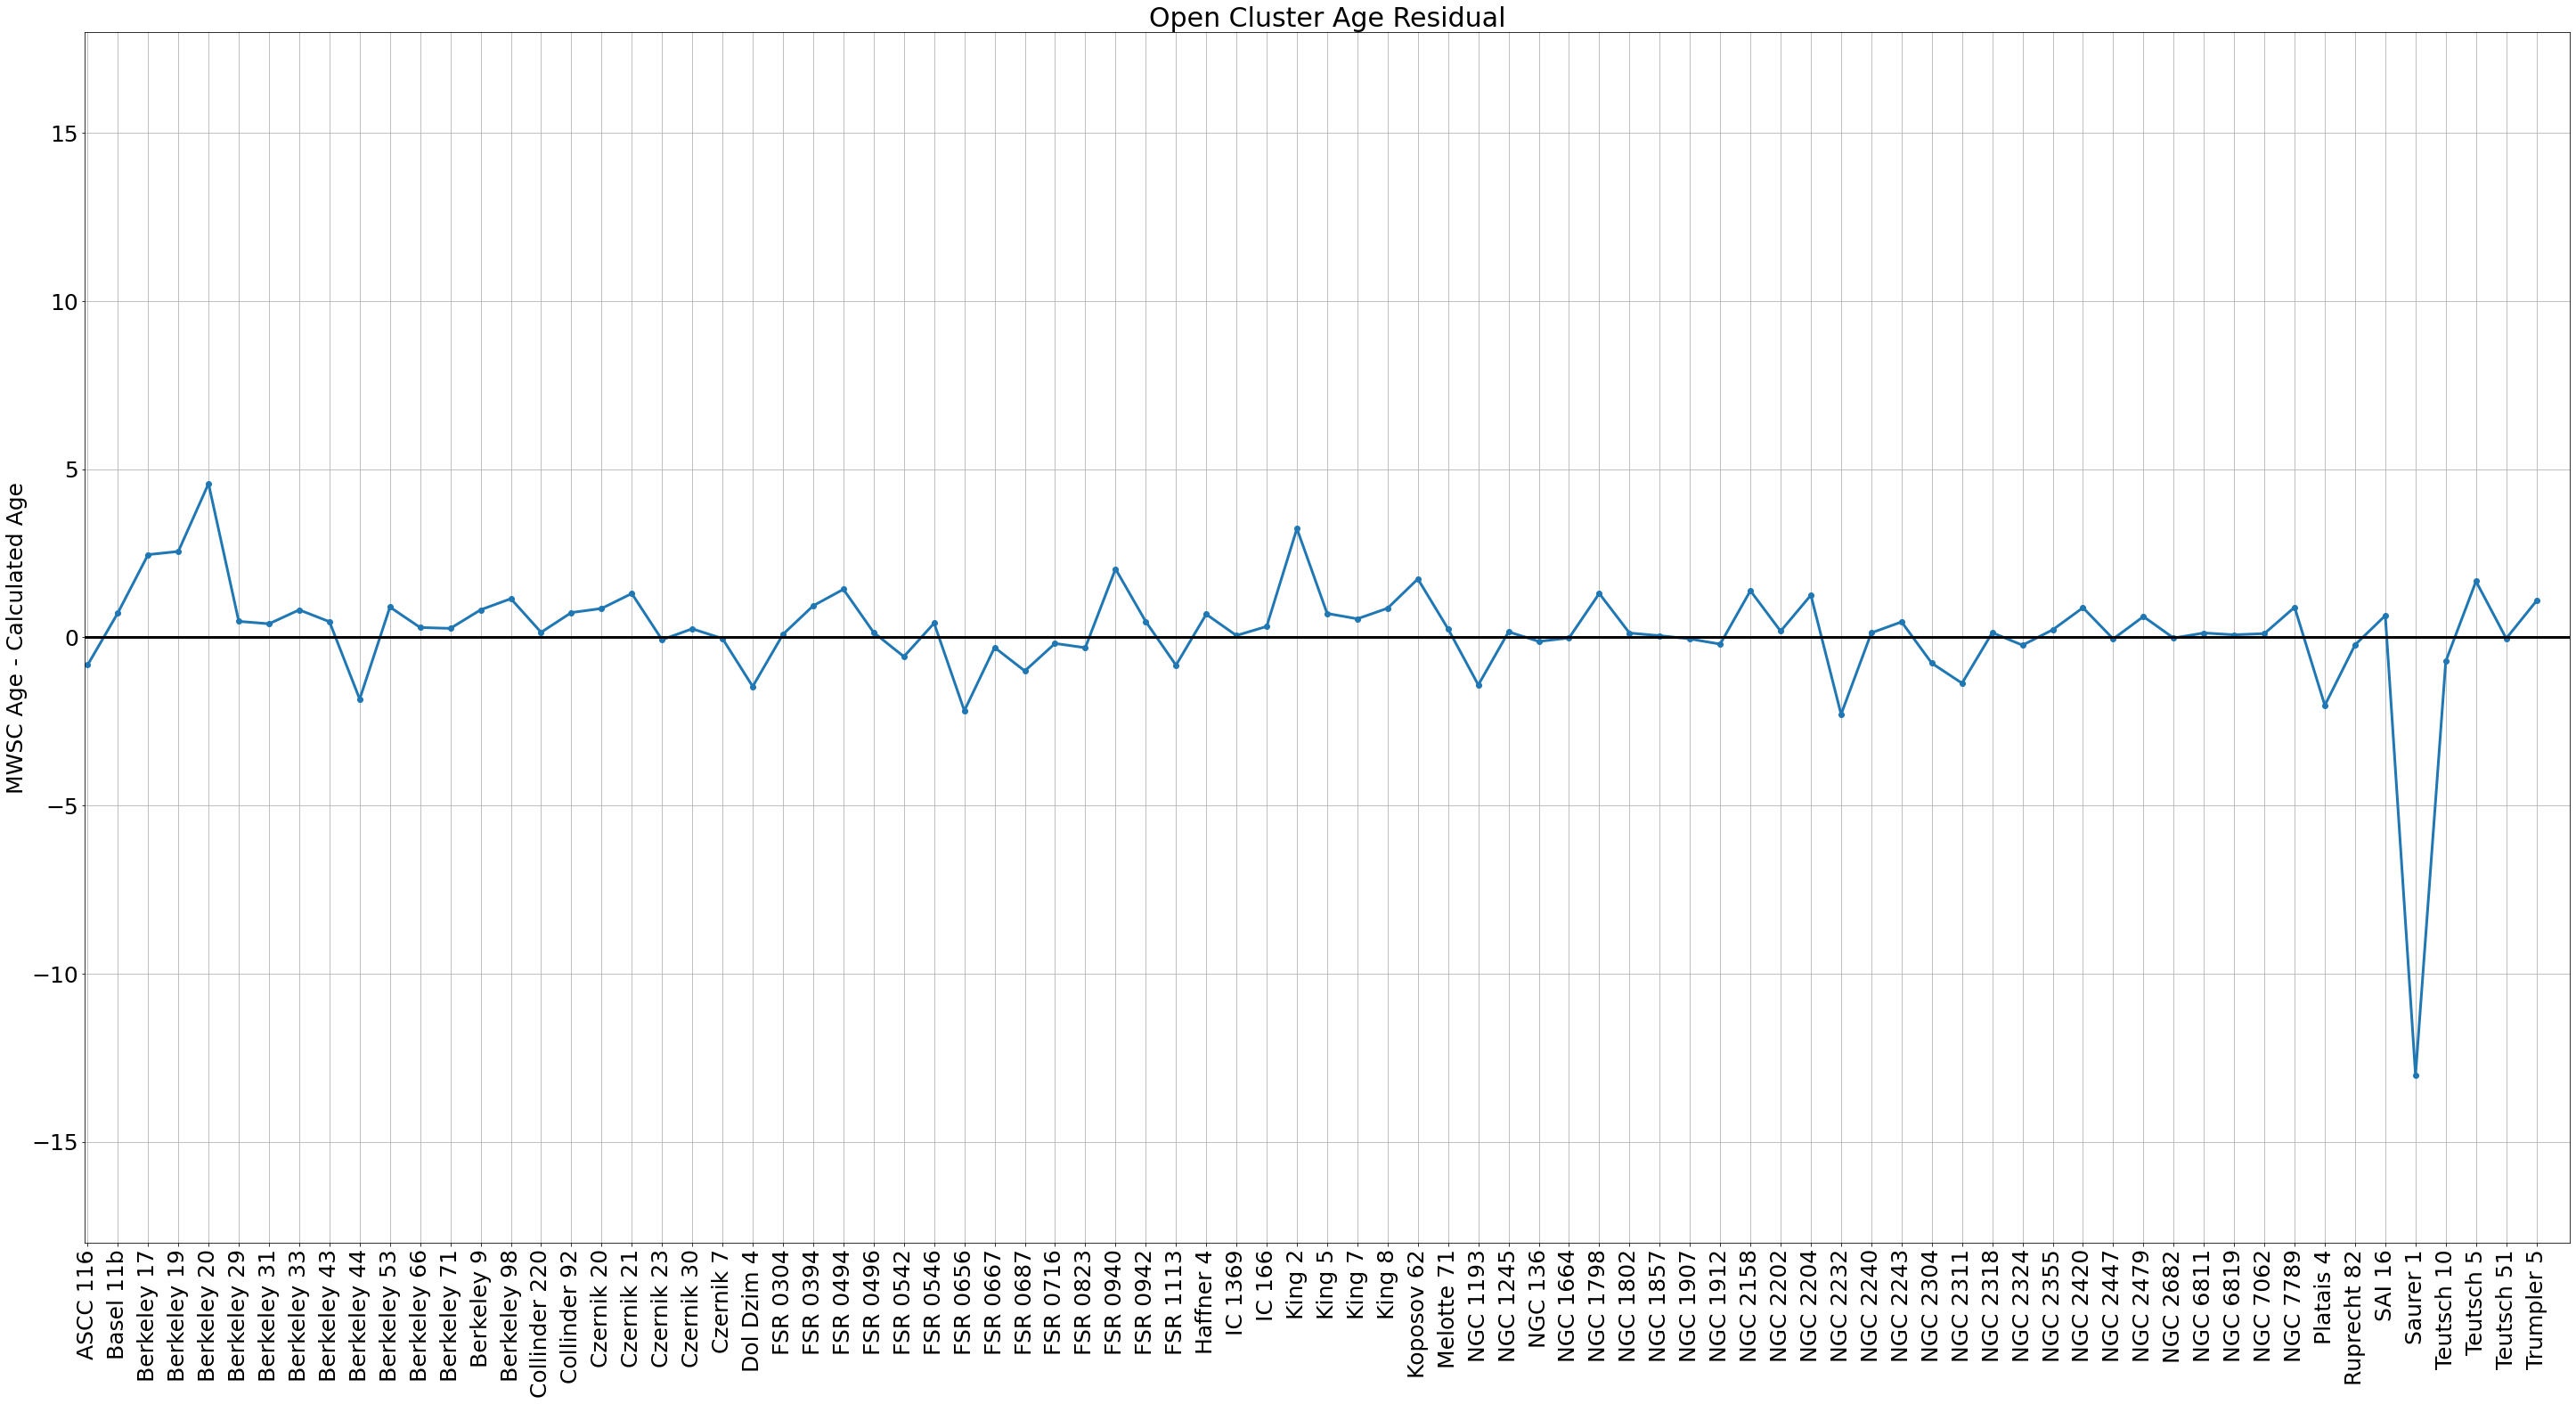

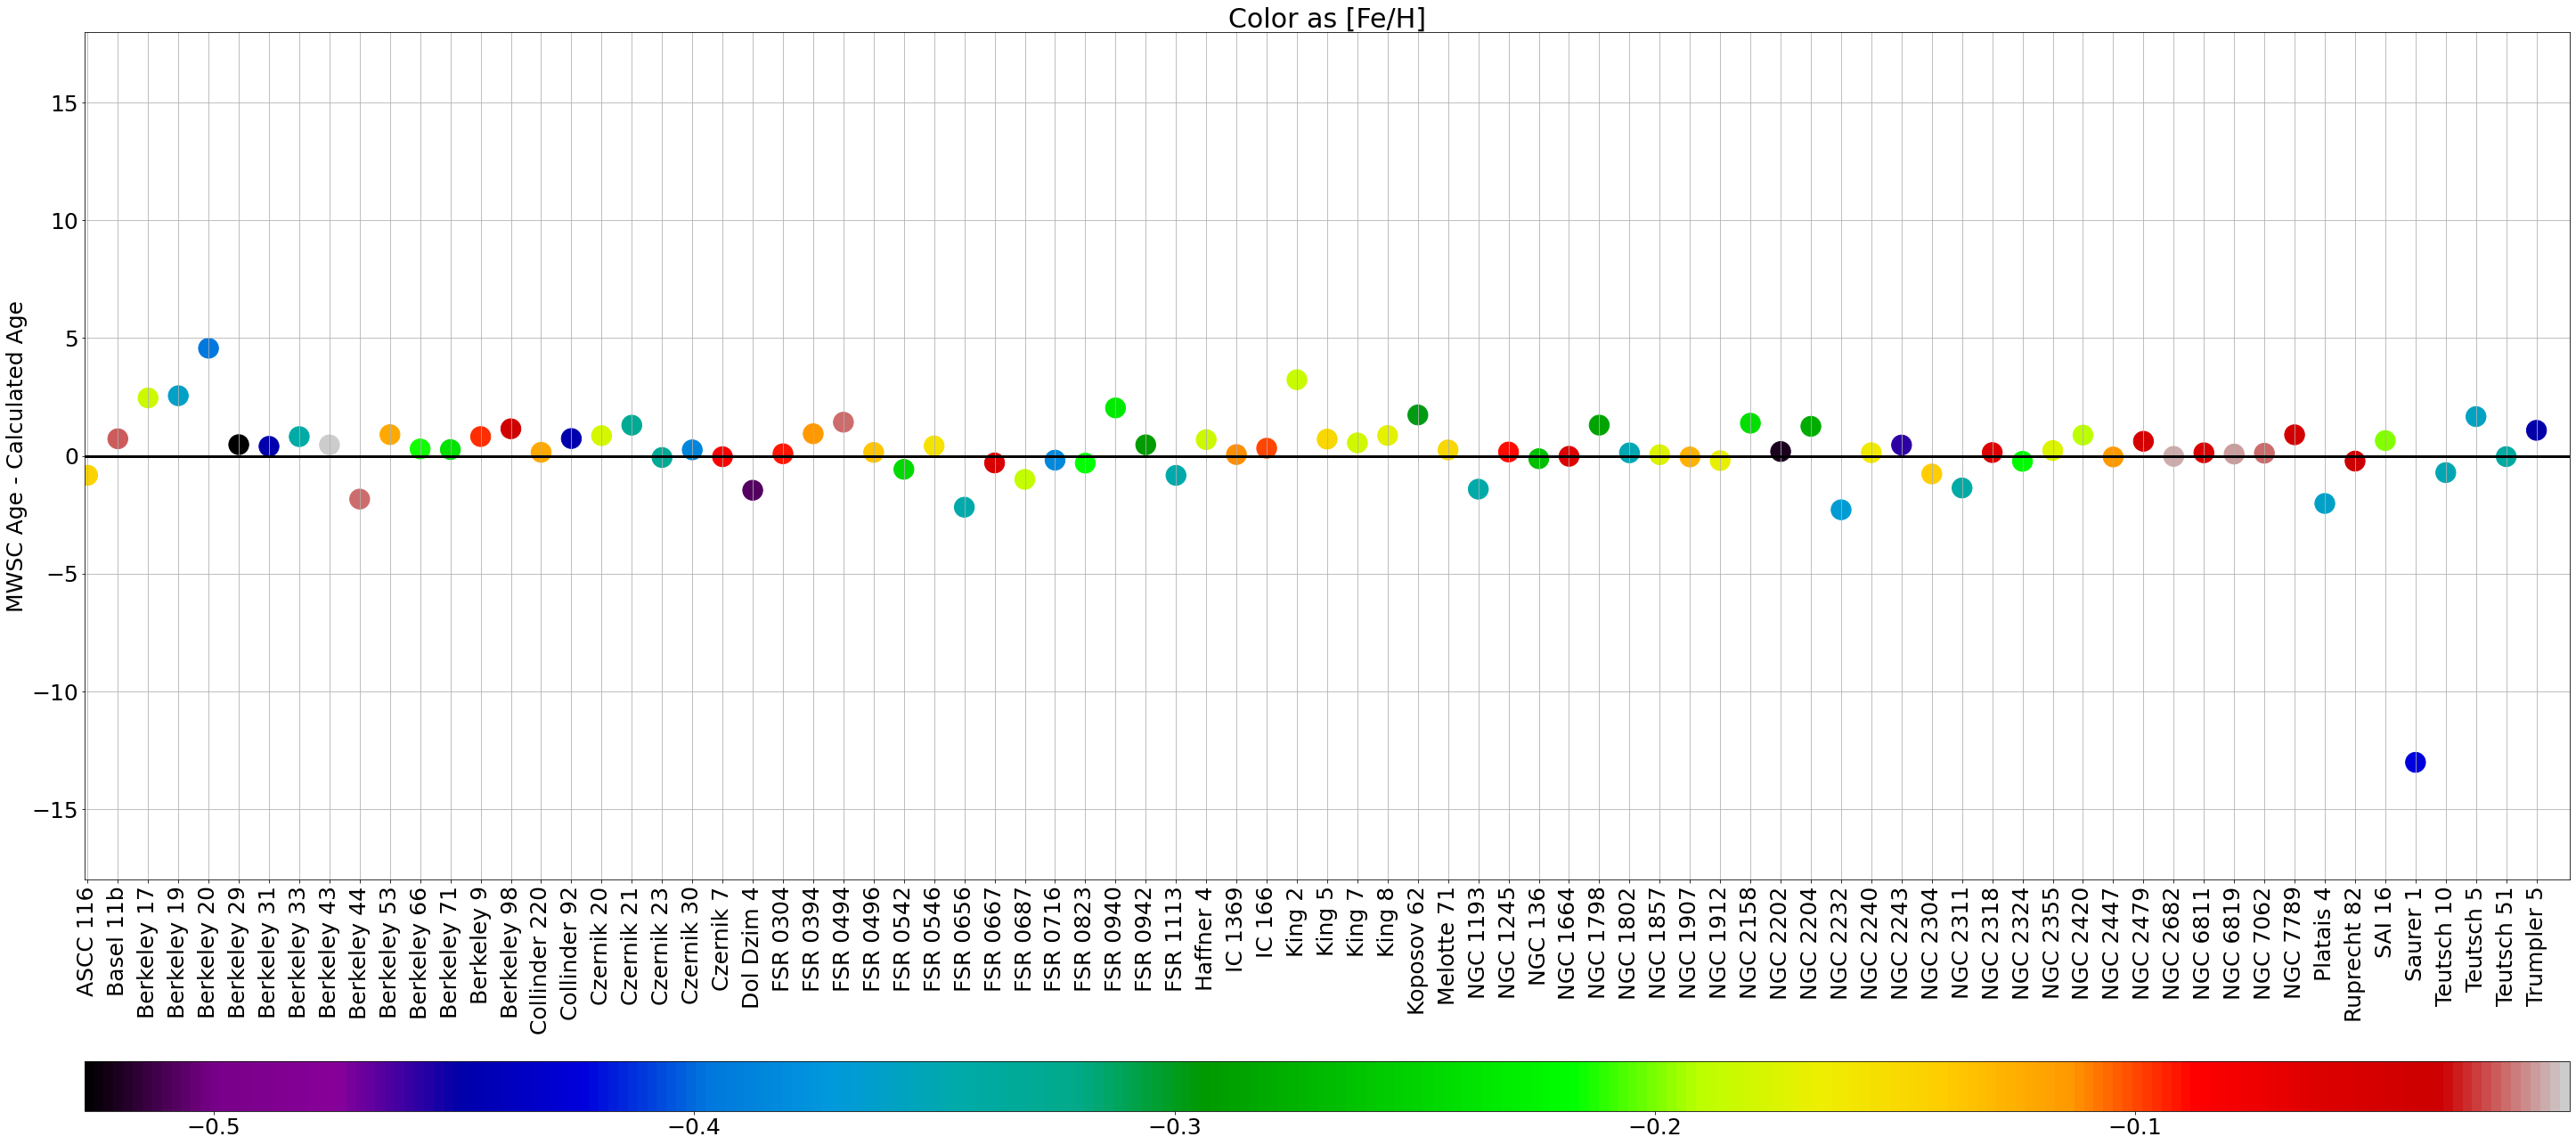

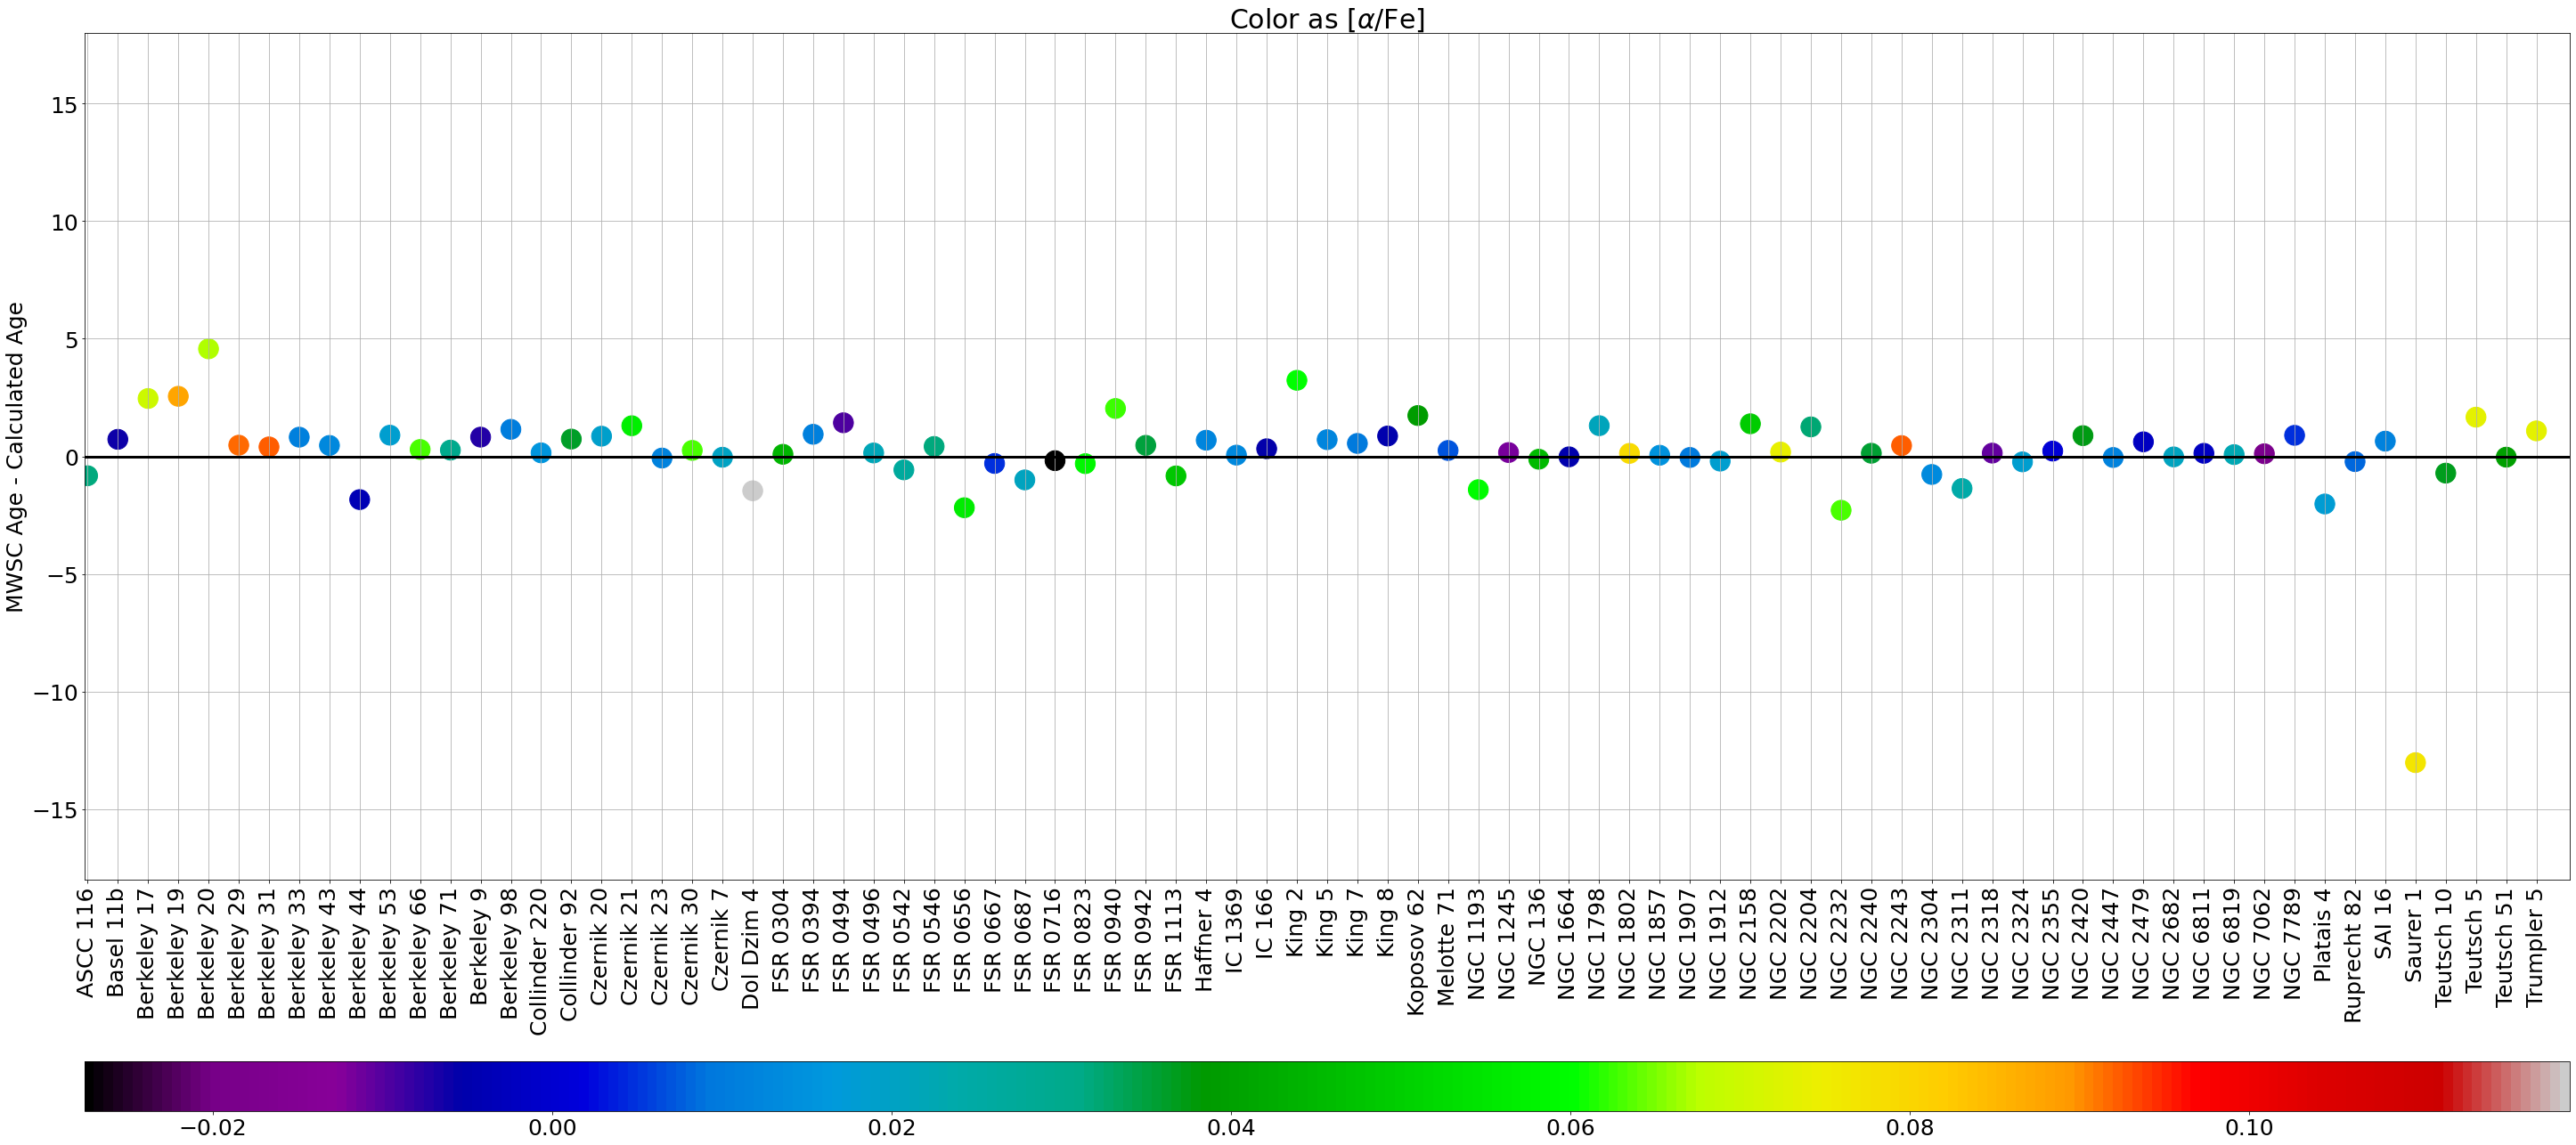

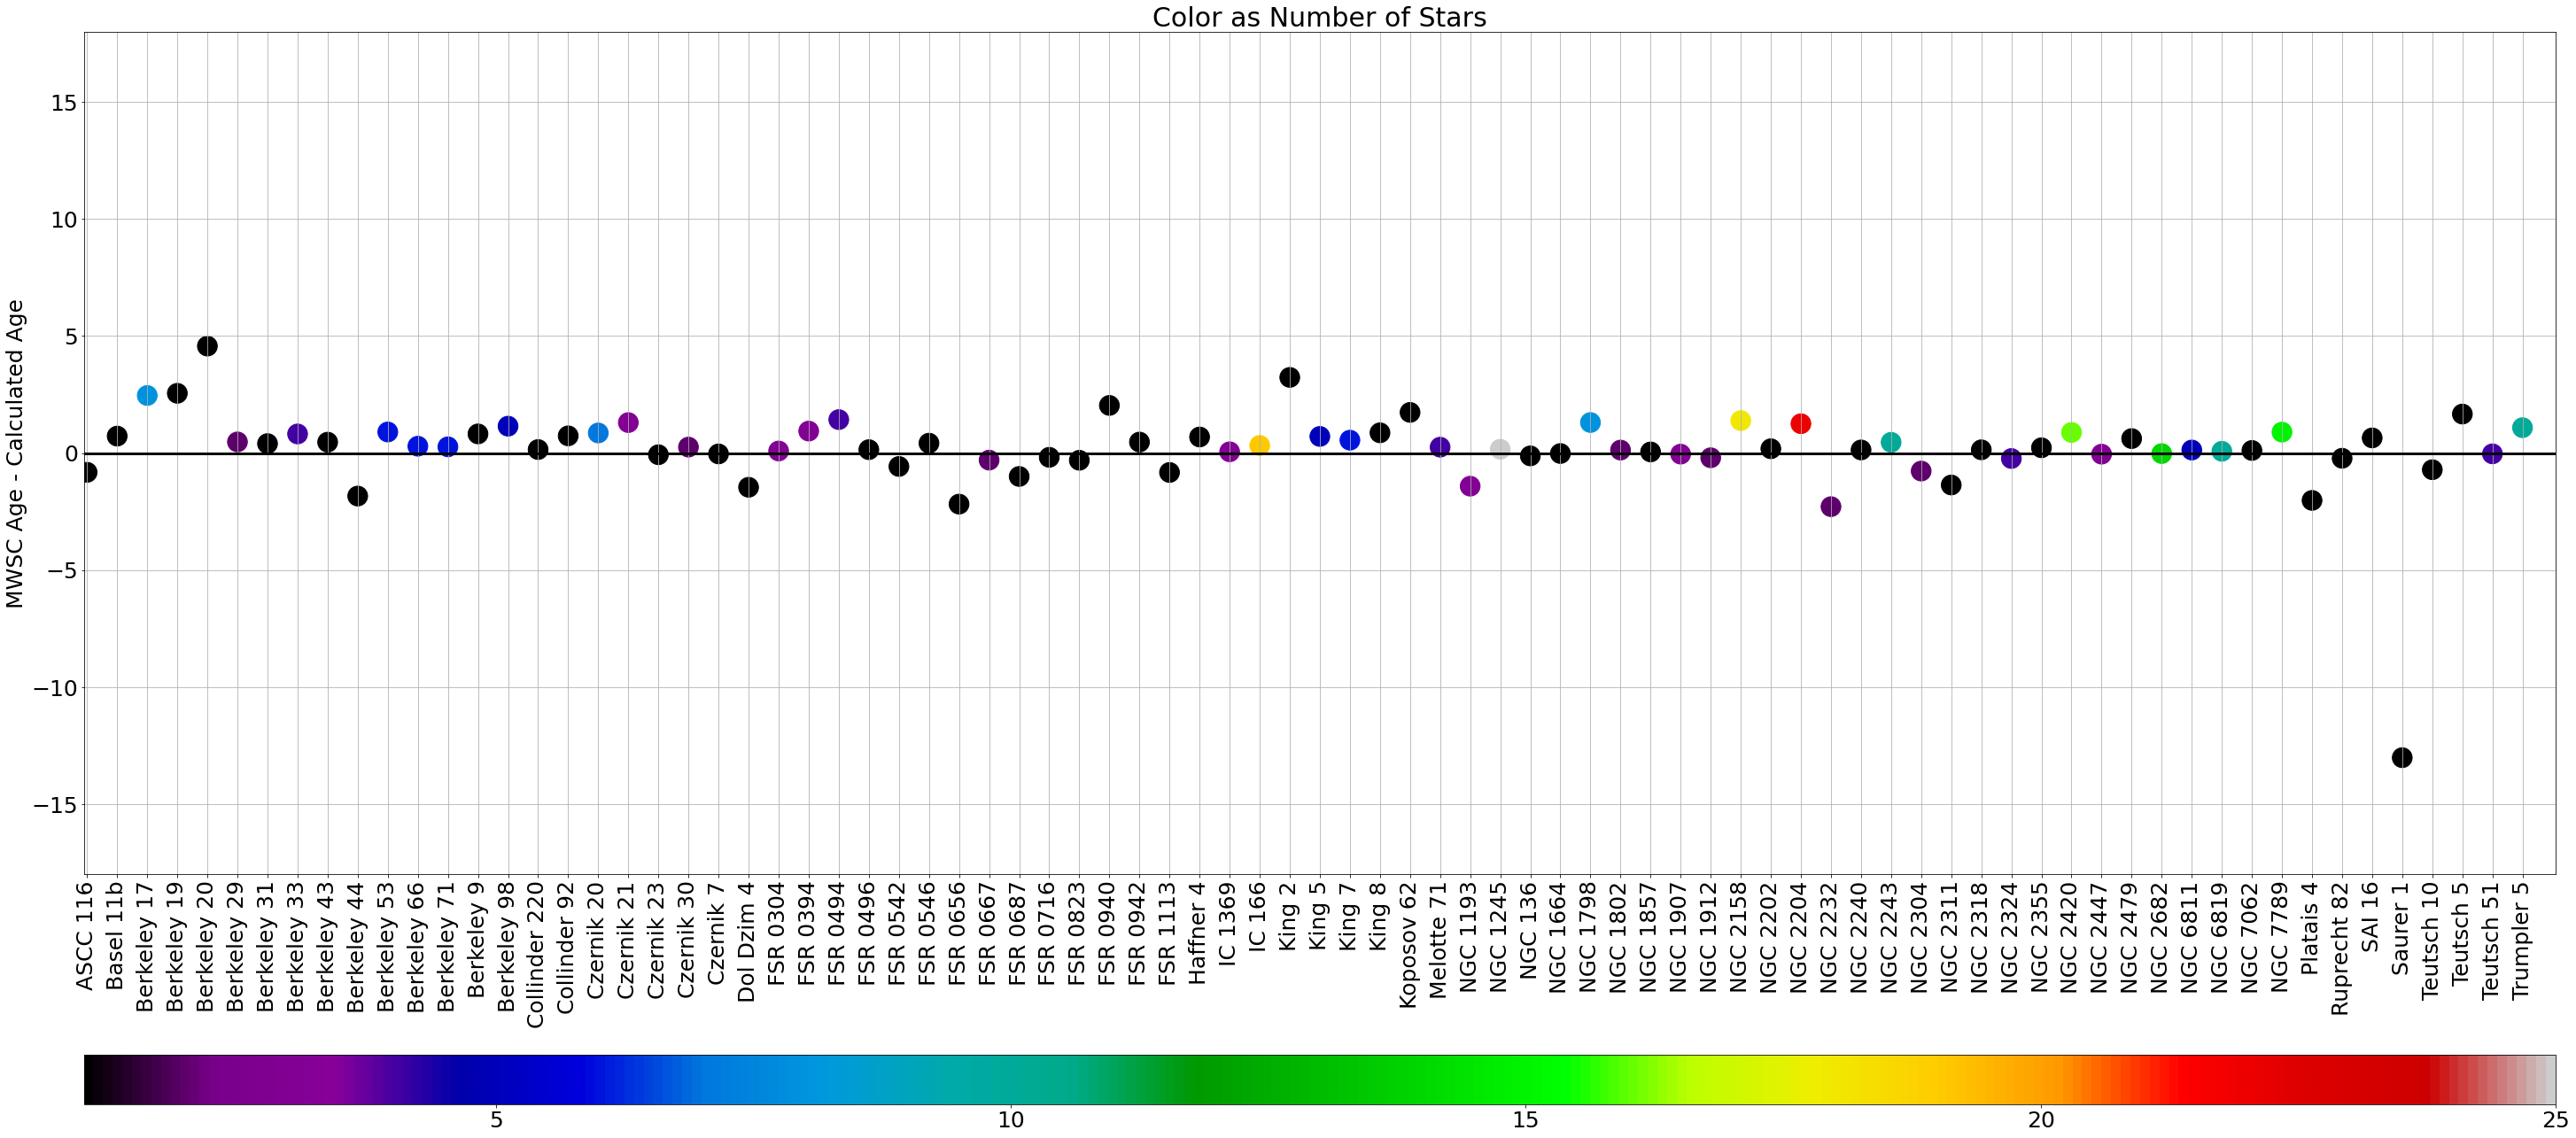

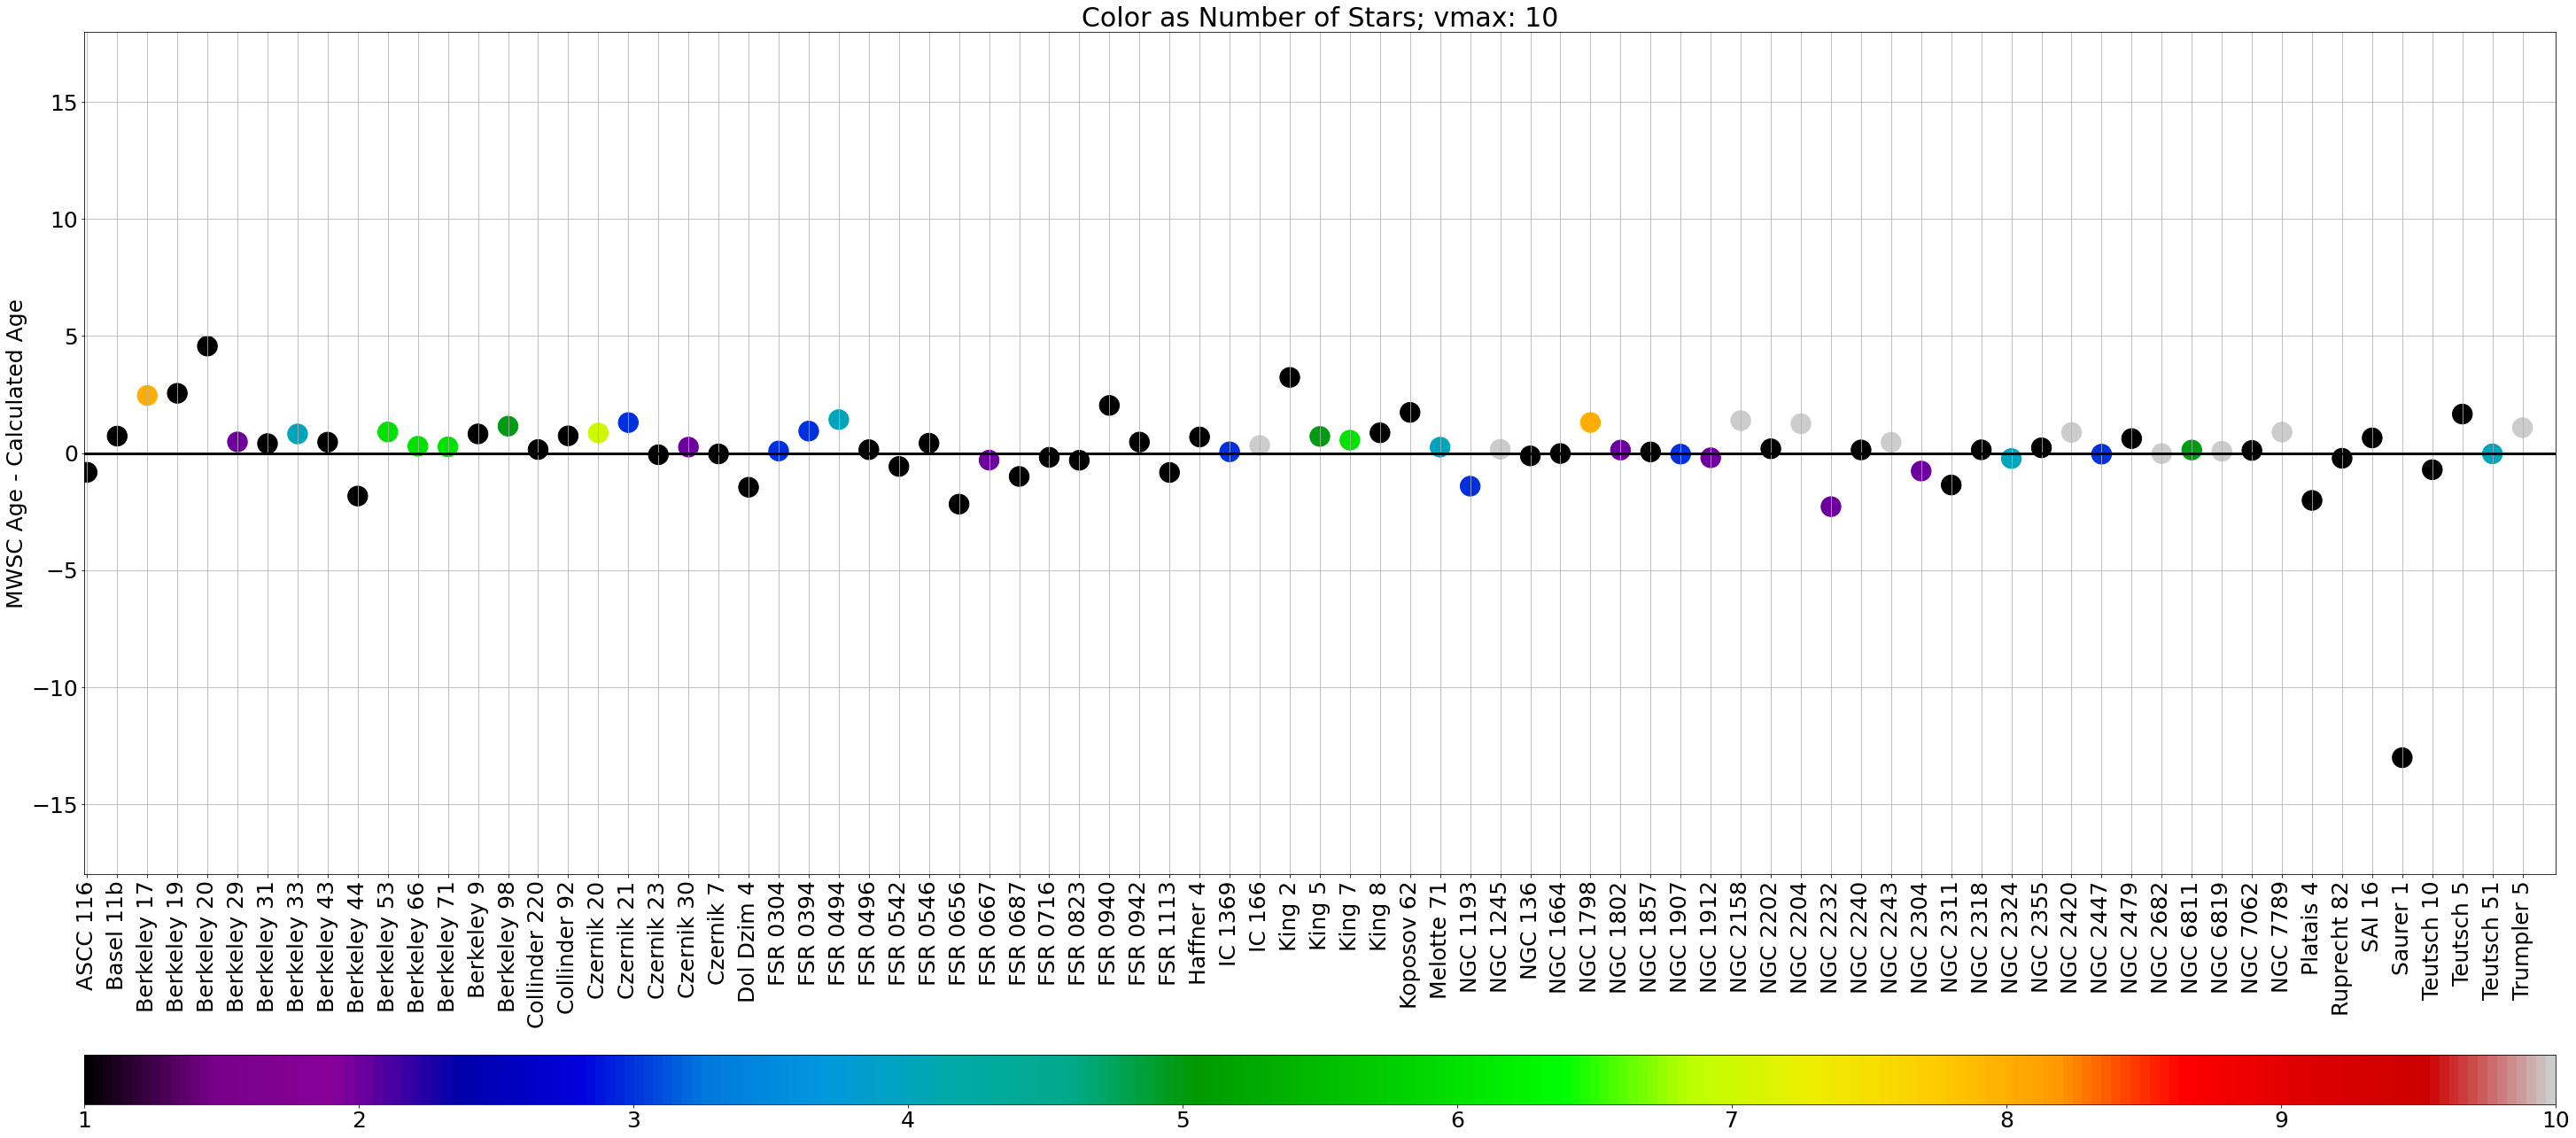

In [115]:
plt.figure(figsize=[50,25])
plt.plot(octab1[tab_ind]['Age']-calc_age,lw=3.0,marker='o')
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(-0.1,len(np.squeeze(tab_ind))+0.1)
plt.ylim(-18,18)
plt.xticks(range(len(np.squeeze(tab_ind))),labels=np.unique(ocmemdr17['CLUSTER']),rotation=90)
plt.grid()
plt.title(r'Open Cluster Age Residual')
plt.ylabel(r'MWSC Age - Calculated Age')
plt.show()

plt.figure(figsize=[50,25])
plt.scatter(range(len(np.squeeze(tab_ind))),octab1[tab_ind]['Age']-calc_age,c=calc_feh,cmap='nipy_spectral',s=500)
plt.colorbar(orientation='horizontal',aspect=50)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(-0.1,len(np.squeeze(tab_ind))+0.1)
plt.ylim(-18,18)
plt.xticks(range(len(np.squeeze(tab_ind))),labels=np.unique(ocmemdr17['CLUSTER']),rotation=90)
plt.grid()
plt.title(r'Color as [Fe/H]')
plt.ylabel(r'MWSC Age - Calculated Age')
plt.savefig('../plots/occam_resid_feh.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[50,25])
plt.scatter(range(len(np.squeeze(tab_ind))),octab1[tab_ind]['Age']-calc_age,c=calc_alp,cmap='nipy_spectral',s=500)
plt.colorbar(orientation='horizontal',aspect=50)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(-0.1,len(np.squeeze(tab_ind))+0.1)
plt.ylim(-18,18)
plt.xticks(range(len(np.squeeze(tab_ind))),labels=np.unique(ocmemdr17['CLUSTER']),rotation=90)
plt.grid()
plt.title(r'Color as [$\alpha$/Fe]')
plt.ylabel(r'MWSC Age - Calculated Age')
plt.savefig('../plots/occam_resid_alpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[50,25])
plt.scatter(range(len(np.squeeze(tab_ind))),octab1[tab_ind]['Age']-calc_age,c=calc_n,cmap='nipy_spectral',s=500)
plt.colorbar(orientation='horizontal',aspect=50)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(-0.1,len(np.squeeze(tab_ind))+0.1)
plt.ylim(-18,18)
plt.xticks(range(len(np.squeeze(tab_ind))),labels=np.unique(ocmemdr17['CLUSTER']),rotation=90)
plt.grid()
plt.title(r'Color as Number of Stars')
plt.ylabel(r'MWSC Age - Calculated Age')
plt.savefig('../plots/occam_resid_number.pdf',dpi=300,bbox_inches='tight')
plt.show()

vm = 10
plt.figure(figsize=[50,25])
plt.scatter(range(len(np.squeeze(tab_ind))),octab1[tab_ind]['Age']-calc_age,c=calc_n,cmap='nipy_spectral',
            vmax=vm,s=500)
plt.colorbar(orientation='horizontal',aspect=50)
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(-0.1,len(np.squeeze(tab_ind))+0.1)
plt.ylim(-18,18)
plt.xticks(range(len(np.squeeze(tab_ind))),labels=np.unique(ocmemdr17['CLUSTER']),rotation=90)
plt.grid()
plt.title(r'Color as Number of Stars; vmax: {}'.format(vm))
plt.ylabel(r'MWSC Age - Calculated Age')
plt.savefig('../plots/occam_resid_number10.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Alpha

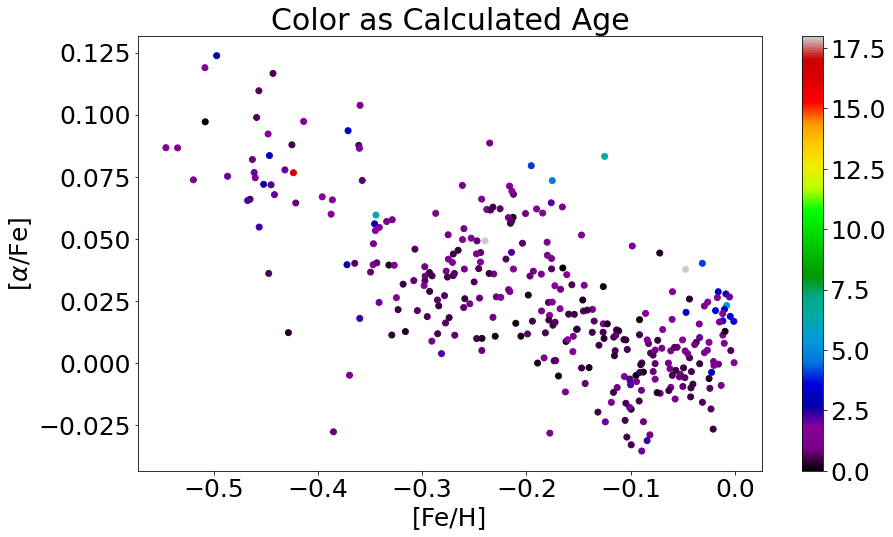

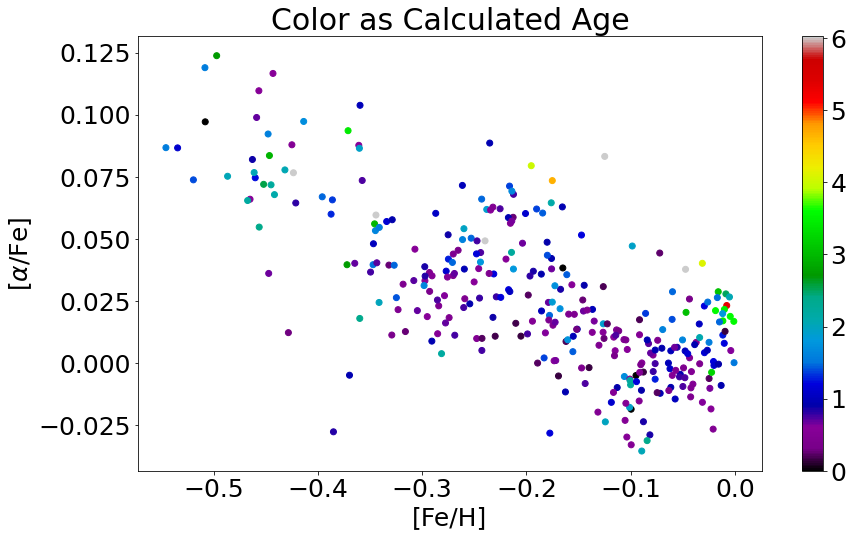

In [116]:
plt.figure(figsize=[14,8])
plt.scatter(occamdr17['FE_H'],(occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']),
            c=agetab['AGE'],cmap='nipy_spectral',vmax=18)
plt.colorbar()

plt.title(r'Color as Calculated Age')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.savefig('../plots/occam_feh_afe_calcage.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[14,8])
plt.scatter(occamdr17['FE_H'],(occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']),
            c=agetab['AGE'],cmap='nipy_spectral',
            vmax=max(octab1[tab_ind]['Age']),vmin=min(octab1[tab_ind]['Age']))
plt.colorbar()

plt.title(r'Color as Calculated Age')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.savefig('../plots/occam_feh_afe_calcage_norm.pdf',dpi=300,bbox_inches='tight')
plt.show()

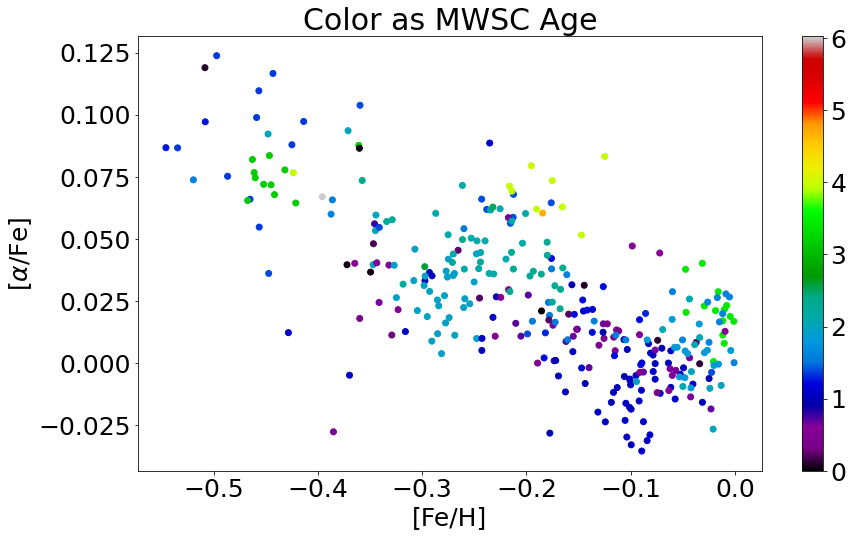

In [117]:
litages = 999999.0*np.ones(len(occamdr17))

for i in range(len(np.unique(ocmemdr17['CLUSTER']))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[i])
    
    litages[clus] = octab1[tab_ind]['Age'][i]


plt.figure(figsize=[14,8])
plt.scatter(occamdr17['FE_H'],(occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']),
            c=litages,cmap='nipy_spectral')
plt.colorbar()

plt.title(r'Color as MWSC Age')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.savefig('../plots/occam_feh_afe_litage.pdf',dpi=300,bbox_inches='tight')
plt.show()

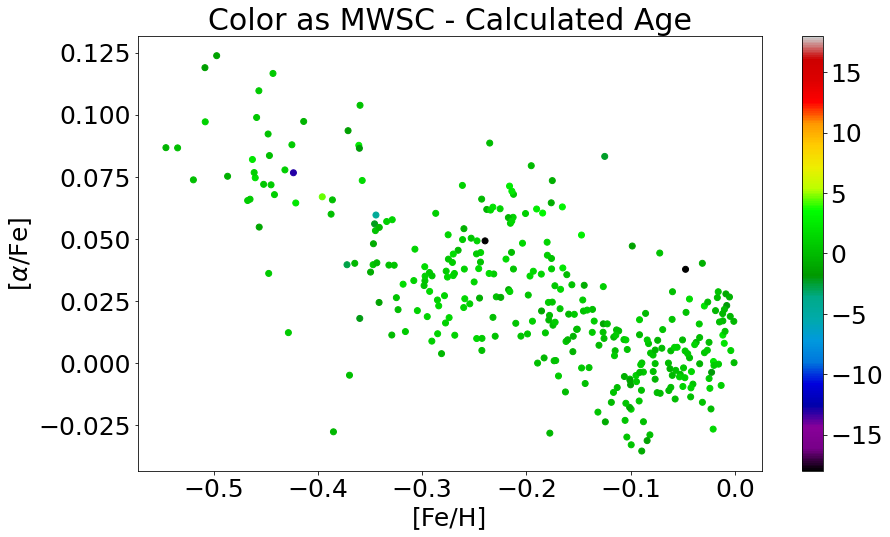

In [118]:
plt.figure(figsize=[14,8])
plt.scatter(occamdr17['FE_H'],(occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']),
            c=litages-agetab['AGE'],cmap='nipy_spectral',vmax=18,vmin=(-18))
plt.colorbar()

plt.title(r'Color as MWSC - Calculated Age')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.savefig('../plots/occam_feh_afe_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Isochrone Plots

In [197]:
oclabs = np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)].replace(' ','_')
print(oclabs)

over5 = np.where((octab1[tab_ind]['Name']=='Berkeley_17')|(octab1[tab_ind]['Name']=='Berkeley_53')|
                 (octab1[tab_ind]['Name']=='Berkeley_66')|(octab1[tab_ind]['Name']=='Berkeley_71')|
                 (octab1[tab_ind]['Name']=='Czernik_20')|(octab1[tab_ind]['Name']=='IC_166')|
                 (octab1[tab_ind]['Name']=='King_7')|(octab1[tab_ind]['Name']=='NGC_1245')|
                 (octab1[tab_ind]['Name']=='NGC_1798')|(octab1[tab_ind]['Name']=='NGC_2158')|
                 (octab1[tab_ind]['Name']=='NGC_2204')|(octab1[tab_ind]['Name']=='NGC_2243')|
                 (octab1[tab_ind]['Name']=='NGC_2420')|(octab1[tab_ind]['Name']=='NGC_2682')|
                 (octab1[tab_ind]['Name']=='NGC_6819')|(octab1[tab_ind]['Name']=='NGC_7789')|
                 (octab1[tab_ind]['Name']=='Trumpler_5'))

octab5 = octab1[tab_ind][over5]
octab5.columns

['Berkeley_17' 'Berkeley_53' 'Berkeley_66' 'Berkeley_71' 'Czernik_20'
 'IC_166' 'King_7' 'NGC_1245' 'NGC_1798' 'NGC_2158' 'NGC_2204' 'NGC_2243'
 'NGC_2420' 'NGC_2682' 'NGC_6819' 'NGC_7789' 'Trumpler_5']


<TableColumns names=('Name','Qual','GLON','GLAT','Radius','Age','Rgc','pmRA','e_pmRA','pmDE','e_pmDE','HRV','e_HRV','FEH','e_FEH','N')>

<ipython-input-249-76dd718de9dc>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(oclabs))):


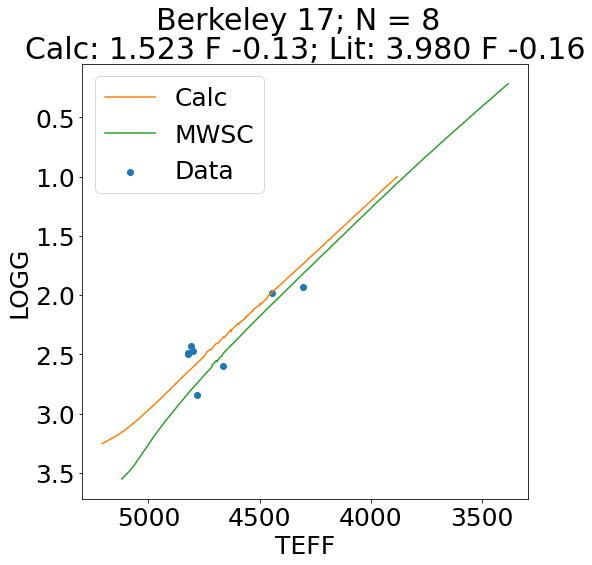

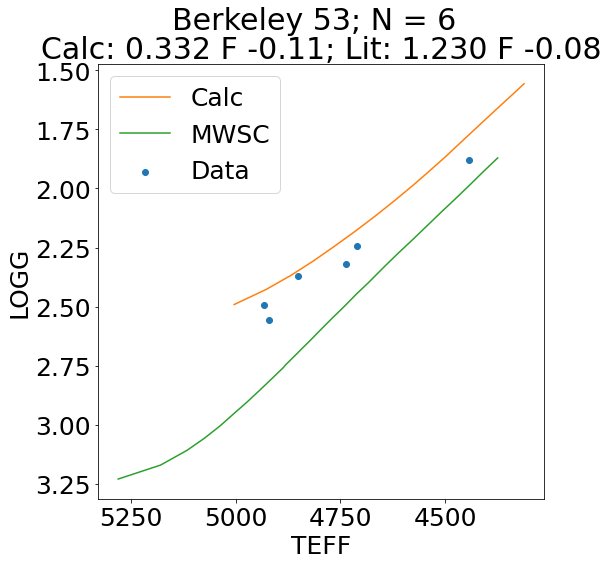

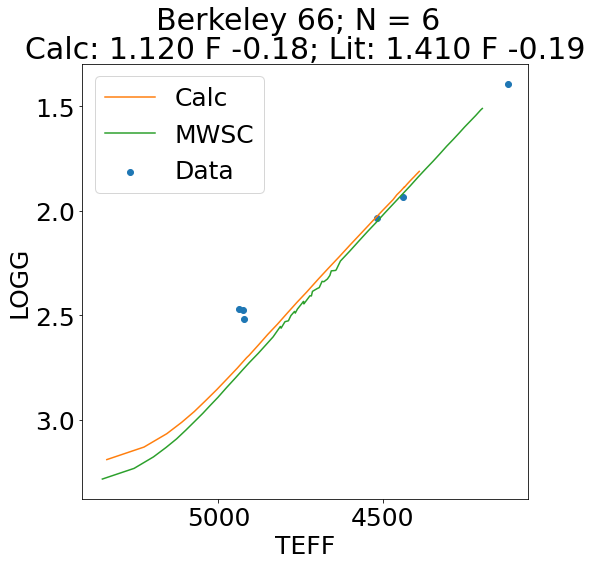

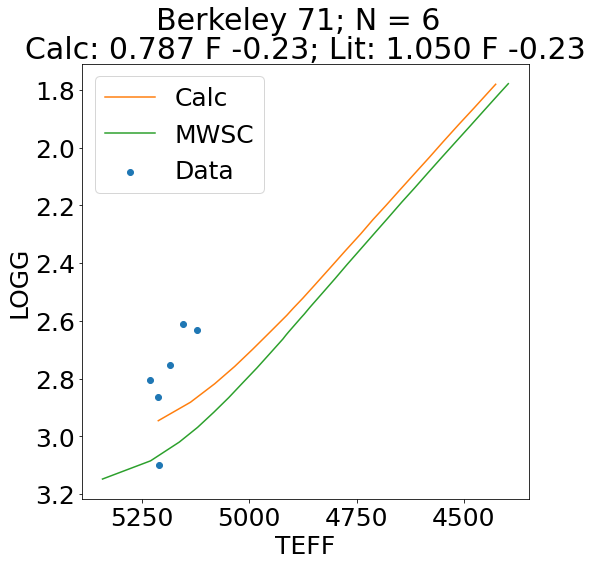

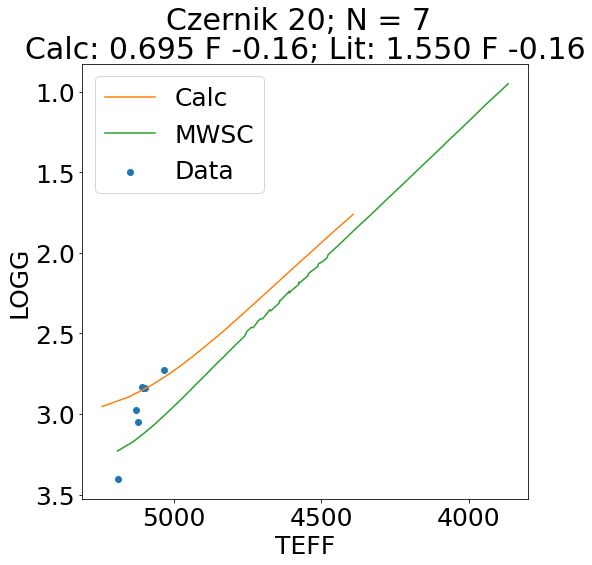

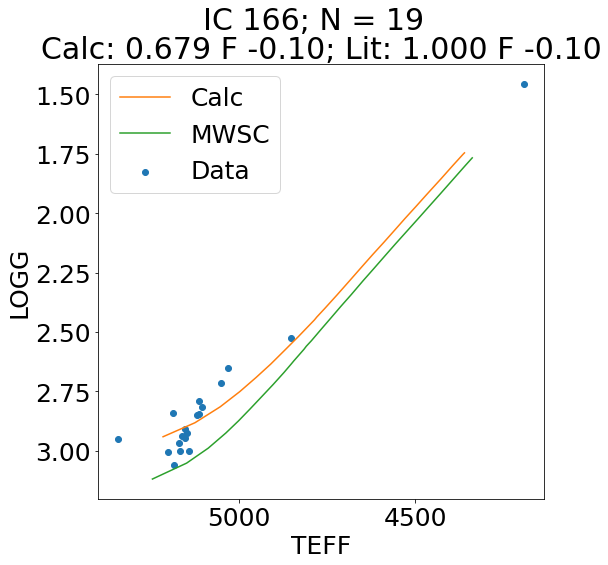

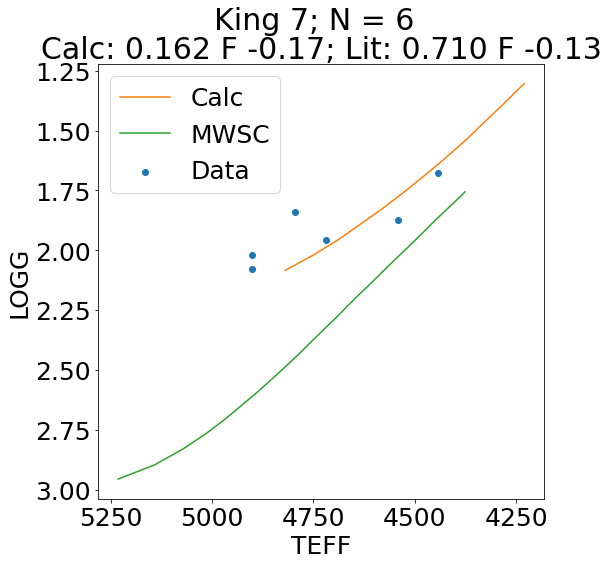

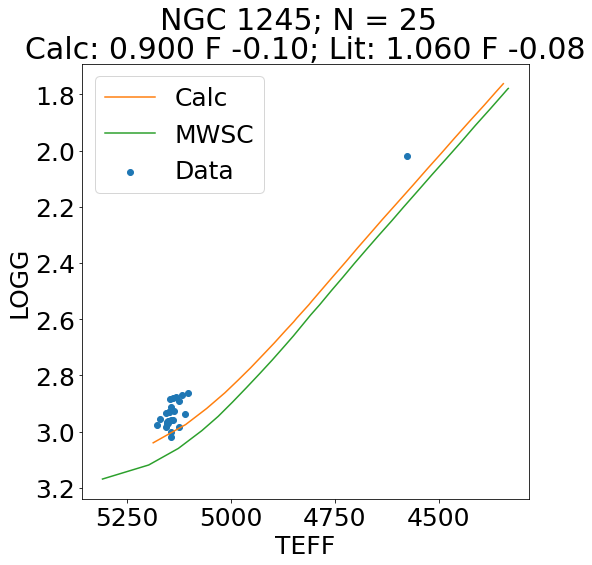

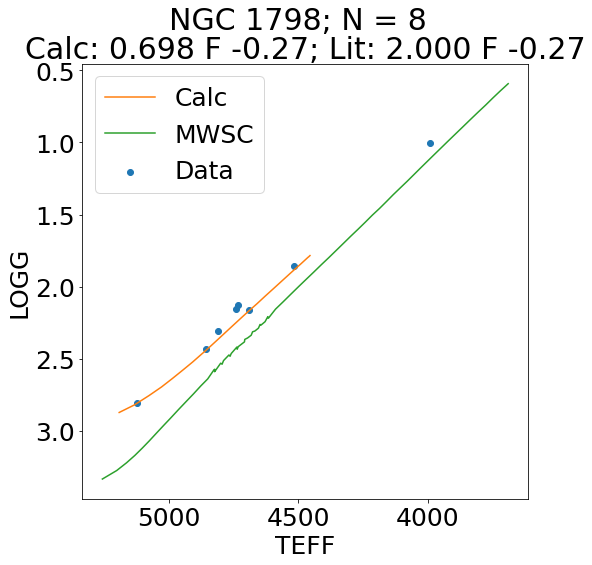

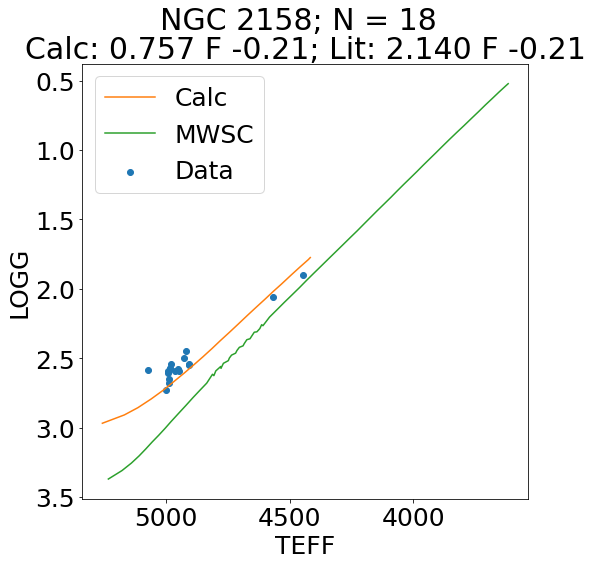

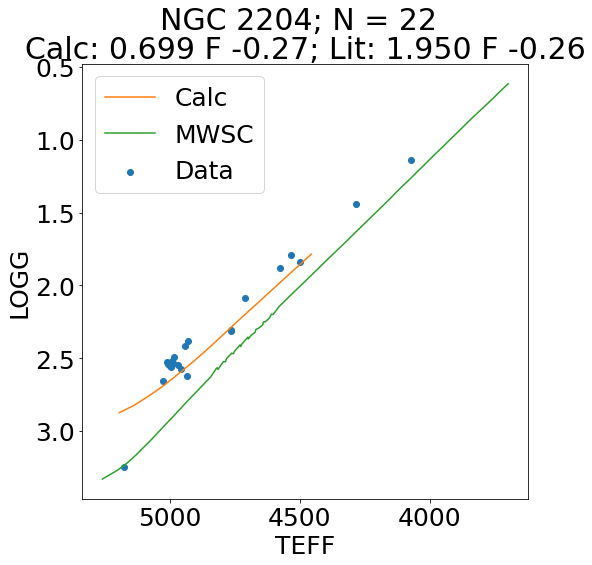

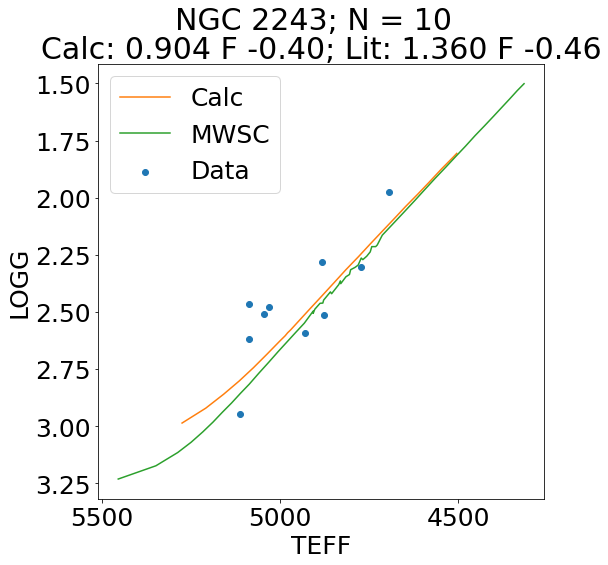

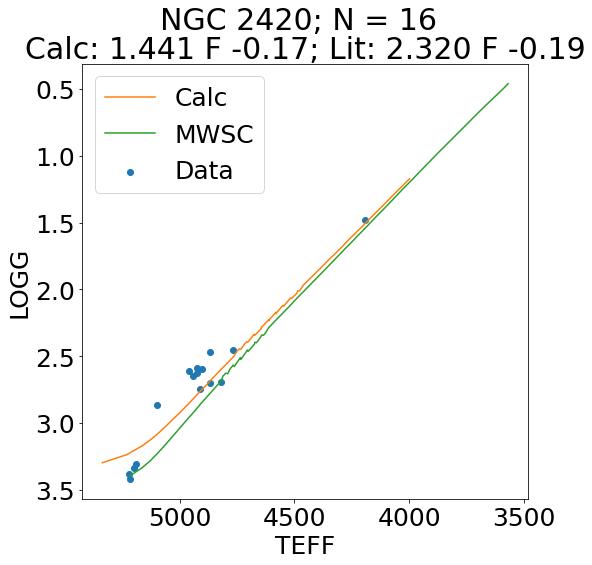

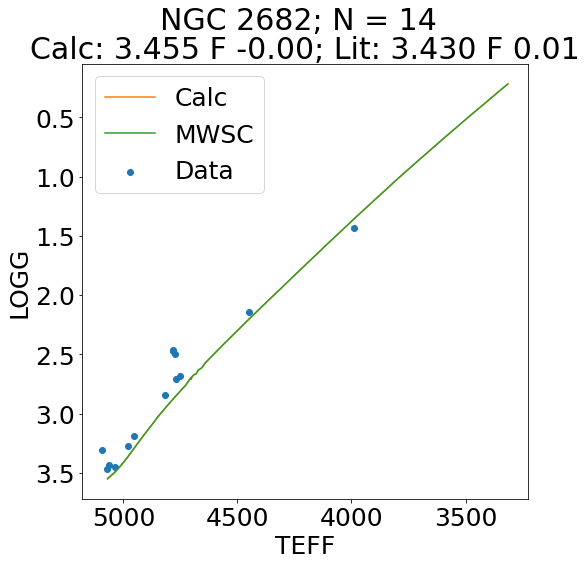

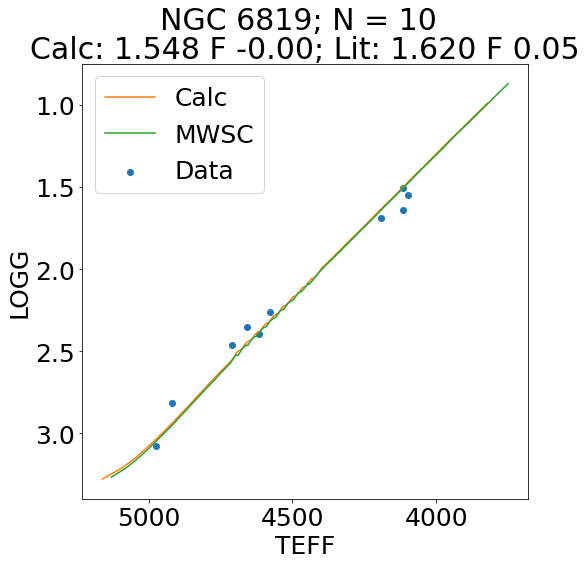

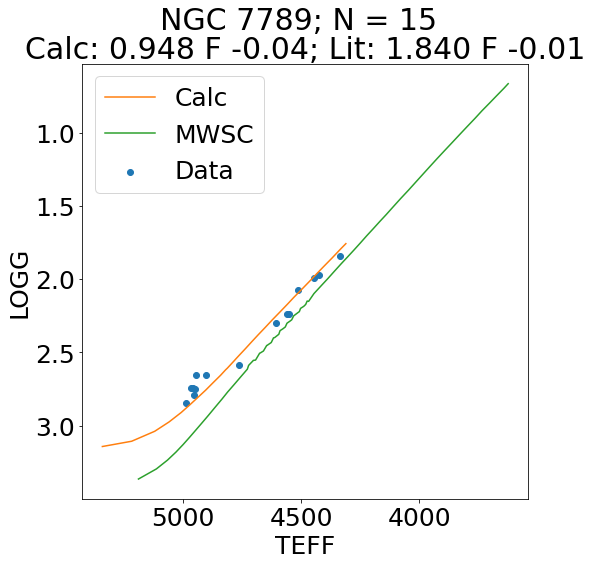

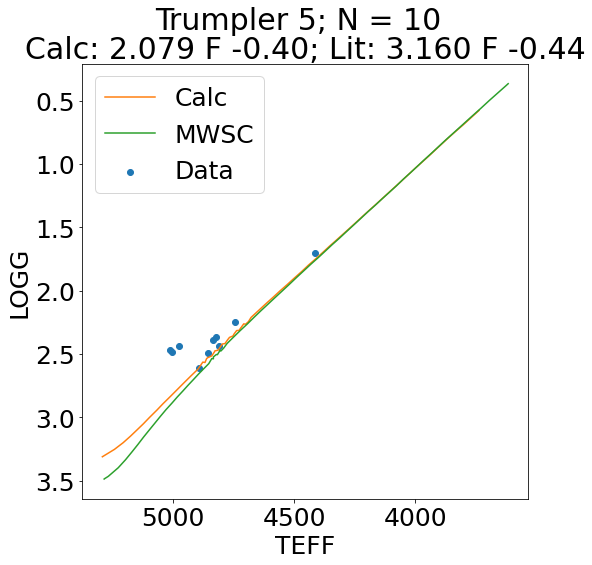

In [249]:
for i in tqdm_notebook(range(len(oclabs))):
    clus = np.where(ocmemdr17['CLUSTER']==(oclabs.replace('_',' '))[i])
    med_calc_age = np.nanmedian(agetab['AGE'][clus])
    med_salfeh = np.nanmedian((occamdr17['FE_H']+np.log10(0.655*10**apoafe+0.345))[clus])
    
    lit_age = octab5['Age'][i]
    lit_feh = octab5['FEH'][i]
    
    age_diff = lit_age-med_calc_age
    
#     print(oclabs[i])
#     print('Med:',med_calc_age)
#     print('Lit: ',lit_age)
#     print('Diff: ',lit_age-med_calc_age)
    
#     if age_diff > 0.025:
#         print('Bigger Space')
#     else:
#         print('Smaller Space')
    
#     print('Sal: ',med_salfeh)
#     print('---')

    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(med_calc_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],med_salfeh)))]
    
    iso_calc = iso_calc[np.argsort(iso_calc['logTe'])] 
    
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(lit_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],lit_feh)))]
    
    iso_mwsc = iso_mwsc[np.argsort(iso_mwsc['logTe'])]
    
    plt.figure(figsize=[8,8])
    plt.scatter(occamdr17['TEFF'][clus],occamdr17['LOGG'][clus],label='Data')
    
    plt.plot(10**iso_calc['logTe'],iso_calc['logg'],label='Calc',c='tab:orange')
    plt.plot(10**iso_mwsc['logTe'],iso_mwsc['logg'],label='MWSC',c='tab:green')
    
    plt.legend()
    
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(oclabs.replace('_',' ')[i],np.size(np.squeeze(clus))))
    plt.title(r'Calc: {:.3f} F {:.2f}; Lit: {:.3f} F {:.2f}'.format(med_calc_age,med_salfeh,lit_age,lit_feh))
    plt.xlabel(r'TEFF')
    plt.ylabel(r'LOGG')
    plt.savefig('../plots/oc_hr_{}.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()

In [223]:
import astropy.coordinates as coord
import astropy.units as u

gc = coord.SkyCoord(l=octab5['GLON']*u.degree,b=(octab5['GLAT'])*u.degree,
                    distance=octab5['Rgc']*u.kpc,frame='galactic')

radecdist = gc.transform_to('icrs').distance.value

# litdist = 999999.0*np.ones(len(occamdr17))

# for i in range(len(np.unique(ocmemdr17['CLUSTER']))):
#     clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[i])
    
#     litdist[clus] = radecdist[i]

for i in range(len(oclabs)):
    print('{} {:.2f}'.format(oclabs[i],radecdist[i]))

Berkeley_17 9.79
Berkeley_53 8.67
Berkeley_66 14.08
Berkeley_71 11.26
Czernik_20 9.97
IC_166 11.68
King_7 10.36
NGC_1245 10.60
NGC_1798 13.05
NGC_2158 12.75
NGC_2204 10.85
NGC_2243 10.78
NGC_2420 10.61
NGC_2682 8.62
NGC_6819 7.69
NGC_7789 8.92
Trumpler_5 10.59


In [ ]:
Berkeley_17 9.79
Berkeley_53 8.67
Berkeley_66 14.08
Berkeley_71 11.26
Czernik_20 9.97
IC_166 11.68
King_7 10.36
NGC_1245 10.60
NGC_1798 13.05
NGC_2158 12.75
NGC_2204 10.85
NGC_2243 10.78
NGC_2420 10.61
NGC_2682 8.62
NGC_6819 7.69
NGC_7789 8.92
Trumpler_5 10.59

In [227]:
print(1/occamdr17['GAIAEDR3_PARALLAX'][np.where(ocmemdr17['CLUSTER']=='NGC 2158')])

np.median(1/occamdr17['GAIAEDR3_PARALLAX'][np.where(ocmemdr17['CLUSTER']=='NGC 2158')])

[  4.77132     4.1963987   4.869348    4.579171    4.1199102   4.14818
   5.749393    4.411838    4.6332693   4.371604    3.4045699 -42.09863
   4.267069    4.495602    3.7126663   3.82832     3.6144407   3.861002 ]


4.231734

In [234]:
ejk_ak

1.4901972382364816

<ipython-input-238-36e2dfecab81>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(oclabs))):


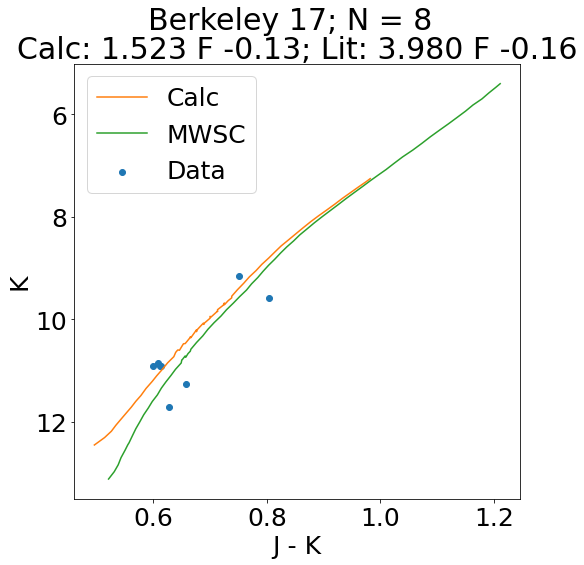

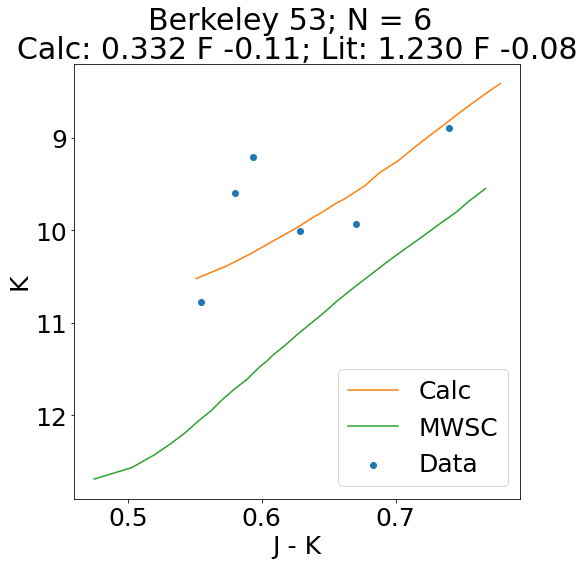

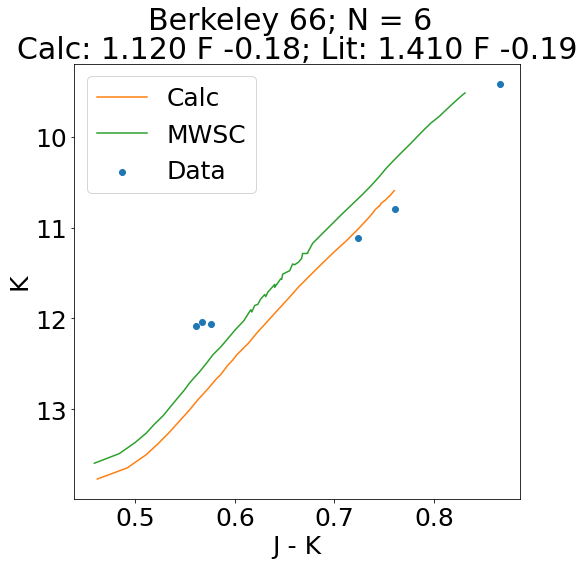

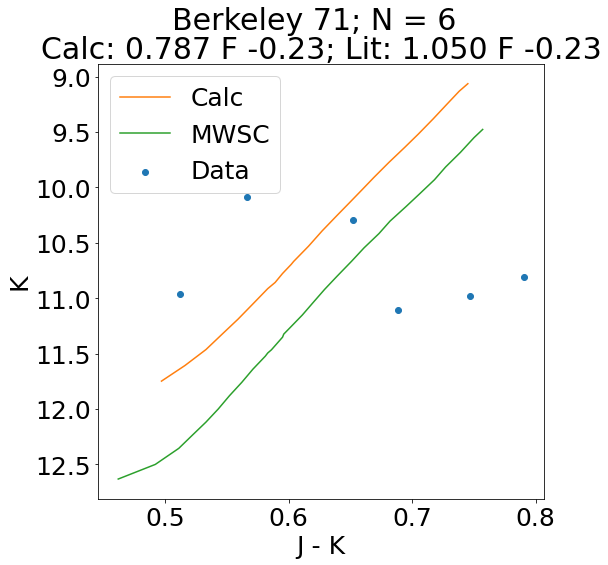

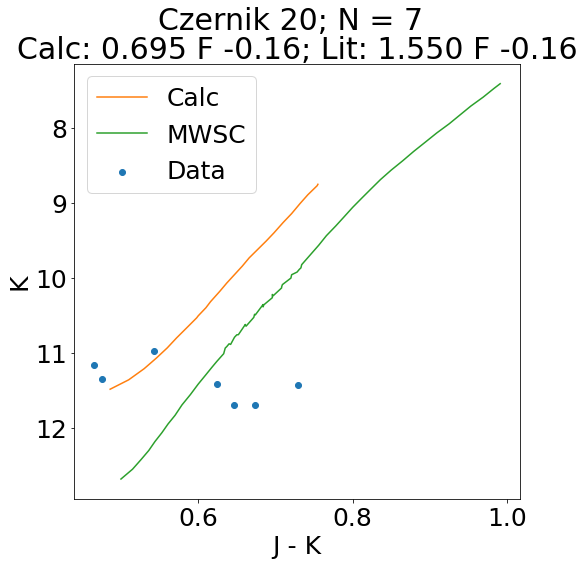

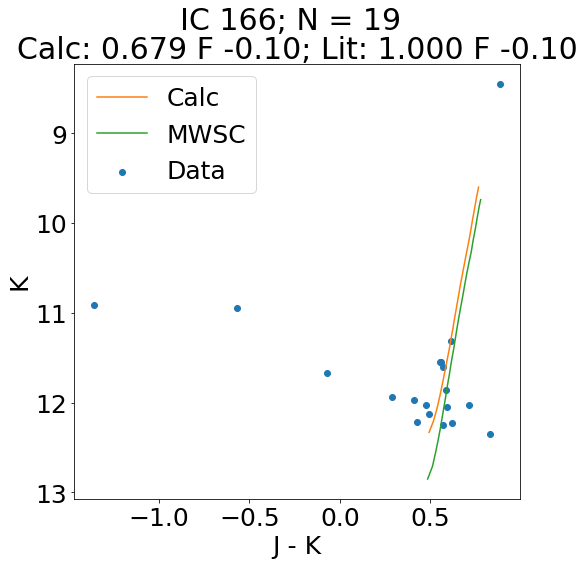

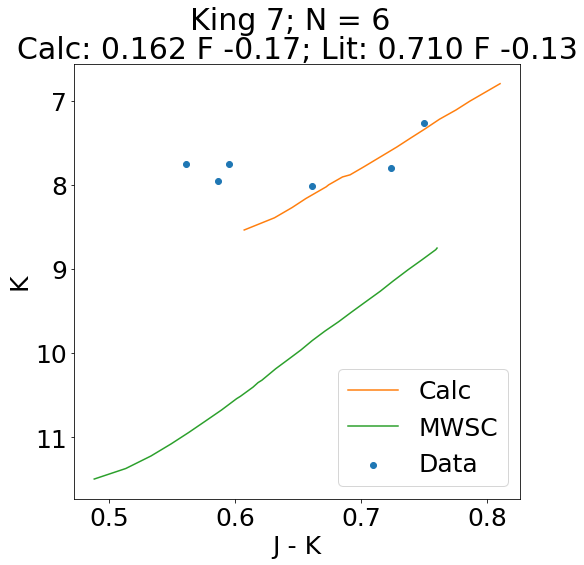

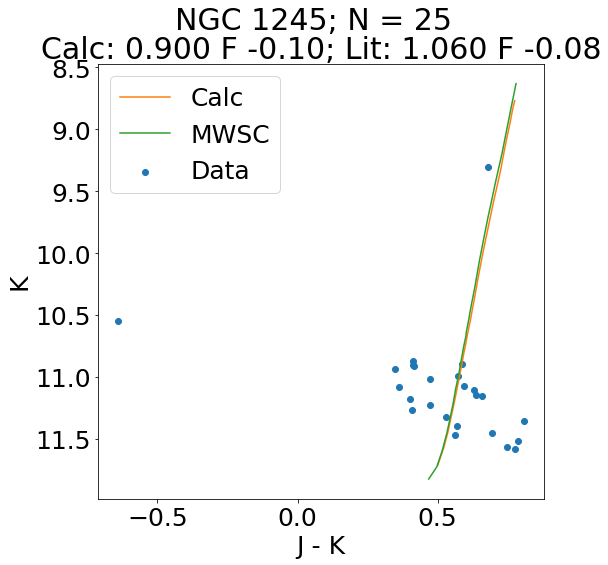

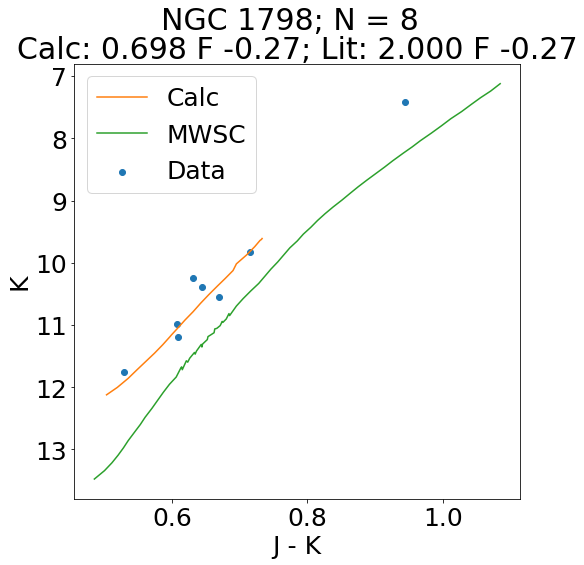

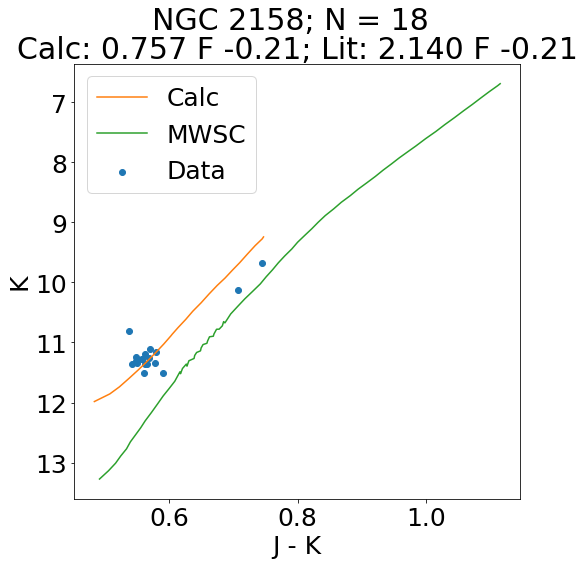

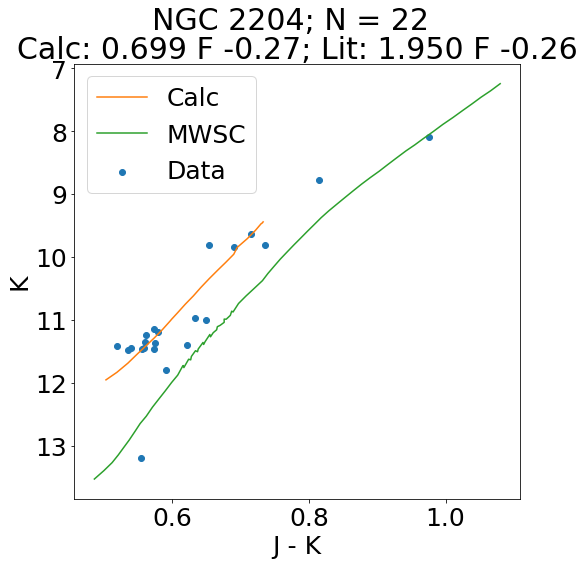

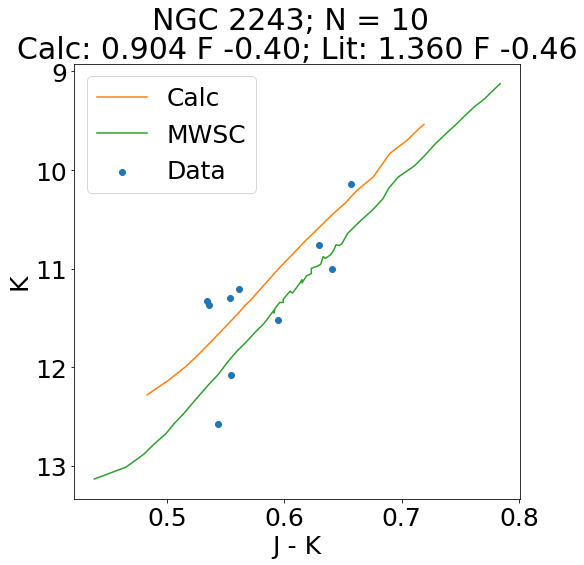

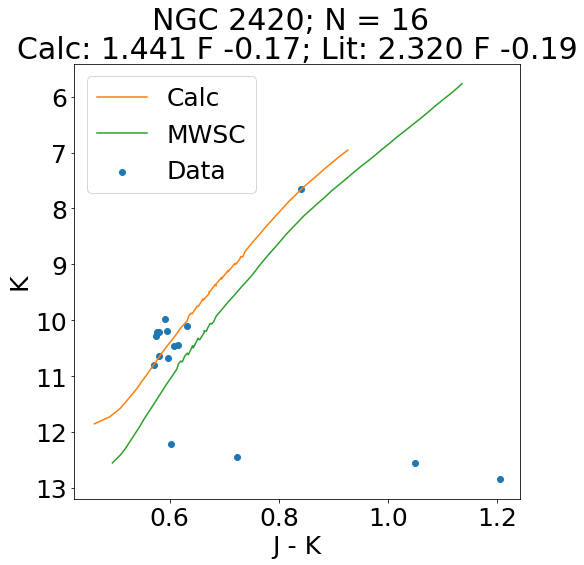

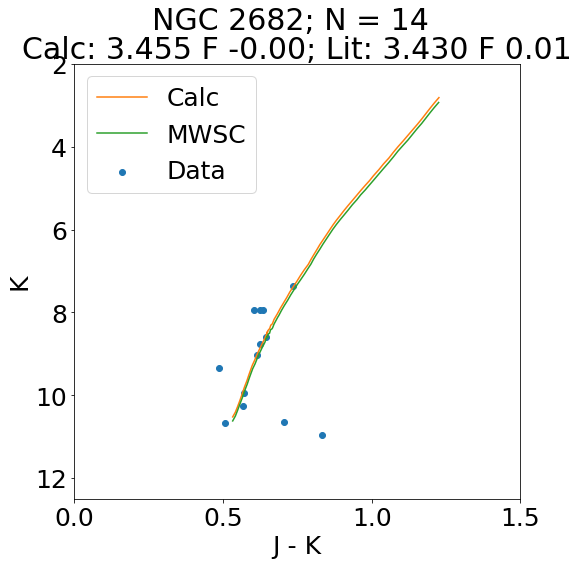

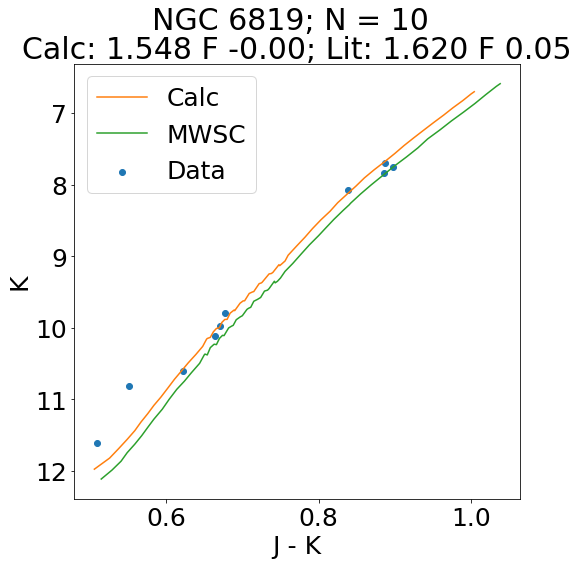

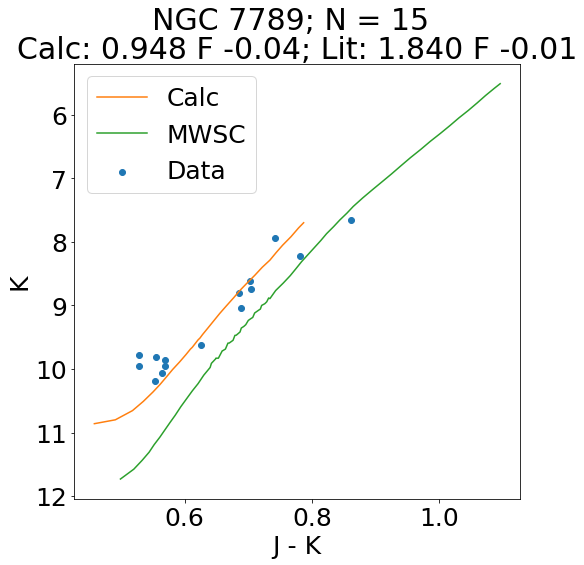

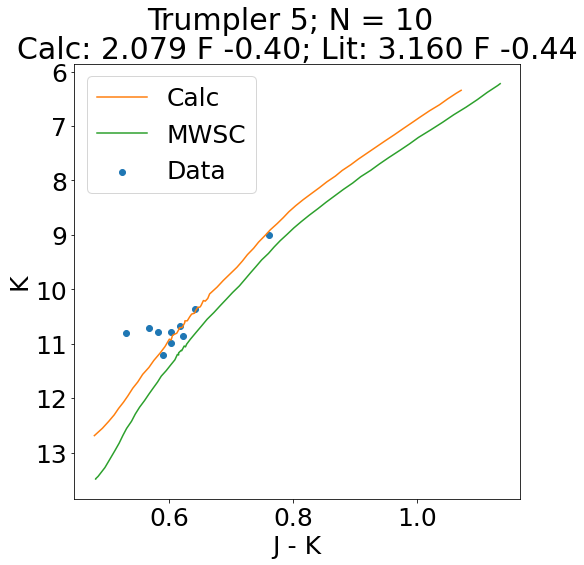

In [238]:
simbadoc5 = np.array([2.70,4.05,5.60,4.40,3.79,5.10,3.50,3.0,4.6,4.0,4.78,4.74,2.75,0.89,2.81,2.07,3.52])

for i in tqdm_notebook(range(len(oclabs))):
    clus = np.where(ocmemdr17['CLUSTER']==(oclabs.replace('_',' '))[i])
    med_calc_age = np.nanmedian(agetab['AGE'][clus])
    med_salfeh = np.nanmedian((occamdr17['FE_H']+np.log10(0.655*10**apoafe+0.345))[clus])
    
    lit_age = octab5['Age'][i]
    lit_feh = octab5['FEH'][i]
    
    distmod = 5*np.log10(np.nanmedian(1/occamdr17['GAIAEDR3_PARALLAX'][clus])*1000)-5.
    simdistmod = 5*np.log10(simbadoc5[i]*1000)-5.

    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(med_calc_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],med_salfeh)))]
    
    iso_calc = iso_calc[np.argsort(iso_calc['logTe'])] 
    
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(lit_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],lit_feh)))]
    
    iso_mwsc = iso_mwsc[np.argsort(iso_mwsc['logTe'])]
    
    plt.figure(figsize=[8,8])
    plt.scatter((occamdr17['J']-occamdr17['K']-ejk_ak*agetab['AK'])[clus],
                (occamdr17['K']-agetab['AK'])[clus],label='Data')
    
    plt.plot(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+distmod,label='Calc',c='tab:orange')
    plt.plot(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+simdistmod,label='MWSC',c='tab:green')
    
    plt.legend()
    
    if oclabs[i] == 'NGC_2682':
        plt.xlim(0,1.5)
        plt.ylim(2,12.5)
    
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(oclabs.replace('_',' ')[i],np.size(np.squeeze(clus))))
    plt.title(r'Calc: {:.3f} F {:.2f}; Lit: {:.3f} F {:.2f}'.format(med_calc_age,med_salfeh,lit_age,lit_feh))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

<ipython-input-240-14be355c5369>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(oclabs))):


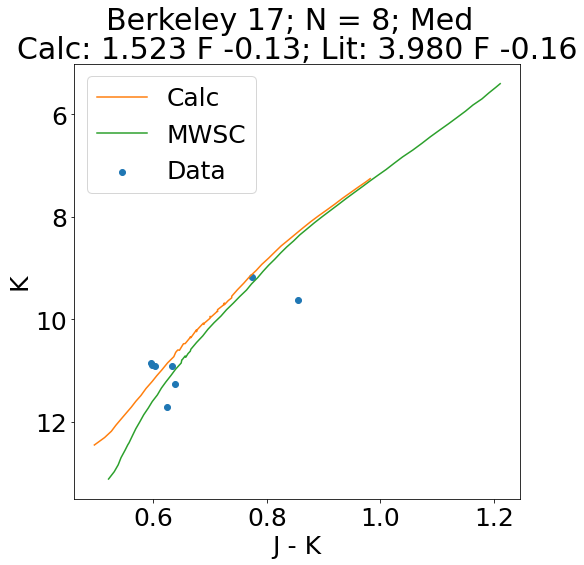

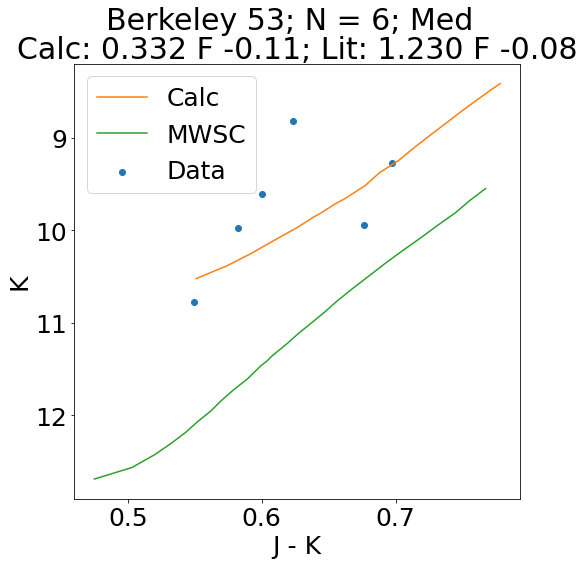

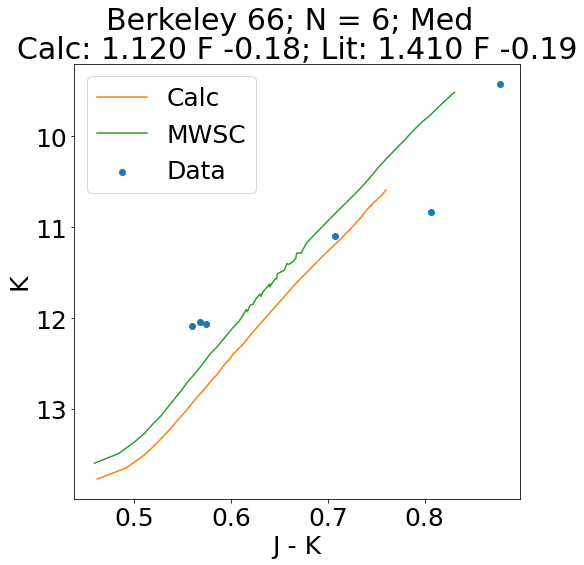

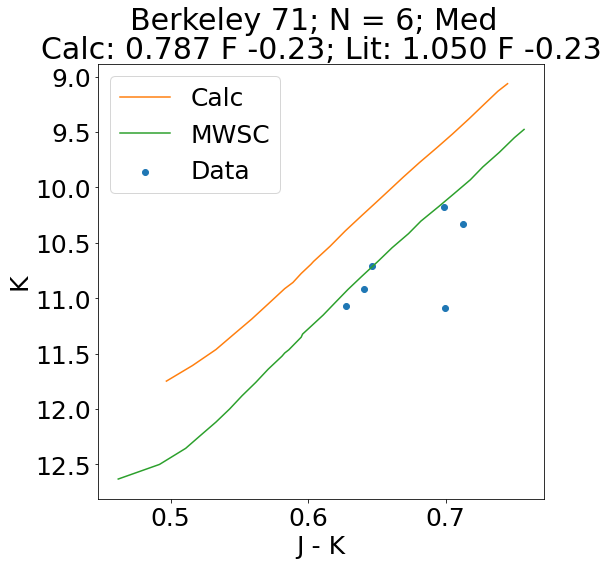

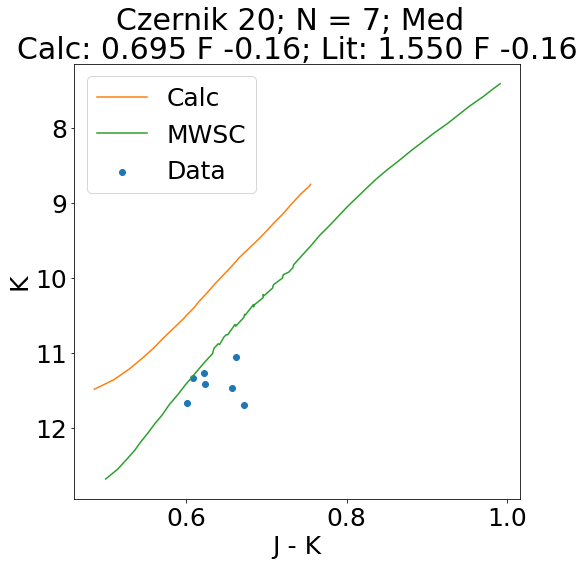

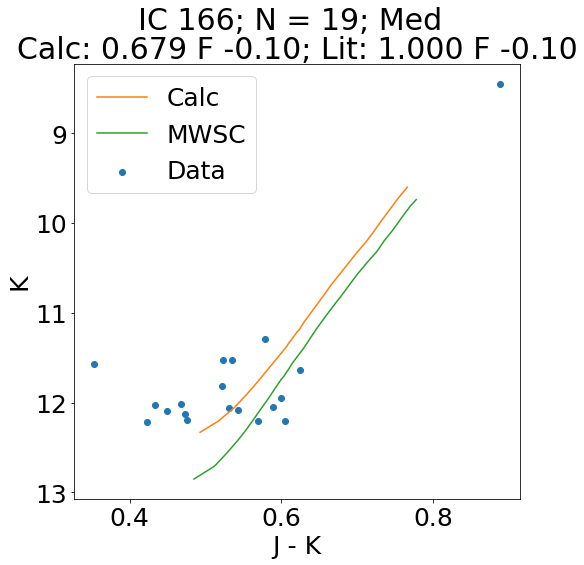

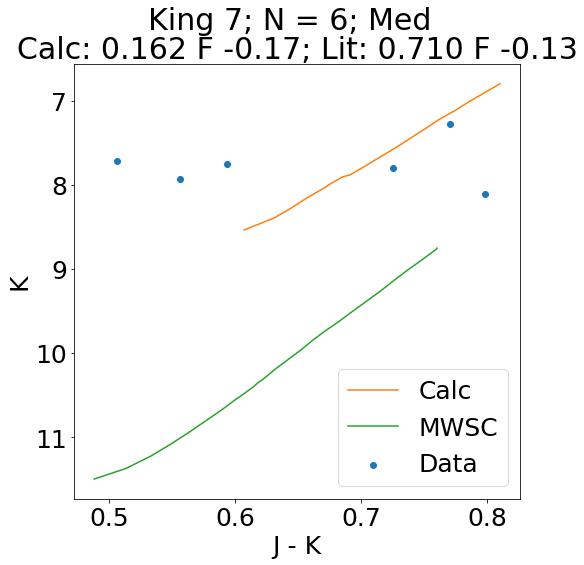

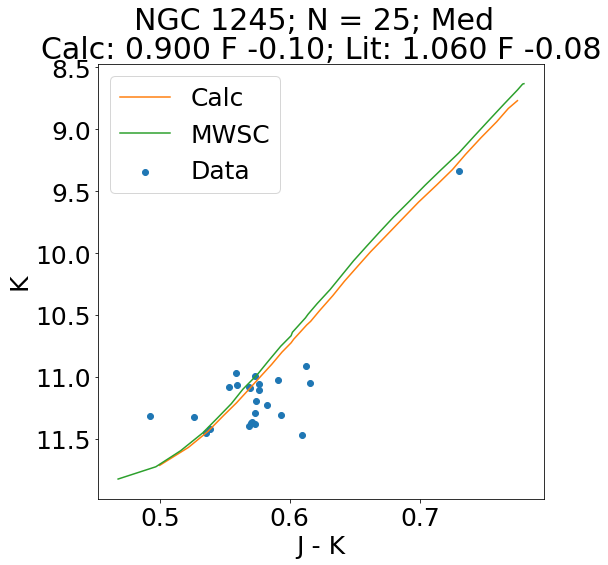

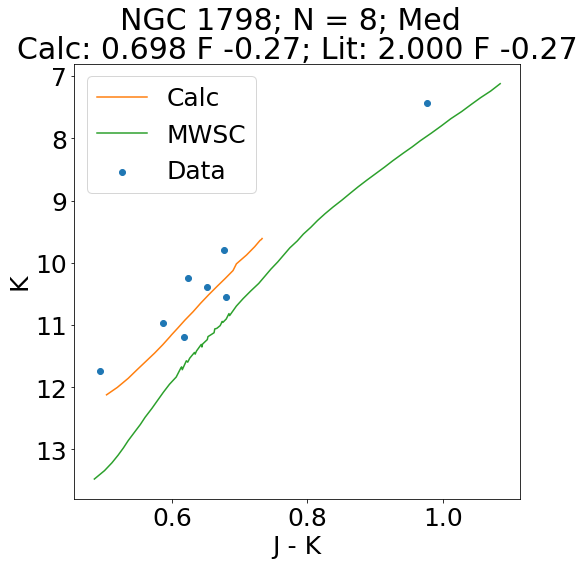

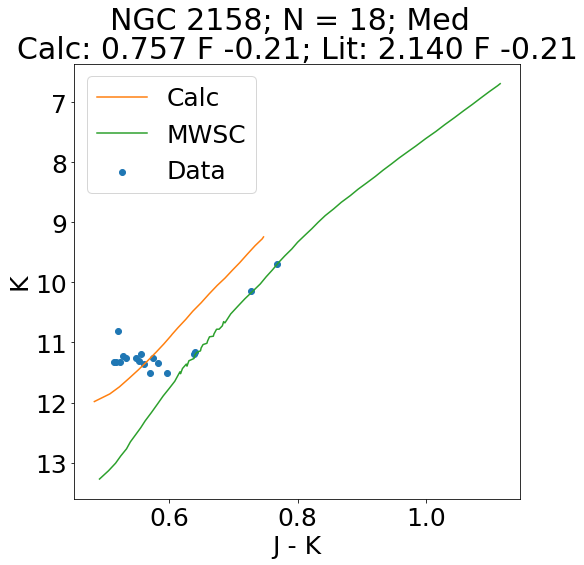

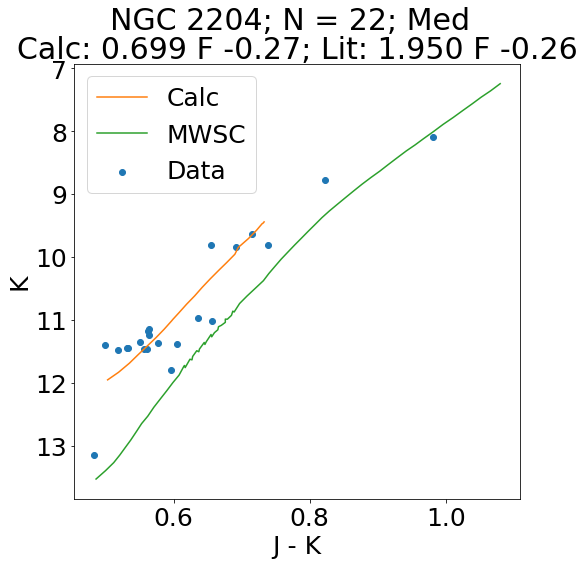

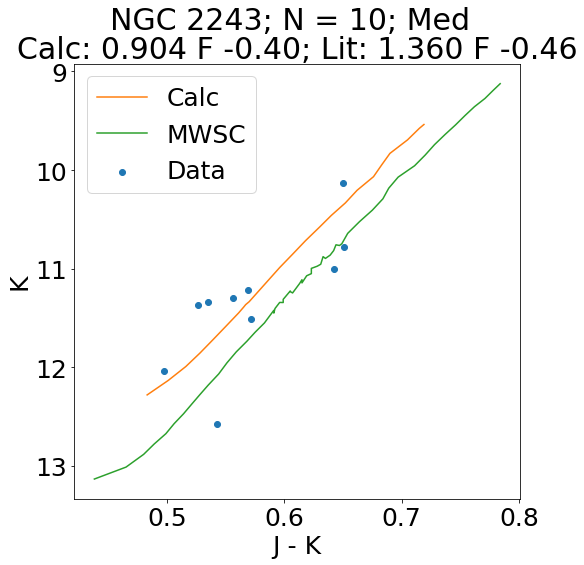

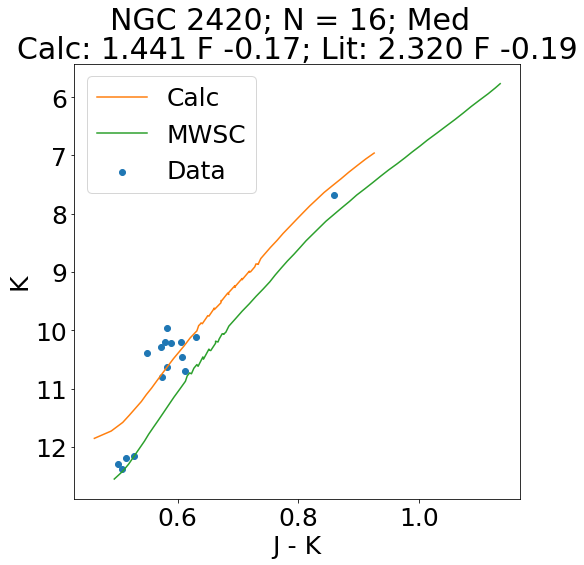

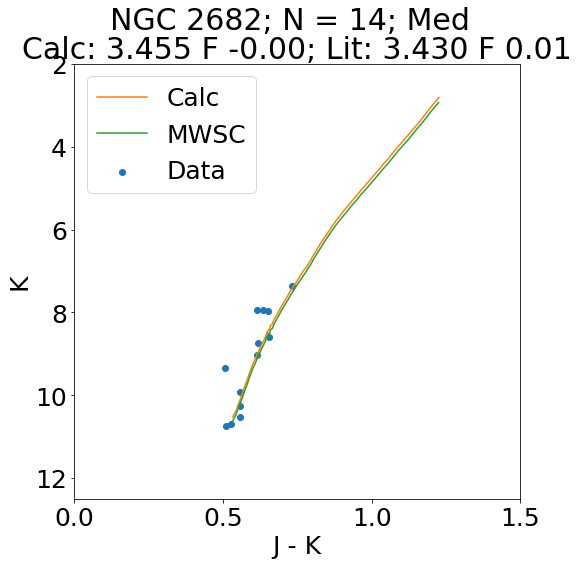

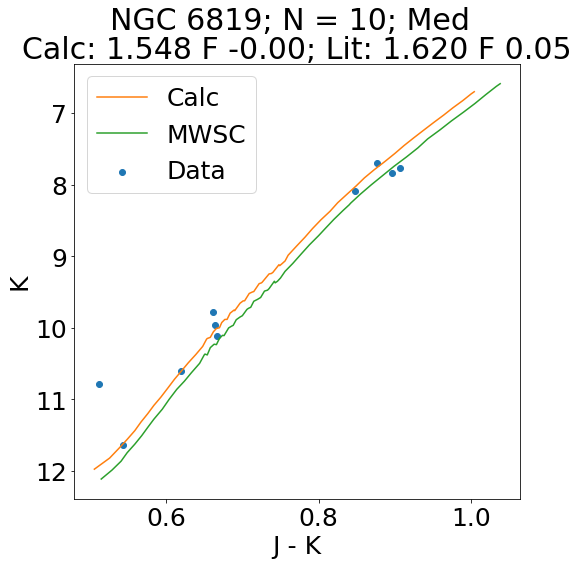

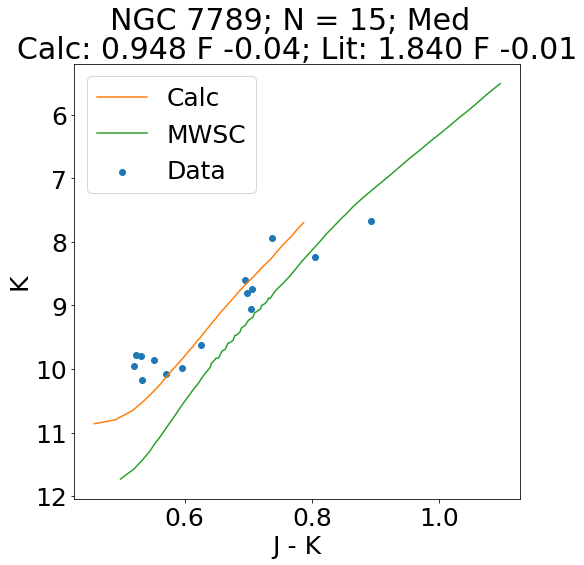

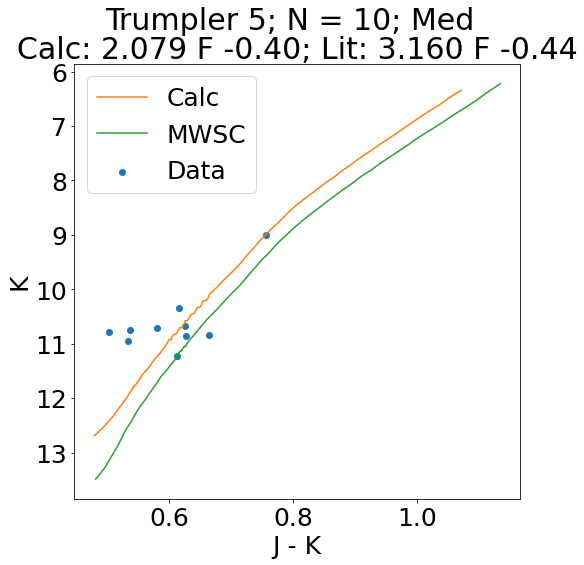

In [240]:
for i in tqdm_notebook(range(len(oclabs))):
    clus = np.where(ocmemdr17['CLUSTER']==(oclabs.replace('_',' '))[i])
    med_calc_age = np.nanmedian(agetab['AGE'][clus])
    med_salfeh = np.nanmedian((occamdr17['FE_H']+np.log10(0.655*10**apoafe+0.345))[clus])
    
    lit_age = octab5['Age'][i]
    lit_feh = octab5['FEH'][i]
    
    distmod = 5*np.log10(np.nanmedian(1/occamdr17['GAIAEDR3_PARALLAX'][clus])*1000)-5.
    simdistmod = 5*np.log10(simbadoc5[i]*1000)-5.

    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(med_calc_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],med_salfeh)))]
    
    iso_calc = iso_calc[np.argsort(iso_calc['logTe'])] 
    
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(lit_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],lit_feh)))]
    
    iso_mwsc = iso_mwsc[np.argsort(iso_mwsc['logTe'])]
    
    plt.figure(figsize=[8,8])
    plt.scatter((occamdr17['J']-occamdr17['K'])[clus]-np.nanmedian(ejk_ak*agetab['AK'][clus]),
                occamdr17['K'][clus]-np.nanmedian(agetab['AK'][clus]),label='Data')
    
    plt.plot(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+distmod,label='Calc',c='tab:orange')
    plt.plot(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+simdistmod,label='MWSC',c='tab:green')
    
    plt.legend()
    
    if oclabs[i] == 'NGC_2682':
        plt.xlim(0,1.5)
        plt.ylim(2,12.5)
    
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}; Med'.format(oclabs.replace('_',' ')[i],np.size(np.squeeze(clus))))
    plt.title(r'Calc: {:.3f} F {:.2f}; Lit: {:.3f} F {:.2f}'.format(med_calc_age,med_salfeh,lit_age,lit_feh))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

<ipython-input-251-03da8be9222a>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(oclabs))):


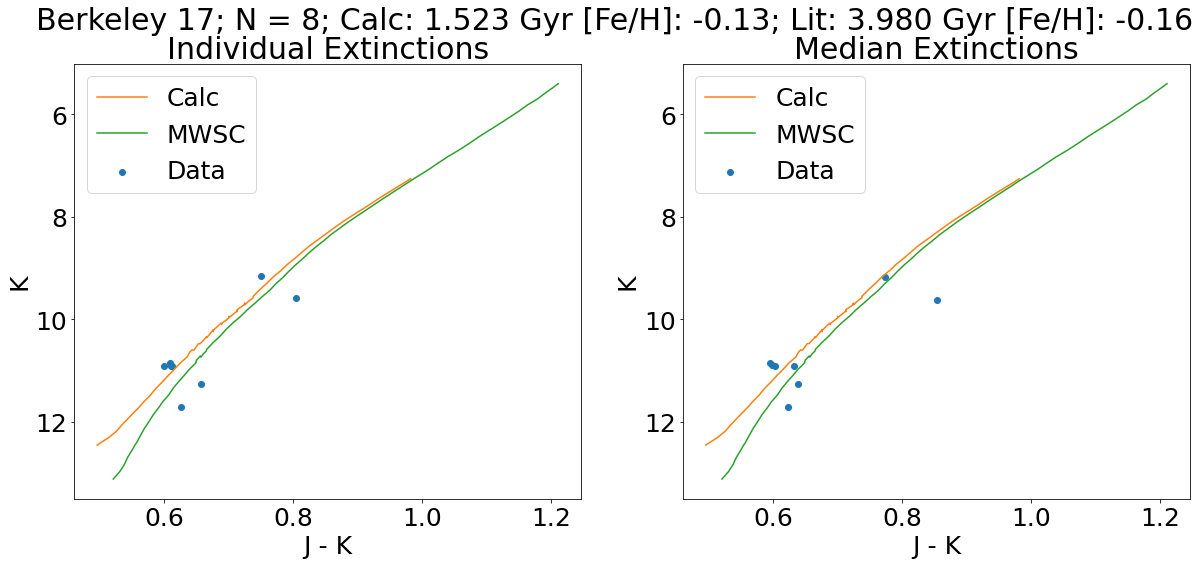

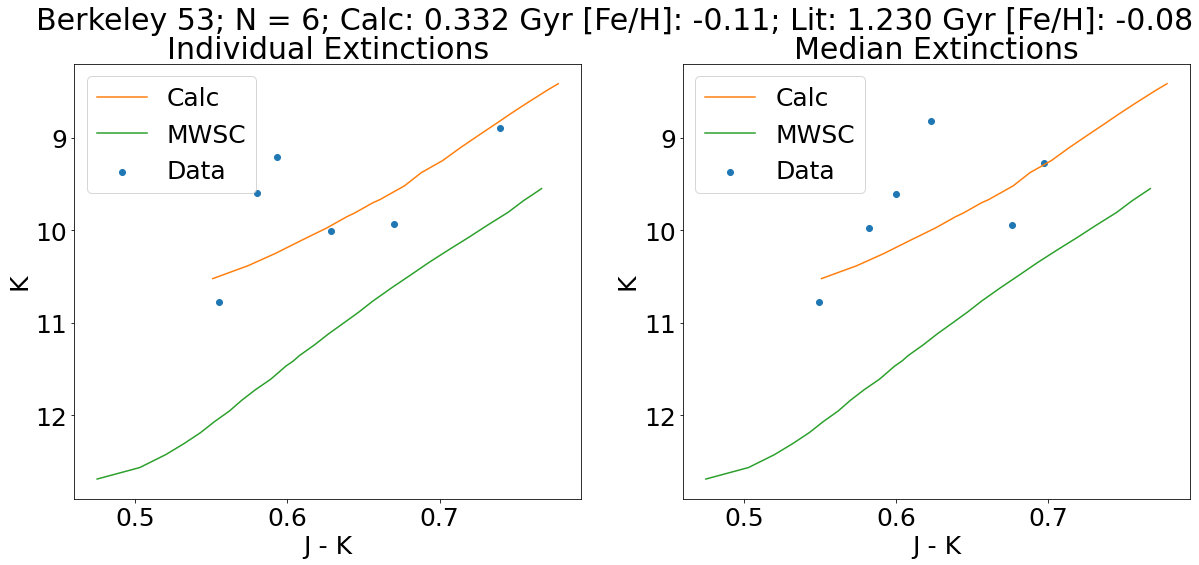

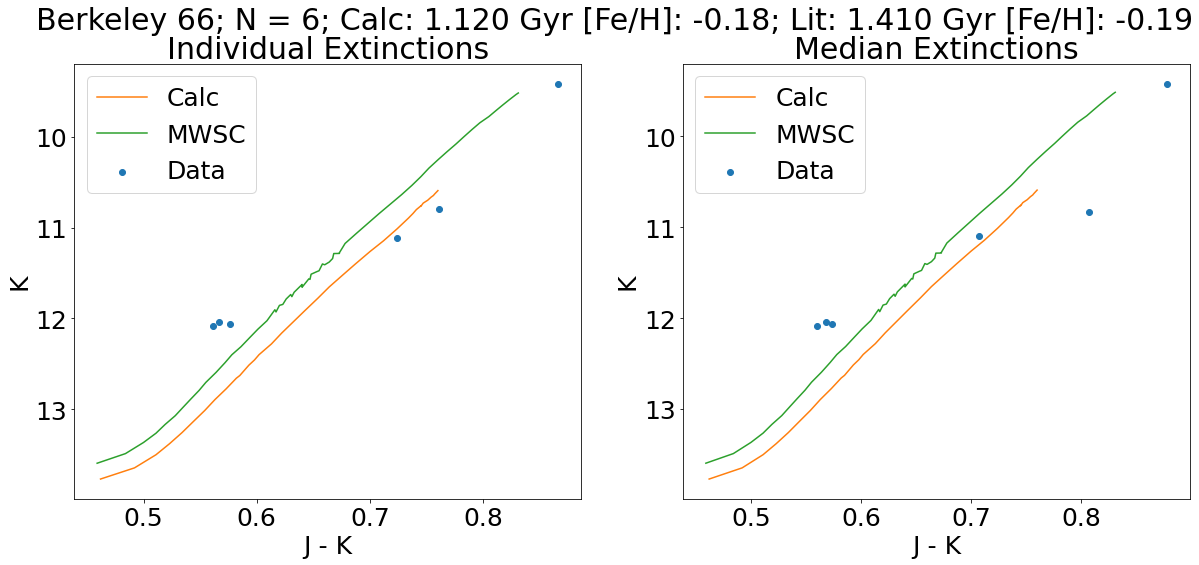

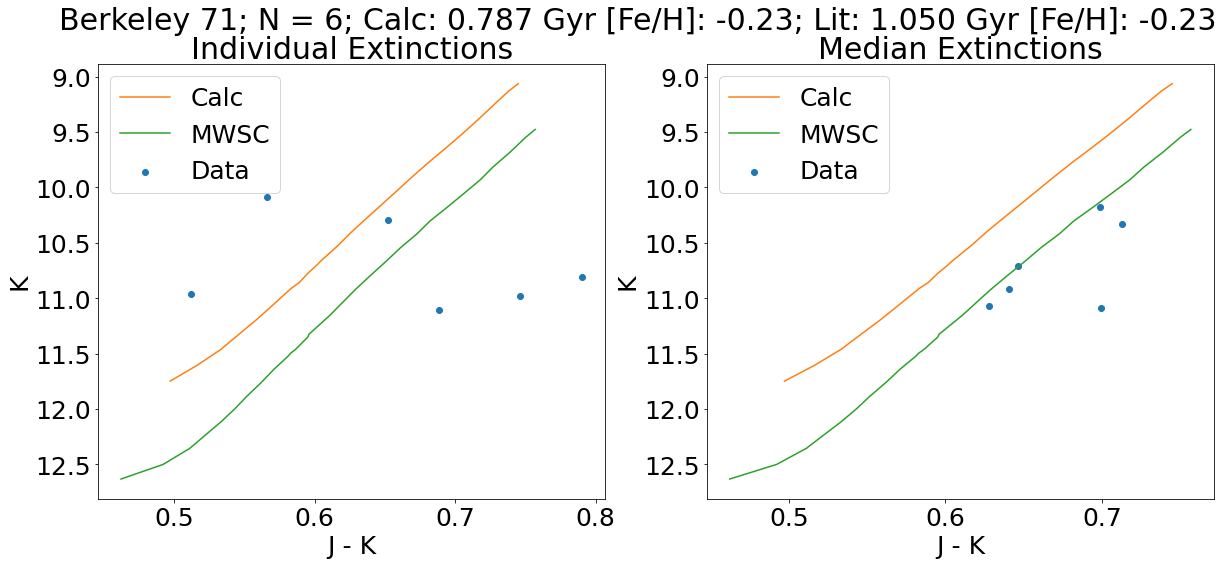

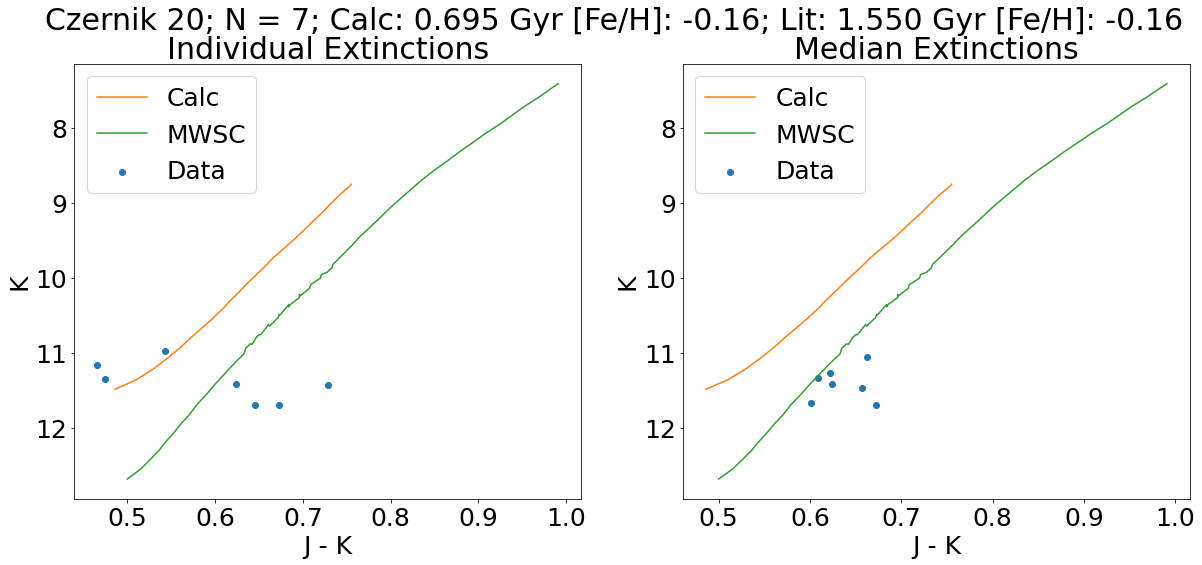

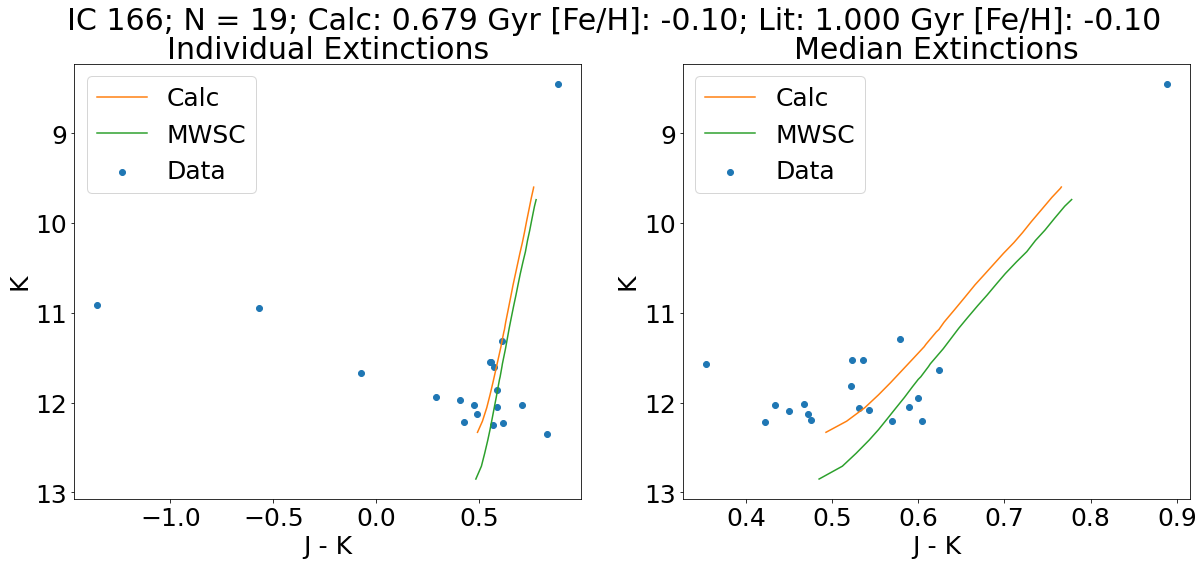

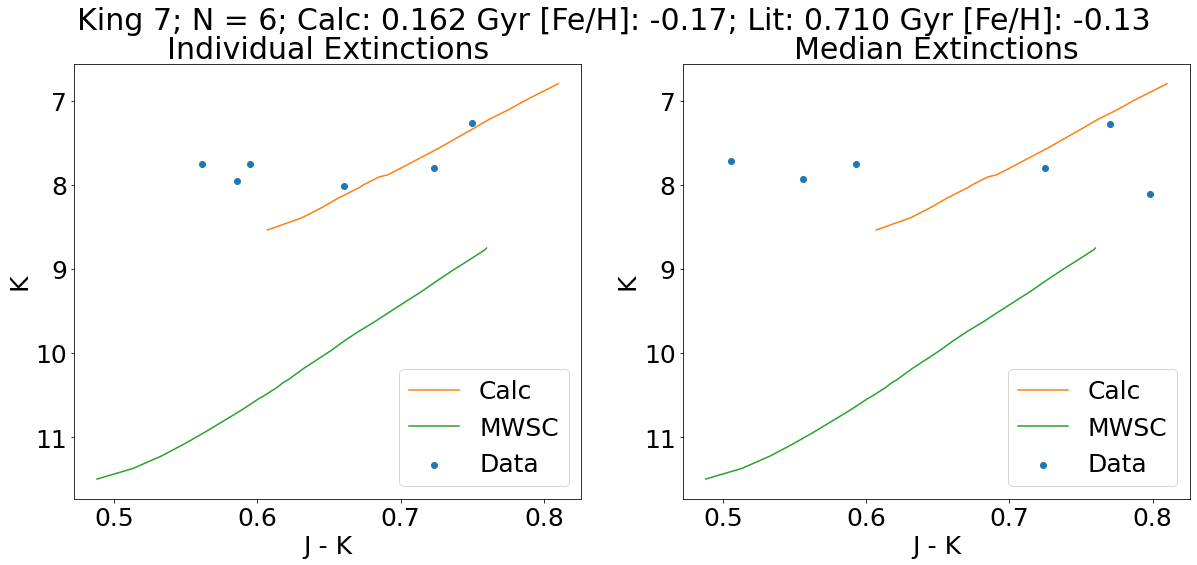

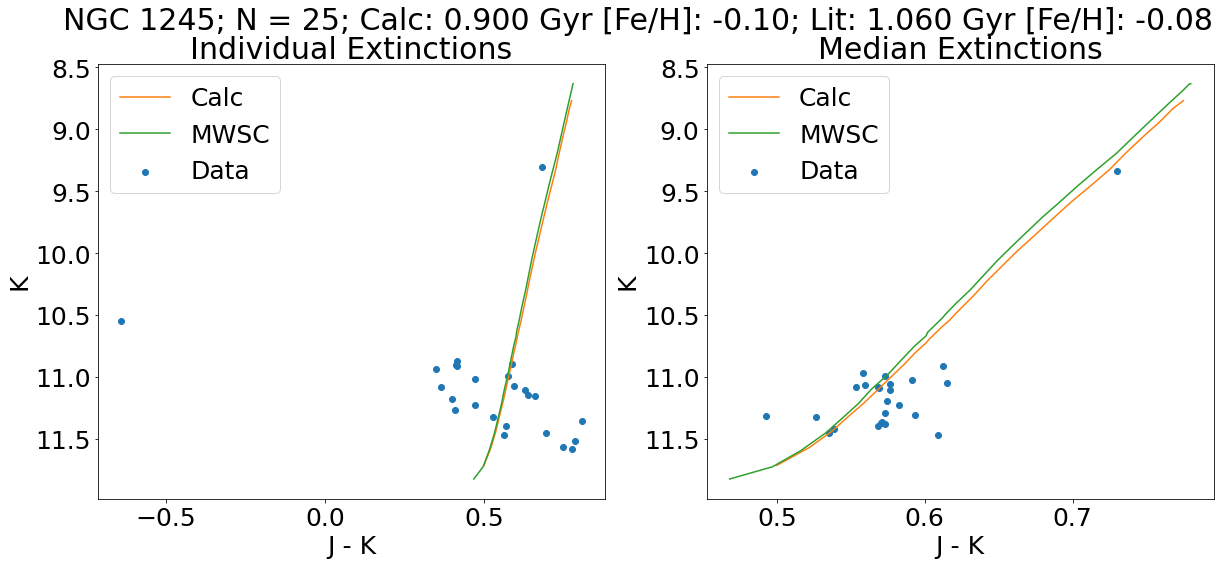

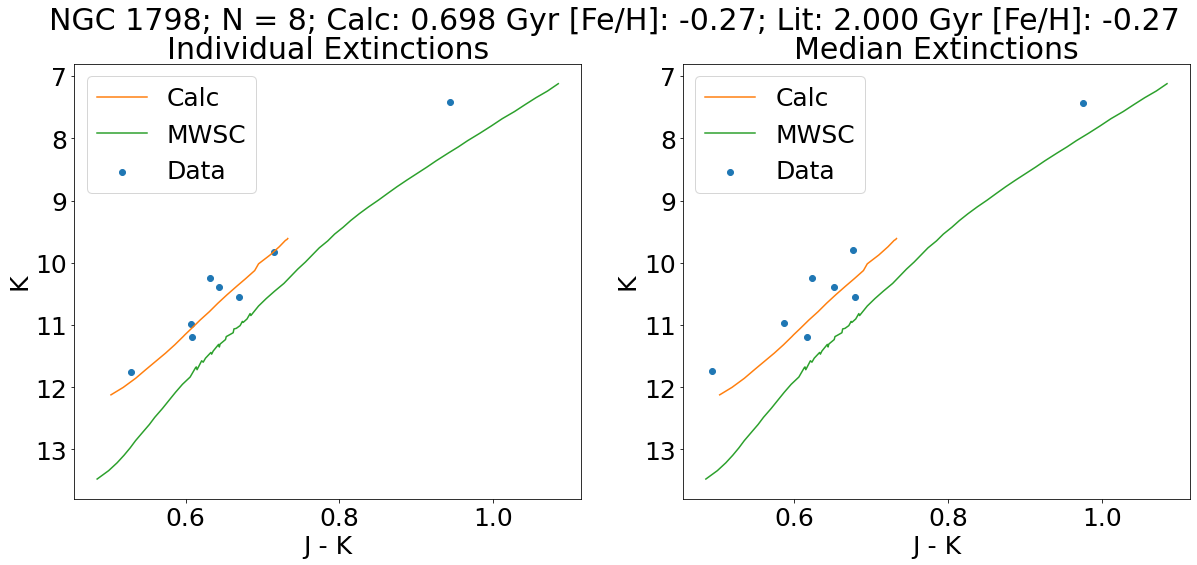

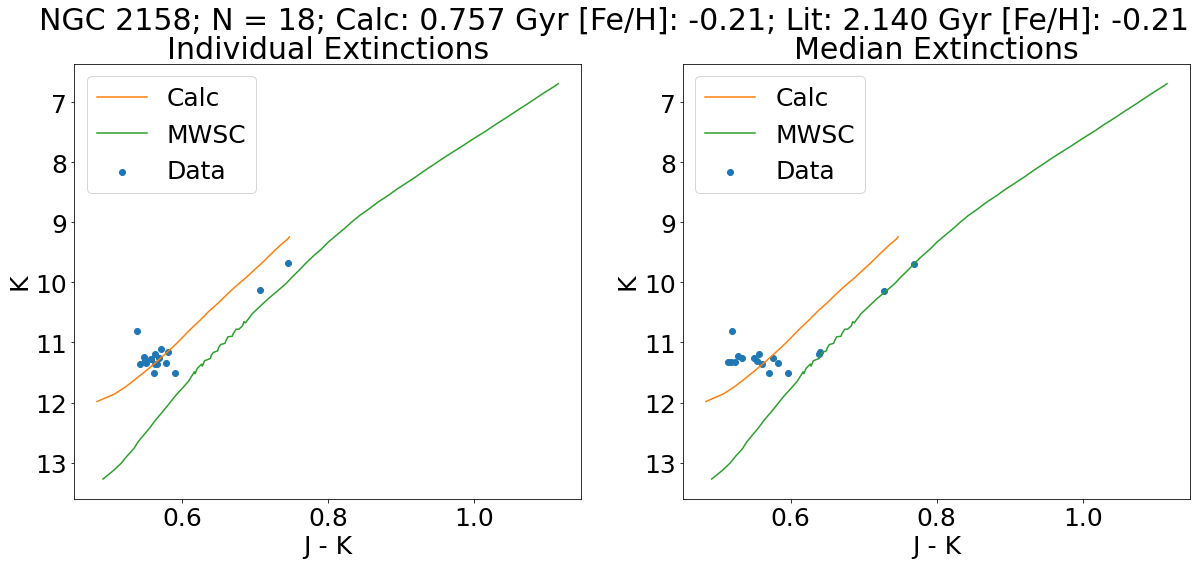

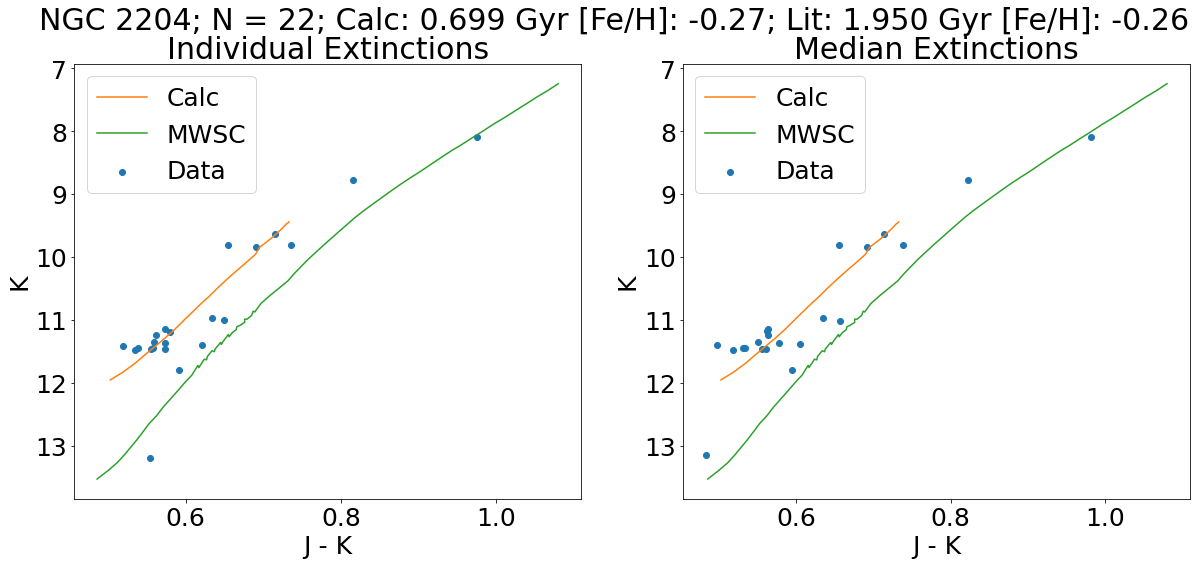

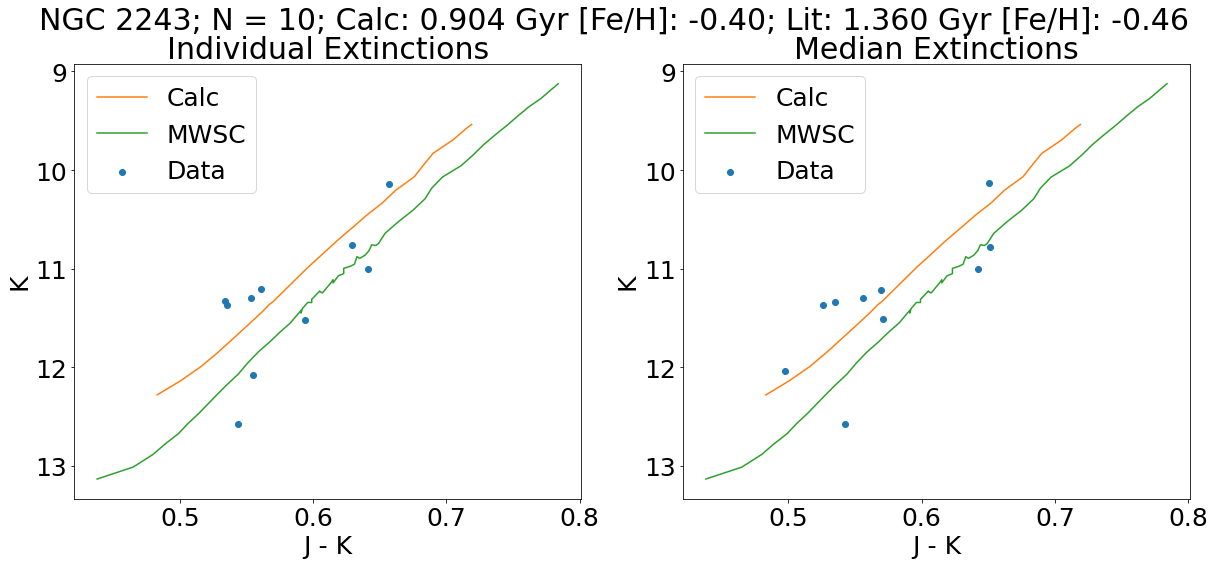

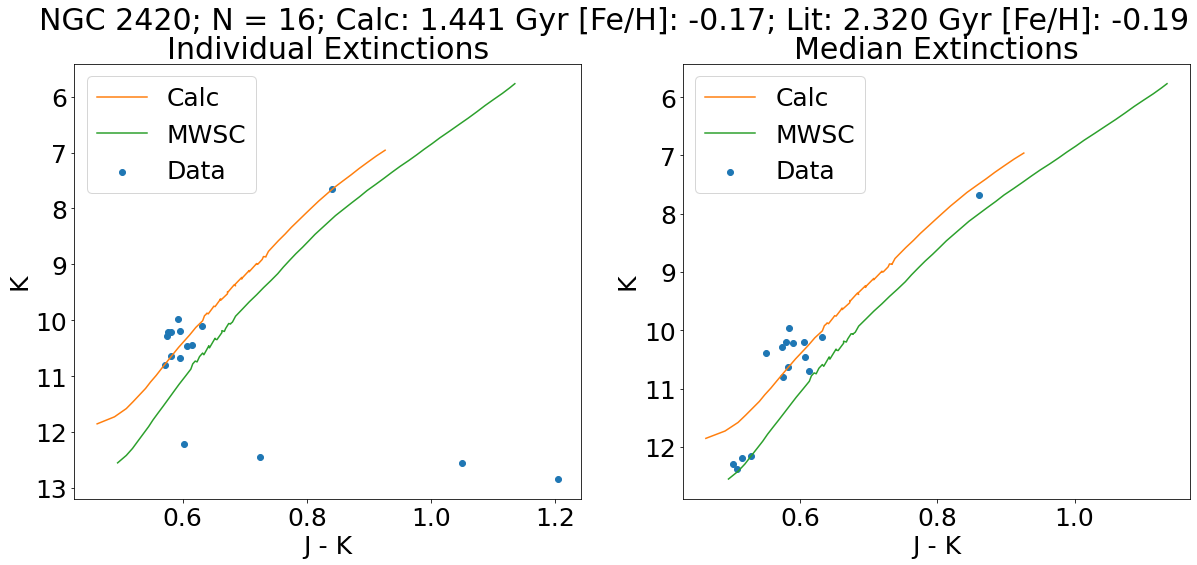

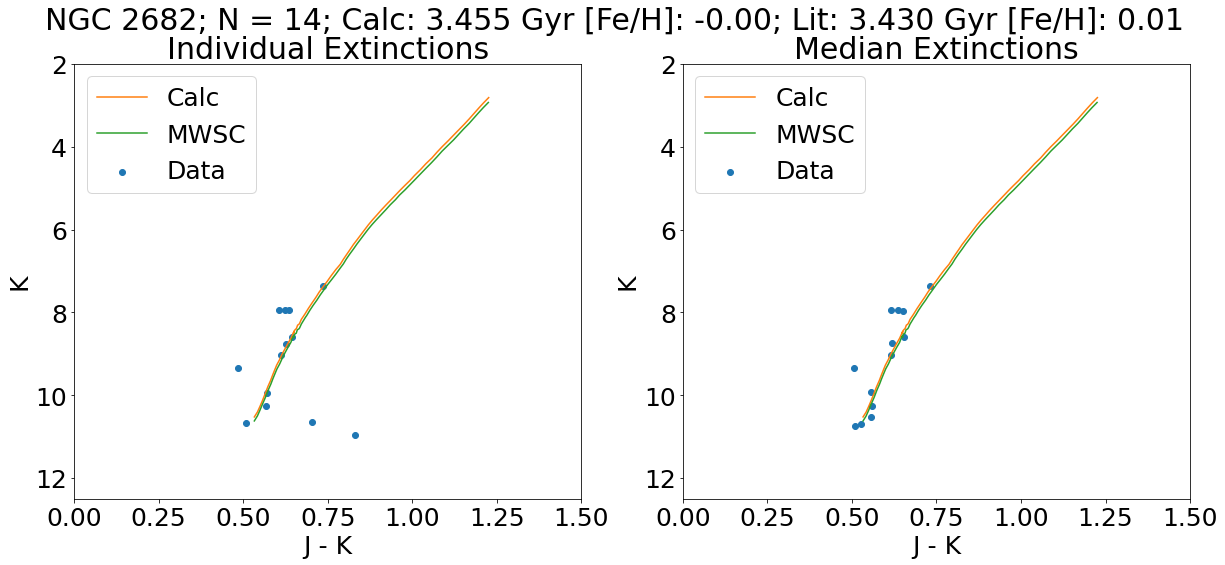

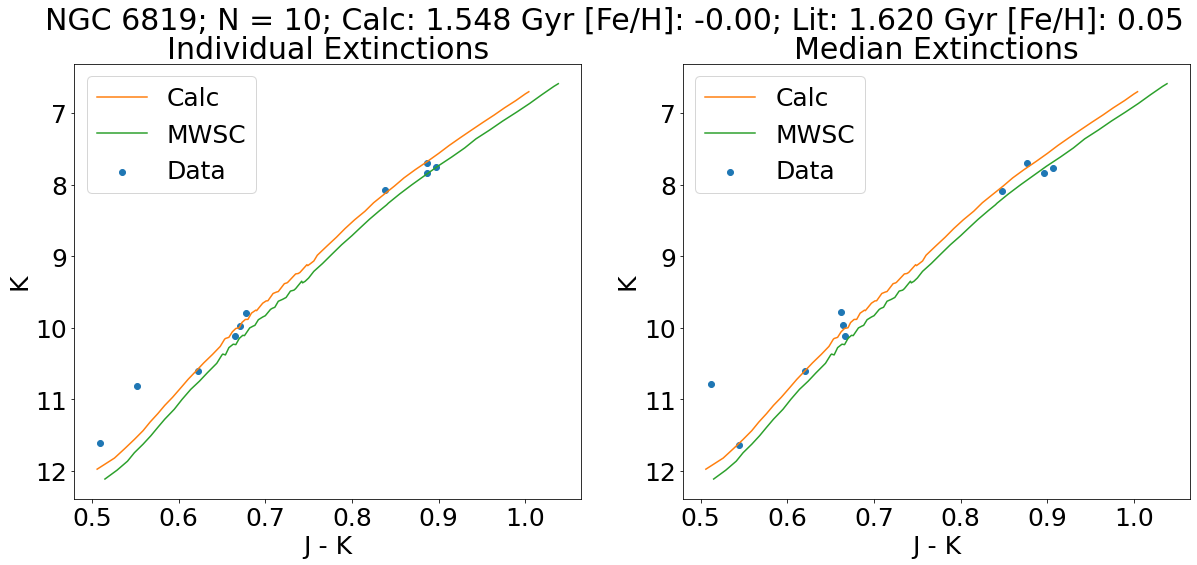

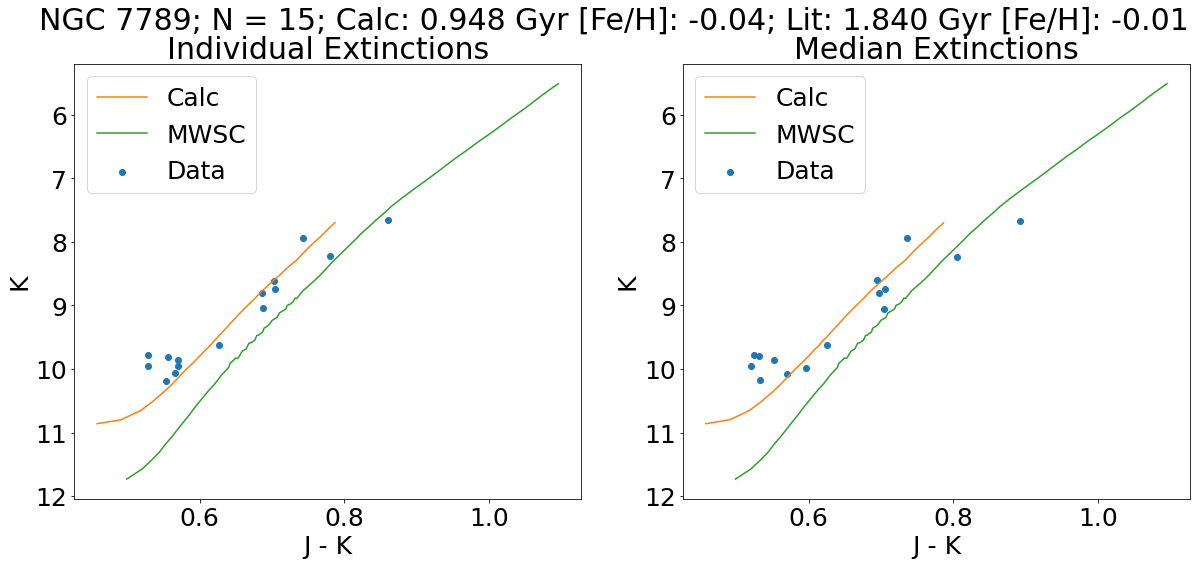

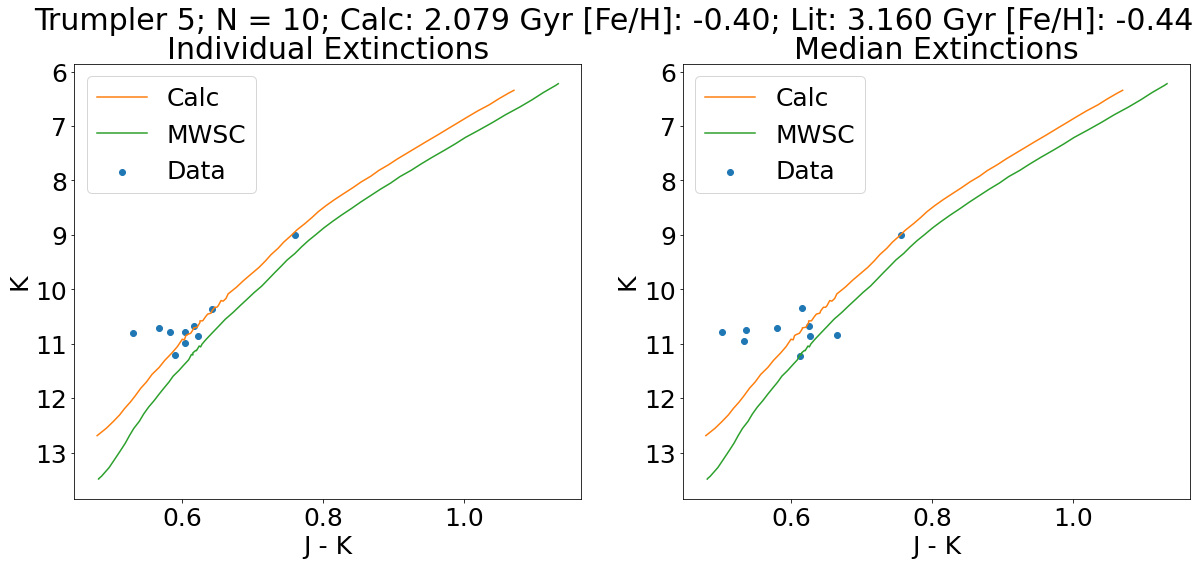

In [251]:
for i in tqdm_notebook(range(len(oclabs))):
    clus = np.where(ocmemdr17['CLUSTER']==(oclabs.replace('_',' '))[i])
    med_calc_age = np.nanmedian(agetab['AGE'][clus])
    med_salfeh = np.nanmedian((occamdr17['FE_H']+np.log10(0.655*10**apoafe+0.345))[clus])
    
    lit_age = octab5['Age'][i]
    lit_feh = octab5['FEH'][i]
    
    distmod = 5*np.log10(np.nanmedian(1/occamdr17['GAIAEDR3_PARALLAX'][clus])*1000)-5.
    simdistmod = 5*np.log10(simbadoc5[i]*1000)-5.

    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(med_calc_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],med_salfeh)))]
    
    iso_calc = iso_calc[np.argsort(iso_calc['logTe'])] 
    
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(lit_age*10**9)))&
                        (massive['MH']==closest(massive['MH'],lit_feh)))]
    
    iso_mwsc = iso_mwsc[np.argsort(iso_mwsc['logTe'])]
    
    plt.figure(figsize=[20,8])
    
    plt.suptitle(r'{}; N = {}; Calc: {:.3f} Gyr [Fe/H]: {:.2f}; Lit: {:.3f} Gyr [Fe/H]: {:.2f}'.format(oclabs.replace('_',' ')[i],
                                                                                  np.size(np.squeeze(clus)),
                                                                                  med_calc_age,med_salfeh,lit_age,
                                                                                  lit_feh))
    
    plt.subplot(121)
    plt.scatter((occamdr17['J']-occamdr17['K']-ejk_ak*agetab['AK'])[clus],
                (occamdr17['K']-agetab['AK'])[clus],label='Data')
    
    plt.plot(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+distmod,label='Calc',c='tab:orange')
    plt.plot(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+simdistmod,label='MWSC',c='tab:green')
    
    plt.legend()
    
    if oclabs[i] == 'NGC_2682':
        plt.xlim(0,1.5)
        plt.ylim(2,12.5)
    
    plt.gca().invert_yaxis()
    plt.title(r'Individual Extinctions')
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.subplot(122)
    plt.scatter((occamdr17['J']-occamdr17['K'])[clus]-np.nanmedian(ejk_ak*agetab['AK'][clus]),
                occamdr17['K'][clus]-np.nanmedian(agetab['AK'][clus]),label='Data')
    
    plt.plot(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+distmod,label='Calc',c='tab:orange')
    plt.plot(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+simdistmod,label='MWSC',c='tab:green')
    
    plt.legend()
    
    if oclabs[i] == 'NGC_2682':
        plt.xlim(0,1.5)
        plt.ylim(2,12.5)
    
    plt.gca().invert_yaxis()
    plt.title(r'Median Extinctions')
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    
    plt.savefig('../plots/oc2mass_sidebyside_{}.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()

<ipython-input-120-ce2b0f205ef6>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):


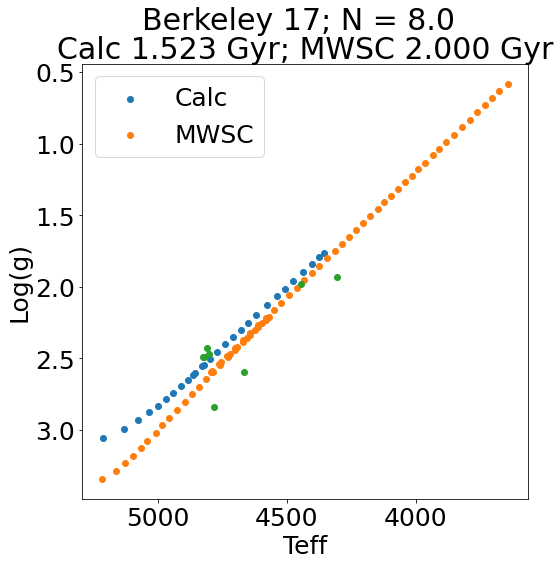

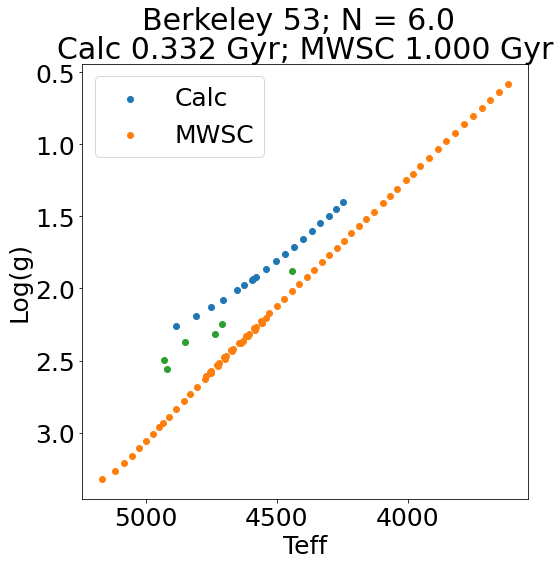

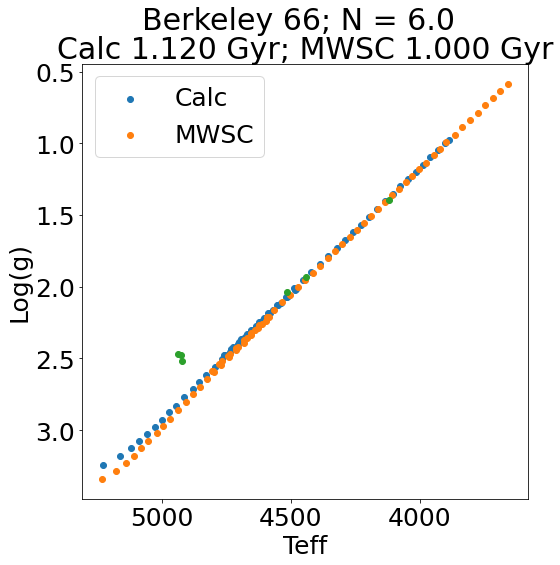

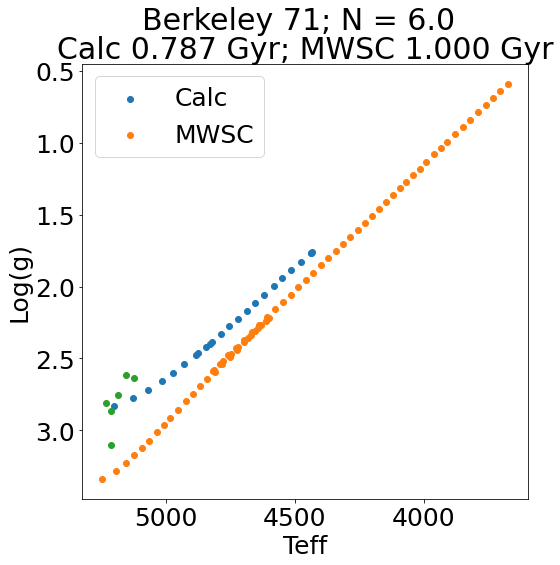

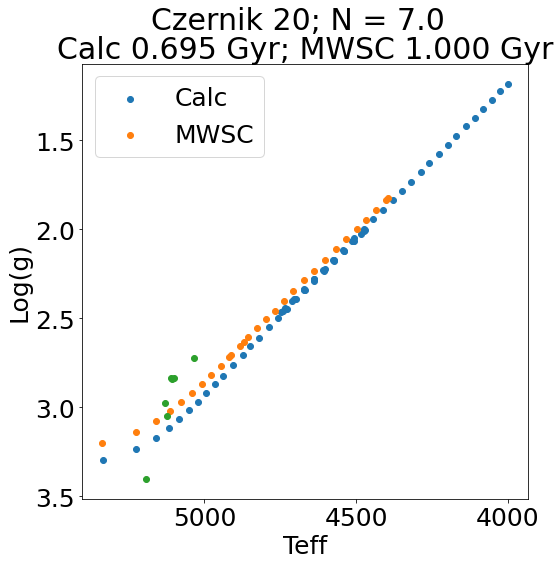

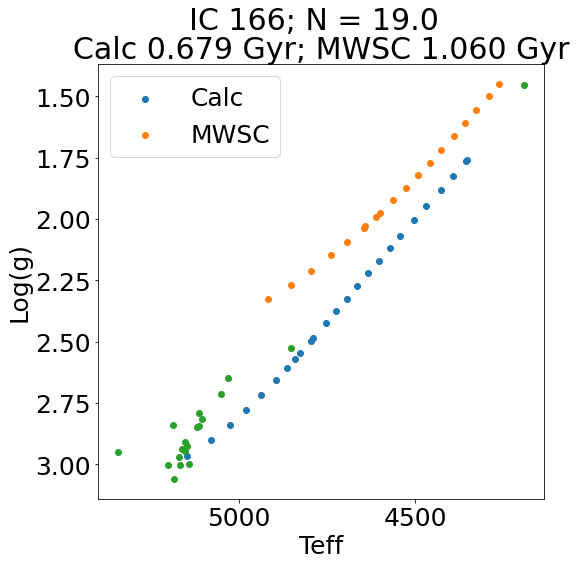

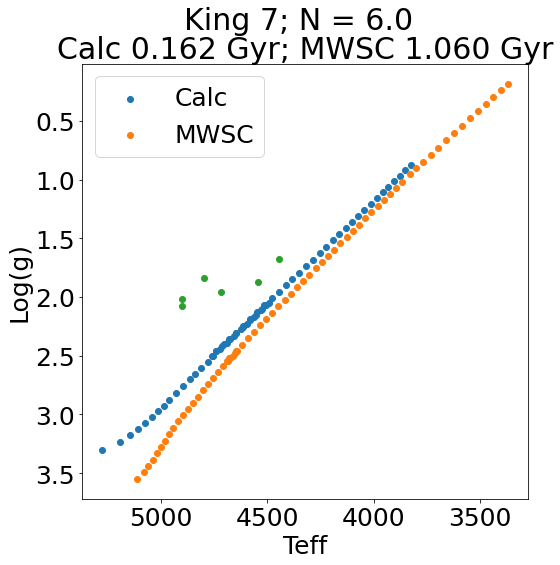

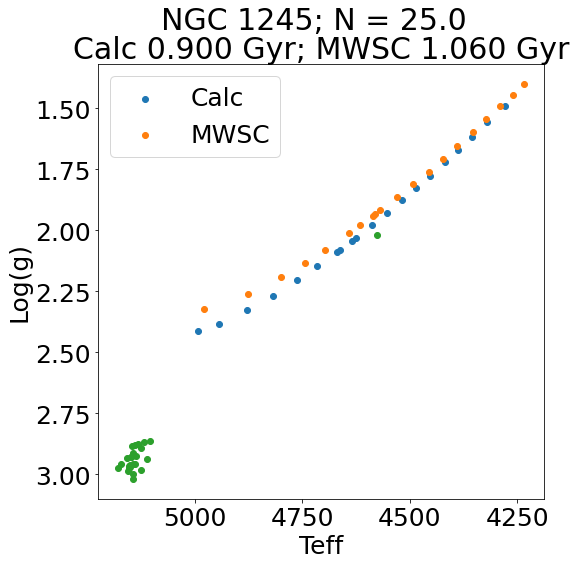

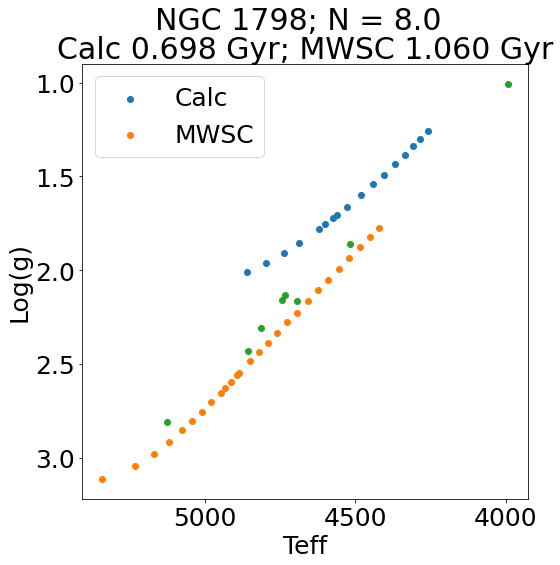

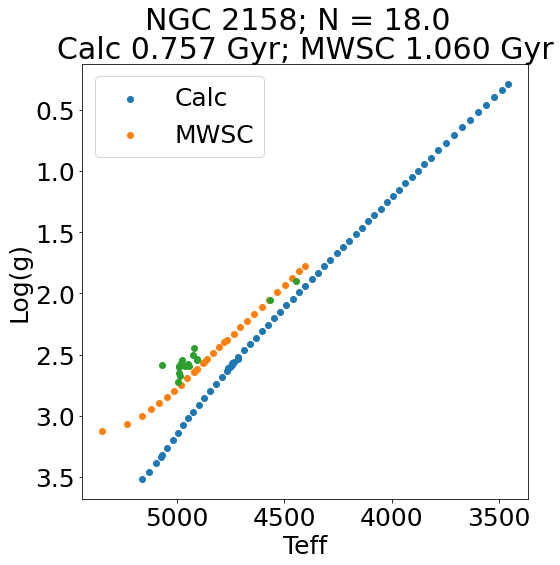

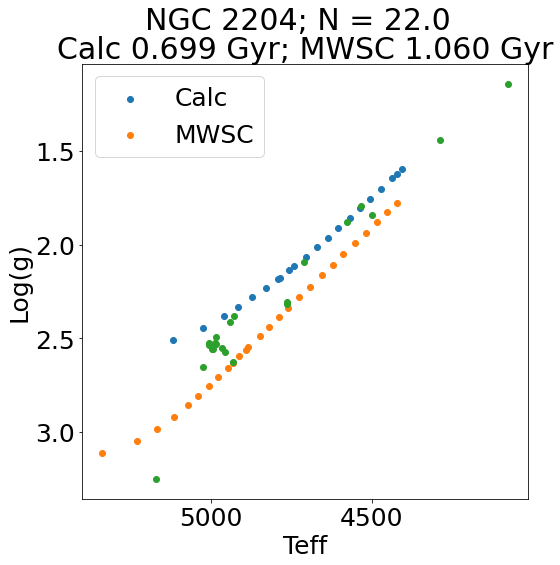

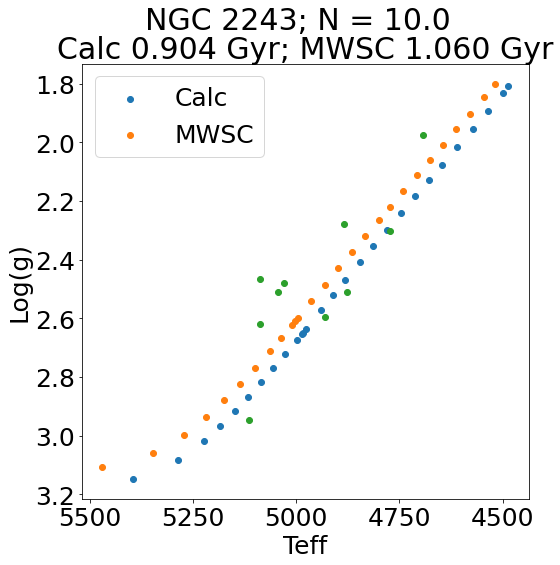

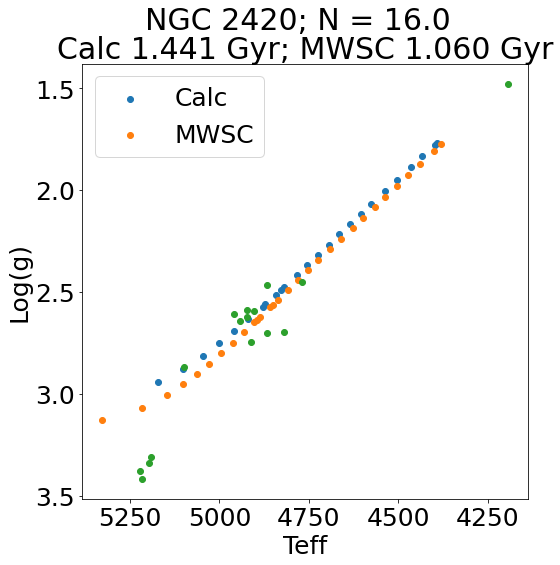

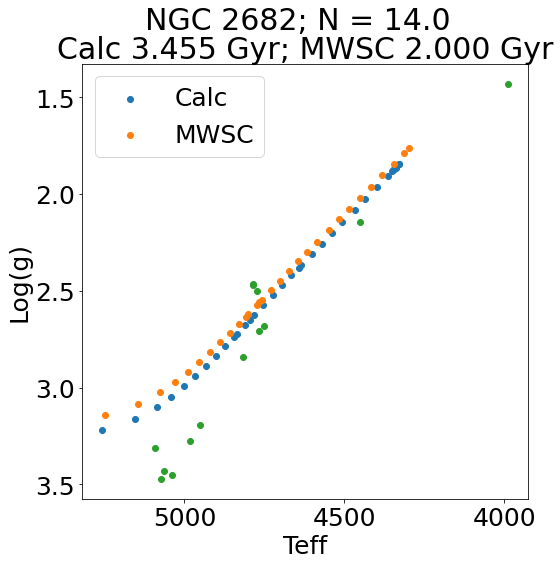

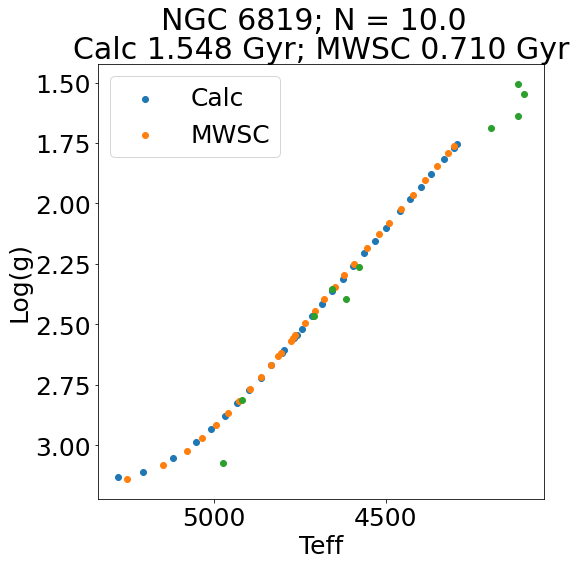

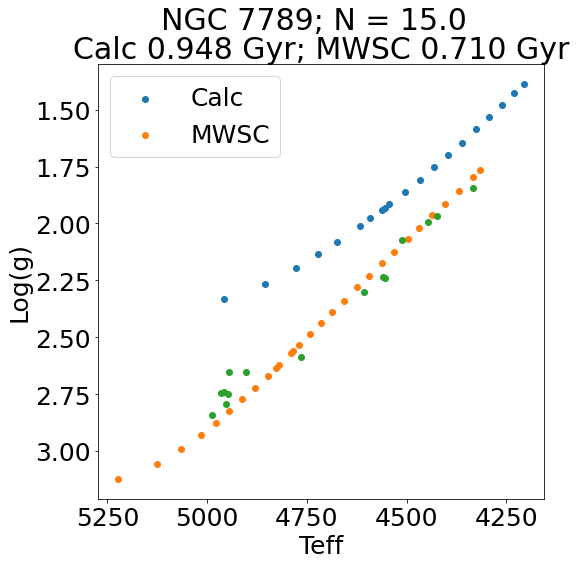

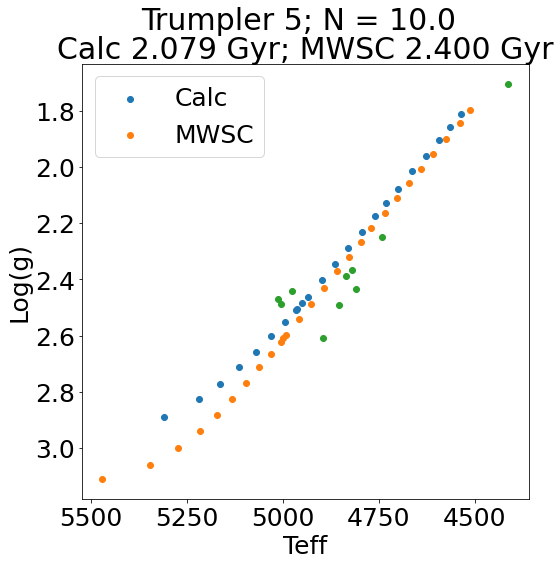

In [120]:
salfeh = occamdr17['FE_H']+np.log10(0.655*10**apoafe+0.345)

for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i])
    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(calc_age[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(salfeh[clus]))))]
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(litages[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(occamdr17['FE_H'][clus]))))]
    
    plt.figure(figsize=[8,8])
    plt.scatter(10**iso_calc['logTe'],iso_calc['logg'],label='Calc')
    plt.scatter(10**iso_mwsc['logTe'],iso_mwsc['logg'],label='MWSC')
    plt.legend()
    plt.scatter(occamdr17['TEFF'][clus],occamdr17['LOGG'][clus])
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i],
                              calc_n[np.where(calc_n>5)][i]))
    plt.title(r'Calc {:.3f} Gyr; MWSC {:.3f} Gyr'.format(calc_age[np.where(calc_n>5)][i],
                                                         litages[np.where(calc_n>5)][i]))
    plt.xlabel(r'Teff')
    plt.ylabel(r'Log(g)')
    plt.savefig('../plots/occam_hr_{}.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()

In [121]:
ejk_ak

1.4901972382364816

<ipython-input-122-d2bb63896fe2>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):


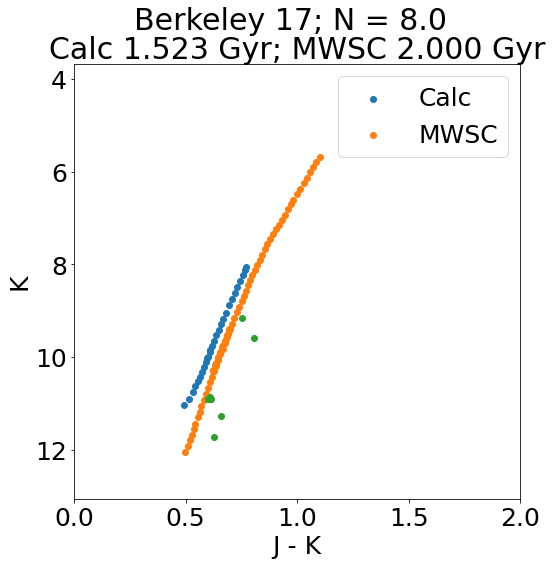

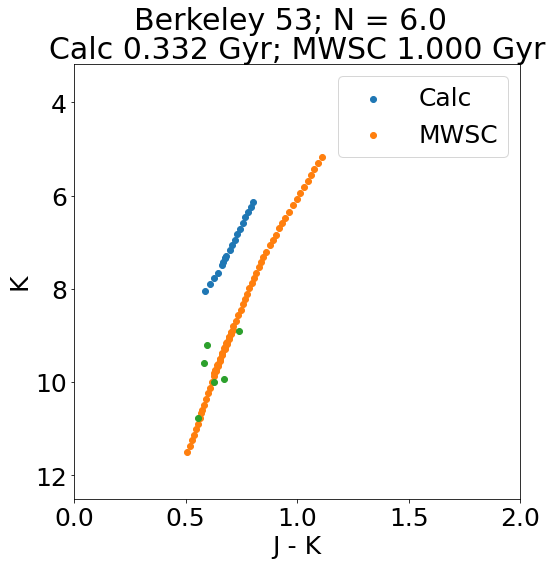

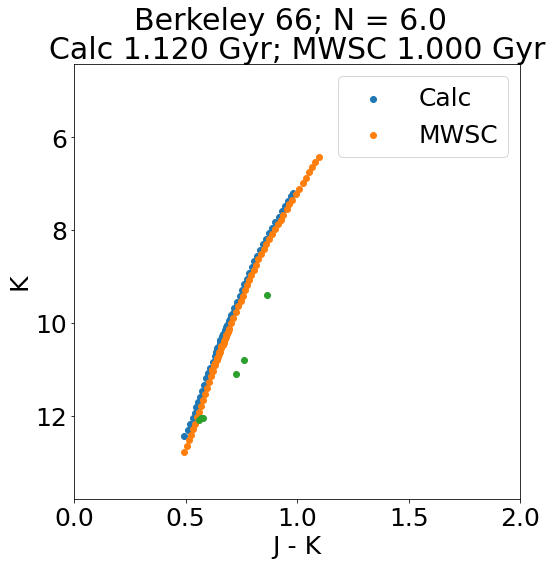

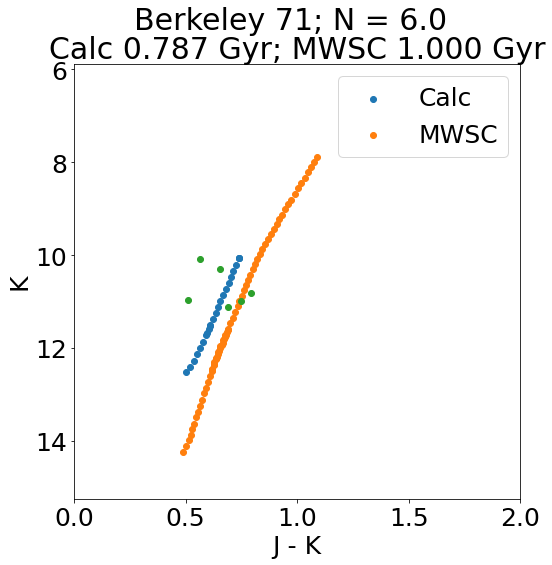

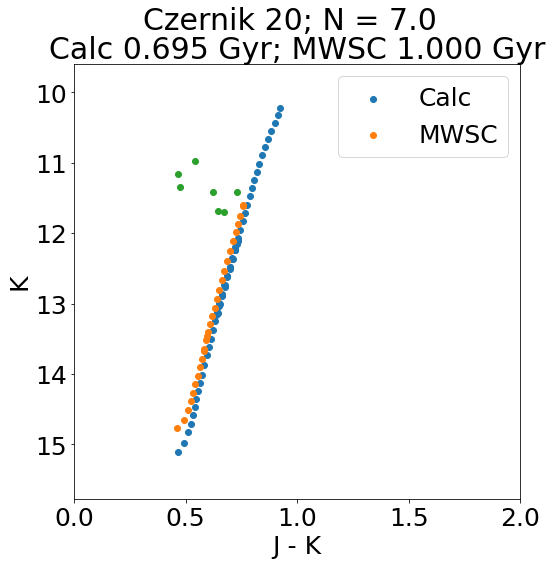

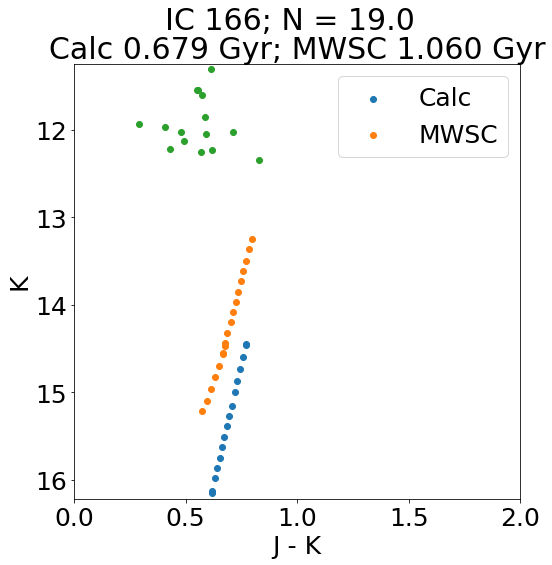

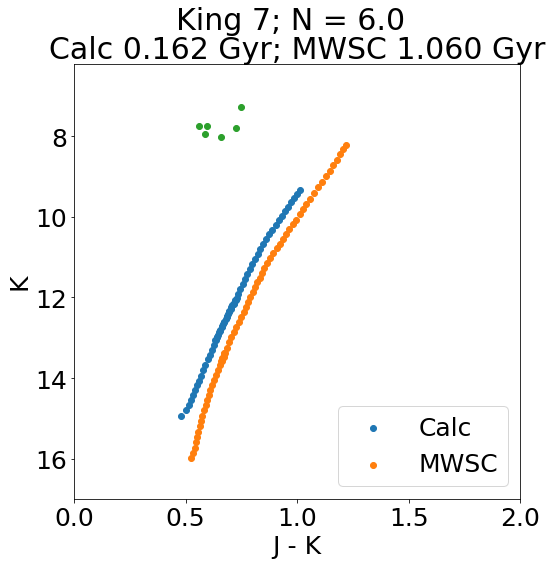

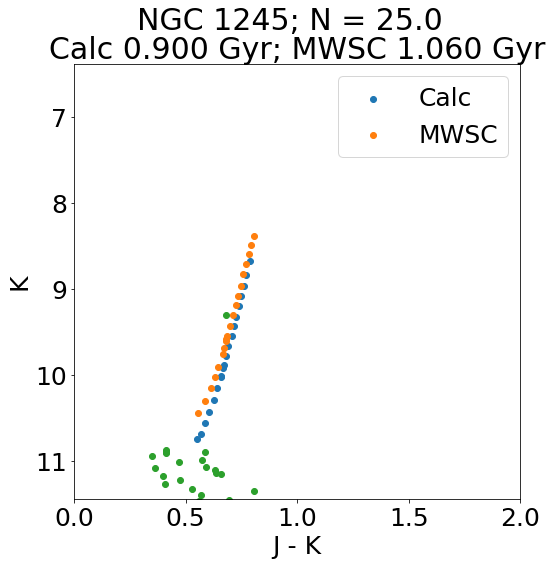

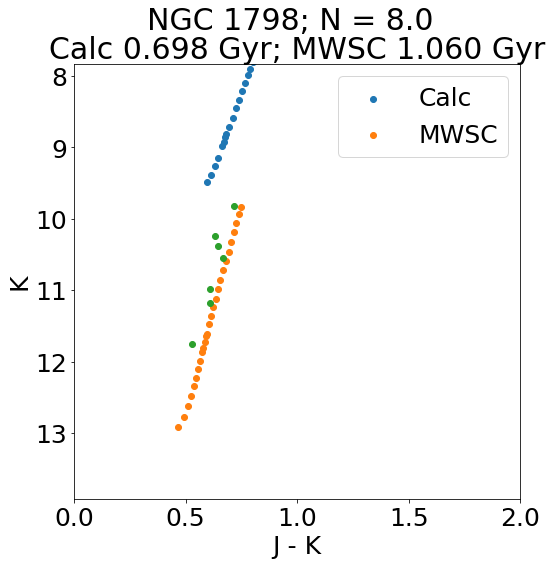

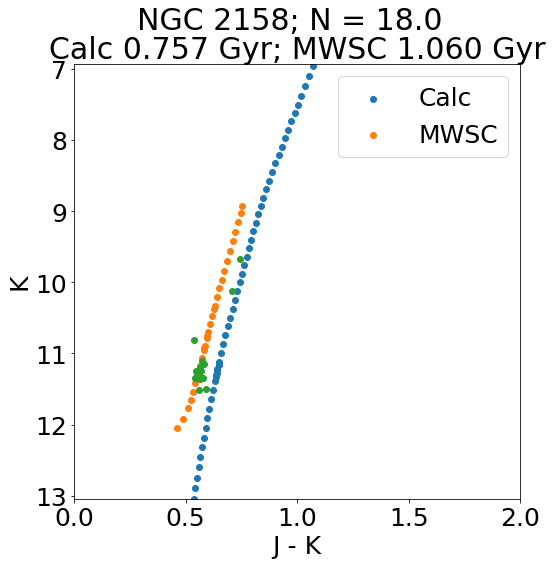

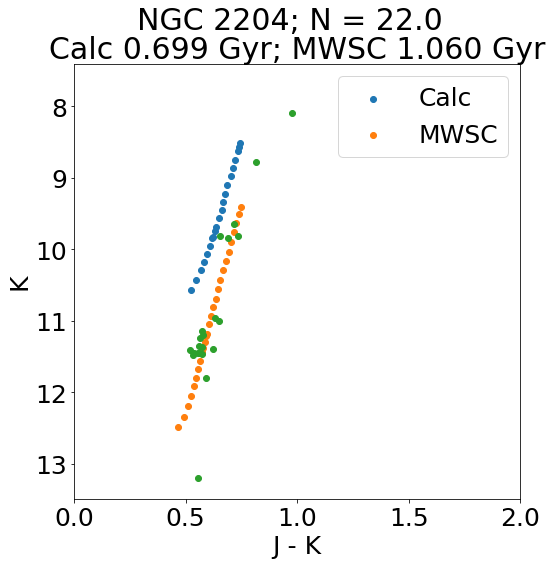

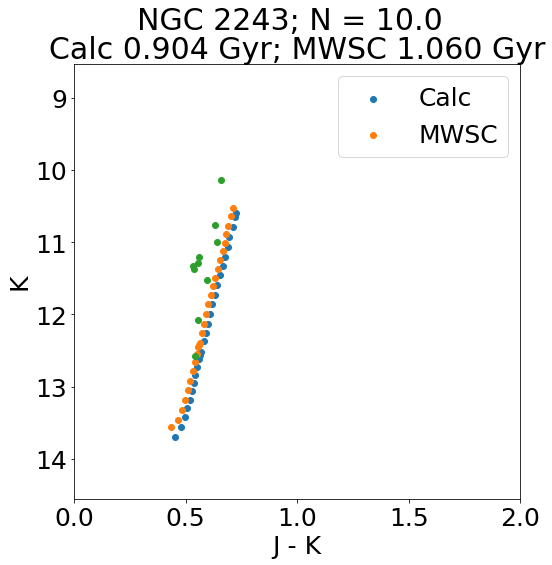

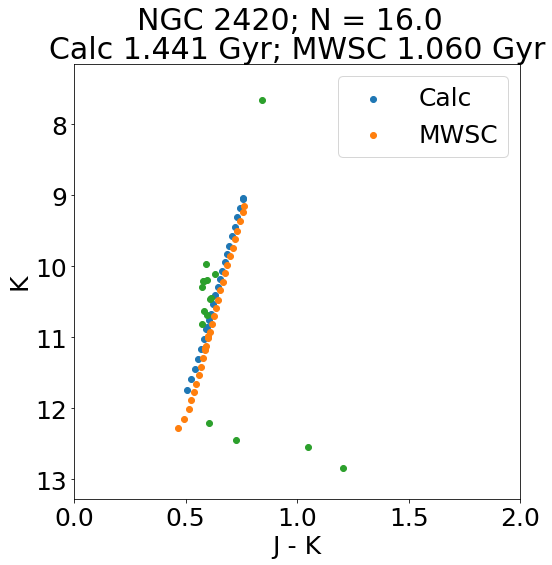

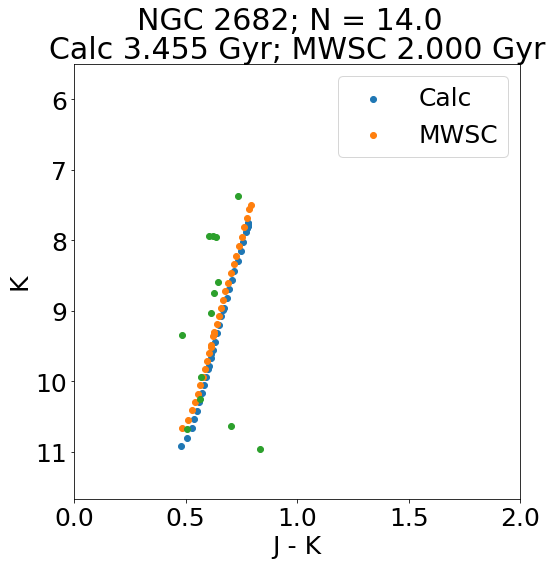

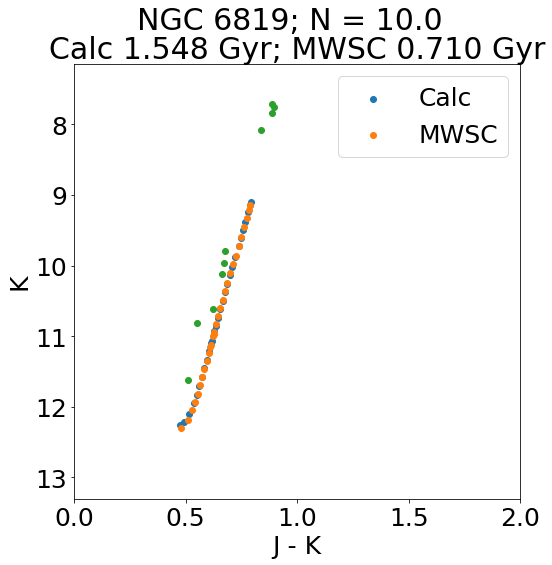

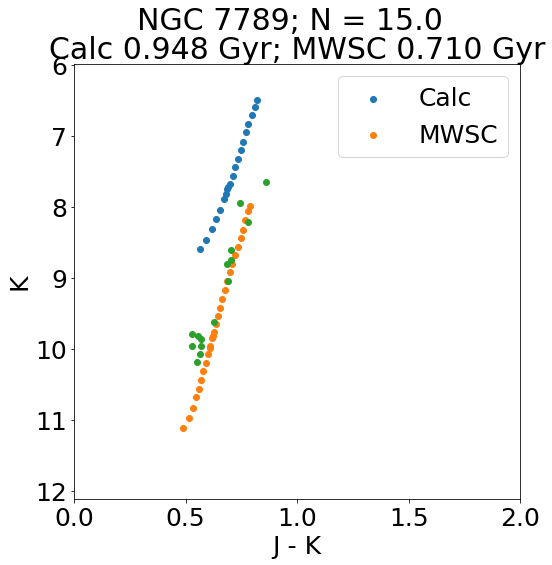

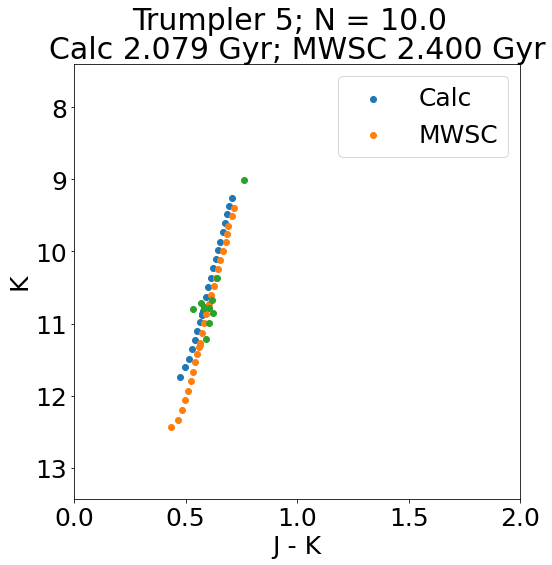

In [122]:
for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i])
    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(calc_age[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(salfeh[clus]))))]
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(litages[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(occamdr17['FE_H'][clus]))))]
    
    plt.figure(figsize=[8,8])
    plt.scatter(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+calc_dist[i],label='Calc')
    plt.scatter(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+calc_dist[i],label='MWSC')
    plt.legend()
    plt.scatter((occamdr17['J']-occamdr17['K']-ejk_ak*agetab['AK'])[clus],(occamdr17['K']-agetab['AK'])[clus])
    plt.xlim(0,2)
    plt.ylim(min(iso_mwsc['Ksmag']+calc_dist[i])-2,1+max(iso_mwsc['Ksmag']+calc_dist[i]))
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i],
                              calc_n[np.where(calc_n>5)][i]))
    plt.title(r'Calc {:.3f} Gyr; MWSC {:.3f} Gyr'.format(calc_age[np.where(calc_n>5)][i],
                                                         litages[np.where(calc_n>5)][i]))
    plt.xlabel('J - K')
    plt.ylabel('K')
    plt.savefig('../plots/occam_2mass_{}.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()

# Literature distances

In [123]:
# plt.scatter('GLO')

In [124]:
octab1.columns

<TableColumns names=('Name','Qual','GLON','GLAT','Radius','Age','Rgc','pmRA','e_pmRA','pmDE','e_pmDE','HRV','e_HRV','FEH','e_FEH','N')>

In [125]:
import astropy.coordinates as coord
import astropy.units as u

gc = coord.SkyCoord(l=octab1['GLON']*u.degree,b=(octab1['GLAT'])*u.degree,
                    distance=octab1['Rgc']*u.kpc,frame='galactic')

radecdist = gc.transform_to('icrs').distance.value

litdist = 999999.0*np.ones(len(occamdr17))

for i in range(len(np.unique(ocmemdr17['CLUSTER']))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[i])
    
    litdist[clus] = radecdist[i]
    pardist[i] = np.nanmedian(1/occamdr17['GAIAEDR3_PARALLAX'][clus])

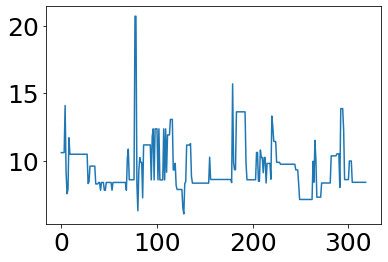

In [126]:
plt.plot(litdist)

In [127]:
octab1.columns

<TableColumns names=('Name','Qual','GLON','GLAT','Radius','Age','Rgc','pmRA','e_pmRA','pmDE','e_pmDE','HRV','e_HRV','FEH','e_FEH','N')>

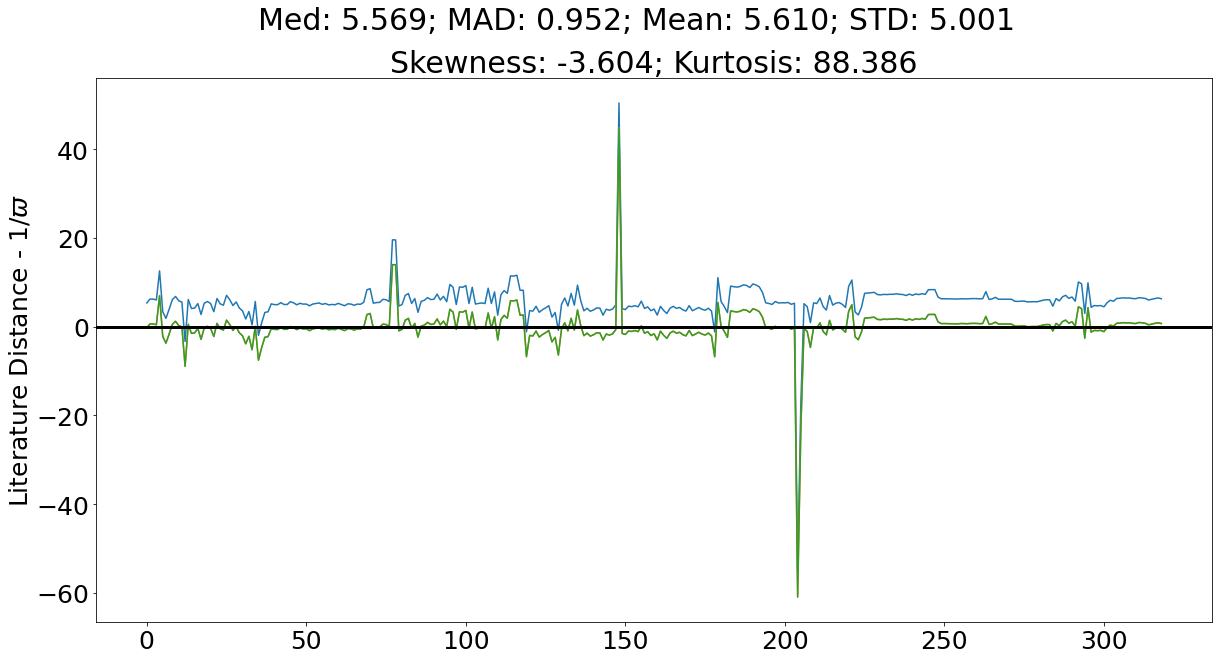

In [128]:
from scipy.stats import skew
from scipy.stats import kurtosis

dist_resid = litdist-1/occamdr17['GAIAEDR3_PARALLAX']
plt.figure(figsize=[20,10])
plt.plot(dist_resid,label='resid')
plt.plot(dist_resid-np.nanmedian(dist_resid),label='resid-median')
plt.plot(dist_resid-np.nanmean(dist_resid),label='resid-mean')
plt.axhline(0.0,c='k',lw=3.0)

plt.suptitle(r'Med: {:.3f}; MAD: {:.3f}; Mean: {:.3f}; STD: {:.3f}'.format(np.nanmedian(dist_resid),
                                                                           mad(dist_resid),np.mean(dist_resid),
                                                                           np.std(dist_resid)))
plt.title(r'Skewness: {:.3f}; Kurtosis: {:.3f}'.format(skew(dist_resid),kurtosis(dist_resid)))
plt.ylabel(r'Literature Distance - 1/$\varpi$')

plt.show()

# sub_axes = plt.axes([.45, .18, .3, .3])
# # sub_axes.set_aspect('equal')
# sub_axes.hist(dist_resid) 
# # sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
# sub_axes.grid()

# # sub_axes.set_xticks(range(4))
# sub_axes.set_xlim(-20,20)
# # sub_axes.set_ylim(-20,20)

In [129]:
# dist_resid2 = radecdist-pardist
# plt.figure(figsize=[20,10])
# plt.plot(dist_resid2)
# plt.axhline(0.0,c='k',lw=3.0)

# plt.suptitle(r'Med: {:.3f}; MAD: {:.3f}; Mean: {:.3f}; STD: {:.3f}'.format(np.nanmedian(dist_resid2),
#                                                                            mad(dist_resid2),np.mean(dist_resid2),
#                                                                            np.std(dist_resid2)))
# plt.title(r'Skewness: {:.3f}; Kurtosis: {:.3f}'.format(skew(dist_resid2),kurtosis(dist_resid2)))
# plt.ylabel(r'Literature Distance - 1/$\varpi$')

# plt.show()

<ipython-input-130-4742868c6bab>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):


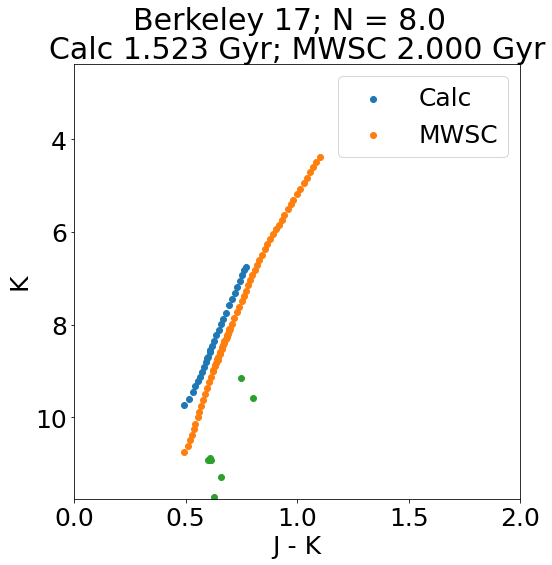

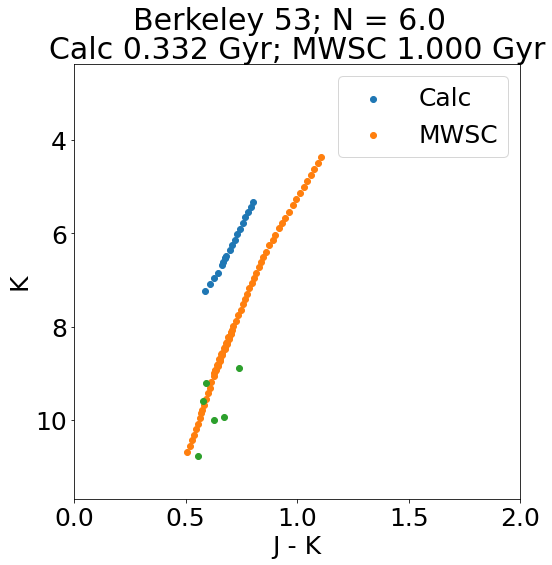

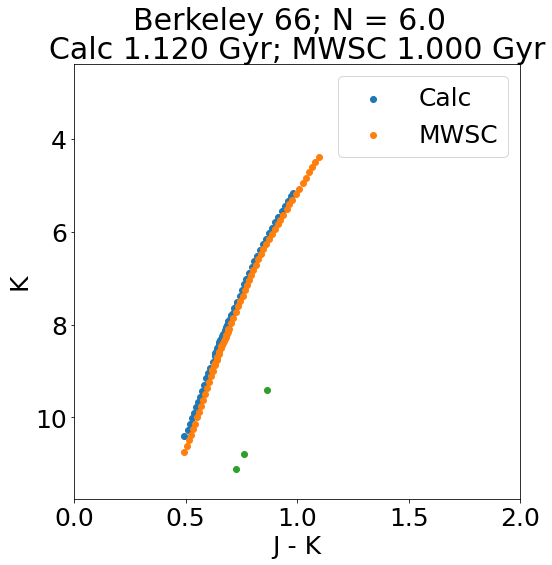

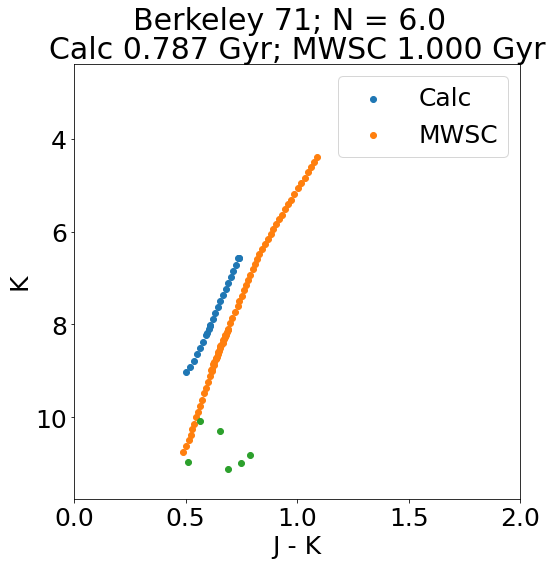

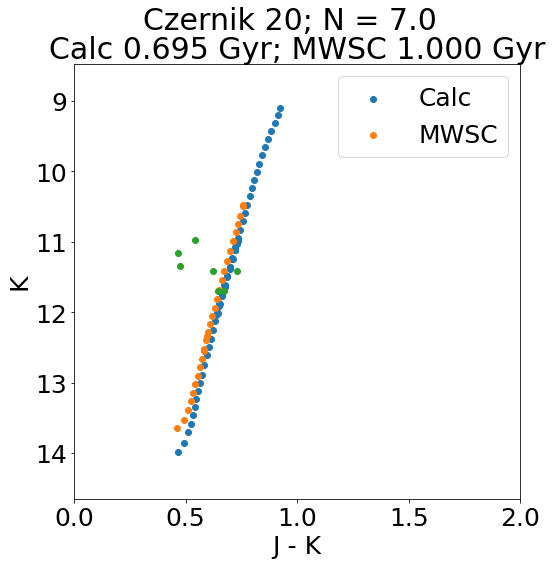

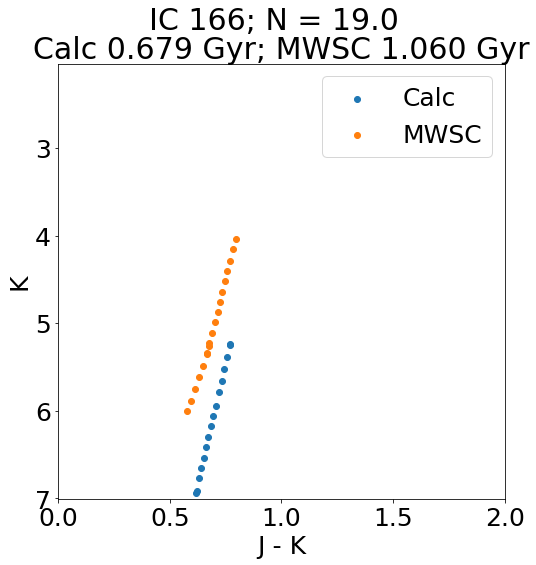

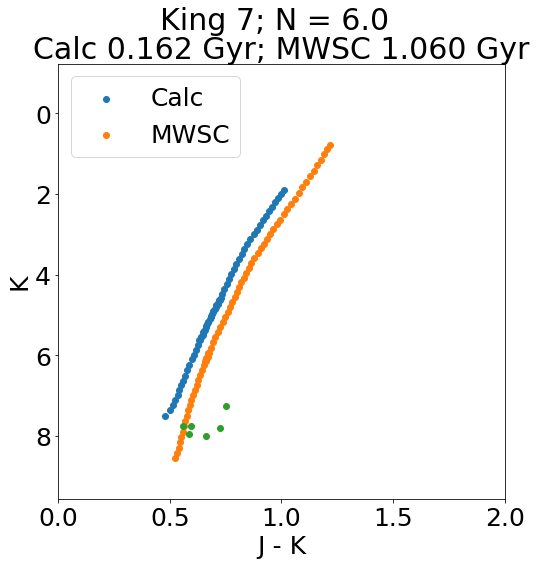

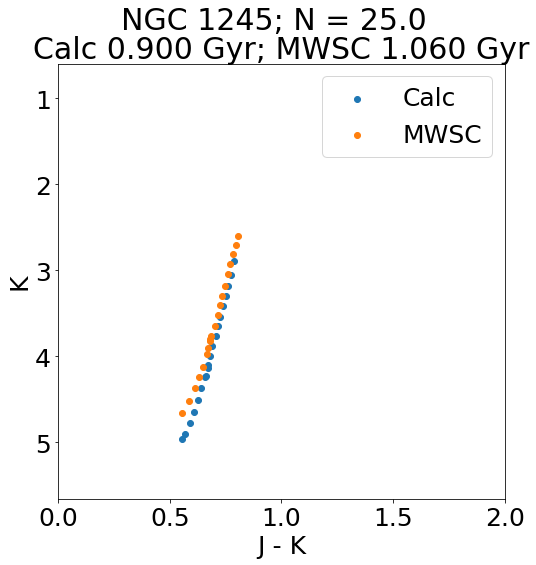

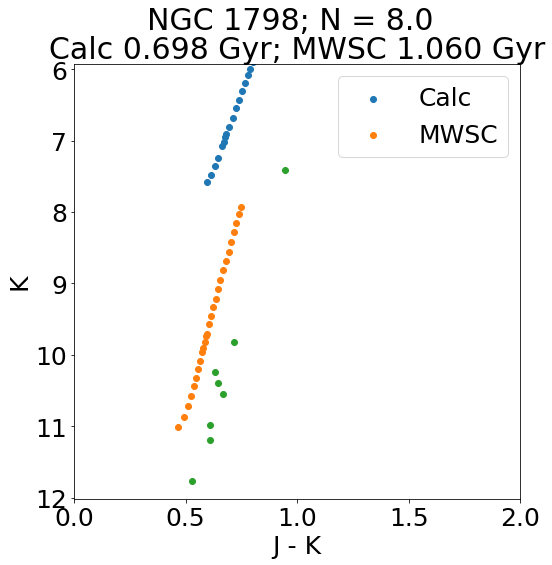

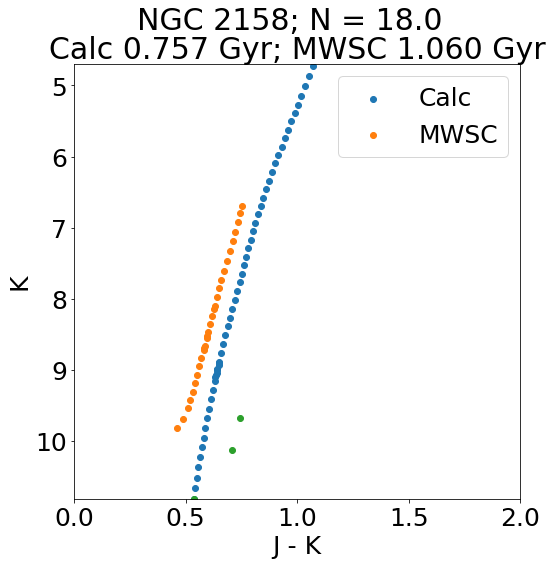

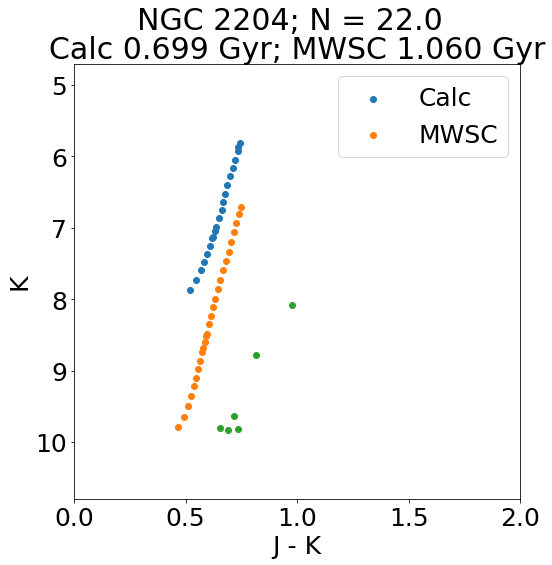

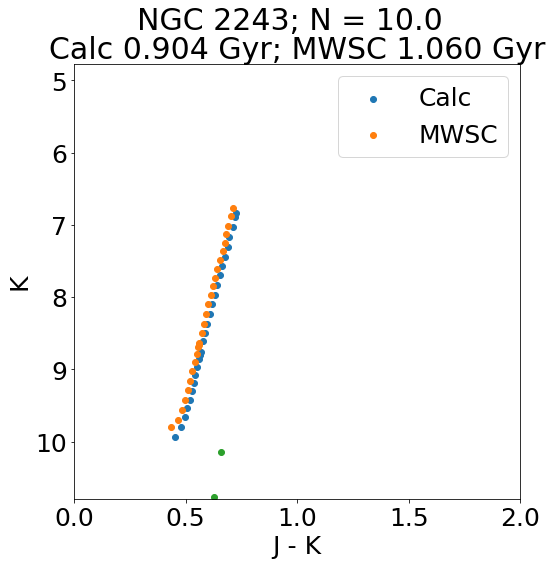

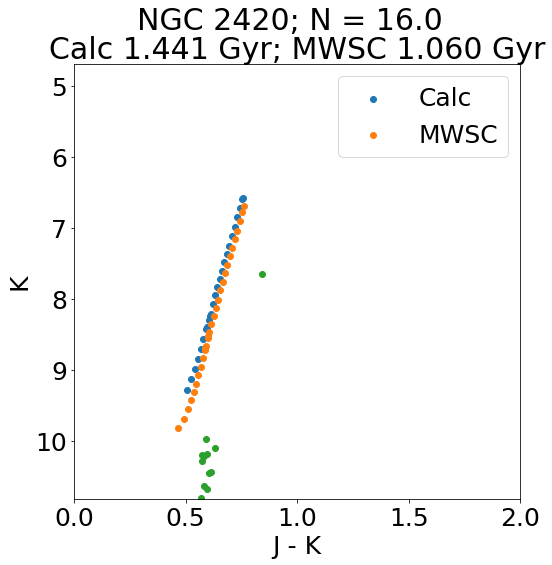

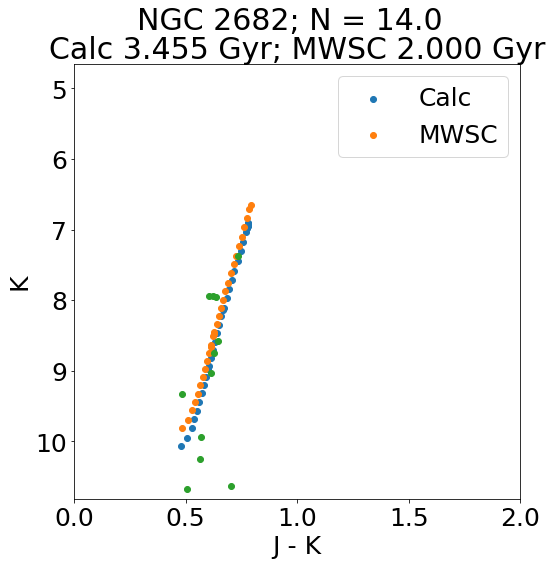

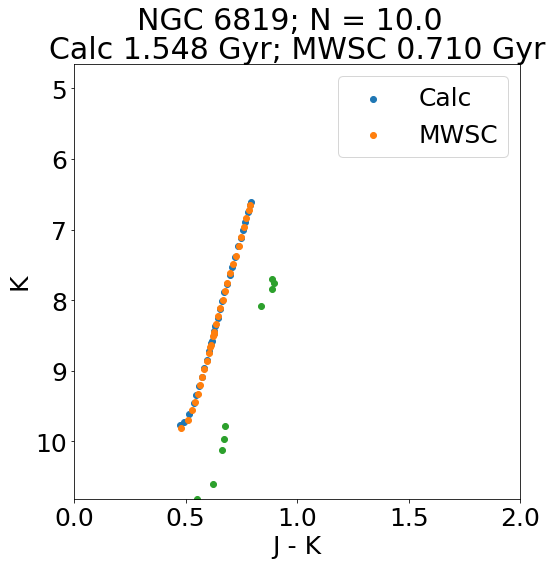

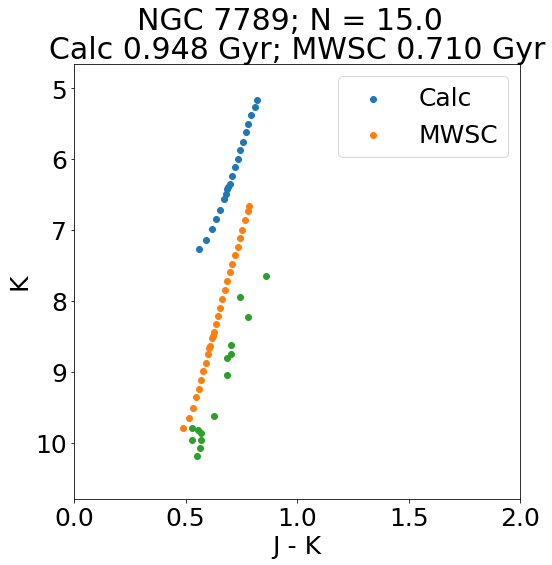

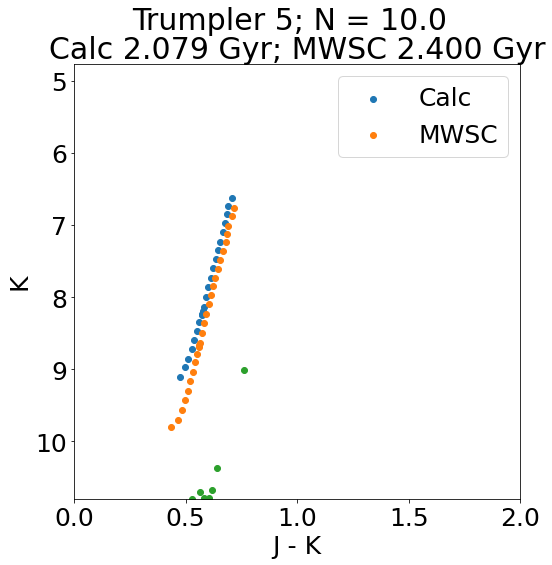

In [130]:
for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i])
    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(calc_age[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(salfeh[clus]))))]
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(litages[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(occamdr17['FE_H'][clus]))))]
    
    plt.figure(figsize=[8,8])
    plt.scatter(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+litdist[i],label='Calc')
    plt.scatter(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+litdist[i],label='MWSC')
    plt.legend()
    plt.scatter((occamdr17['J']-occamdr17['K']-ejk_ak*agetab['AK'])[clus],(occamdr17['K']-agetab['AK'])[clus])
    plt.xlim(0,2)
    plt.ylim(min(iso_mwsc['Ksmag']+litdist[i])-2,1+max(iso_mwsc['Ksmag']+litdist[i]))
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i],
                              calc_n[np.where(calc_n>5)][i]))
    plt.title(r'Calc {:.3f} Gyr; MWSC {:.3f} Gyr'.format(calc_age[np.where(calc_n>5)][i],
                                                         litages[np.where(calc_n>5)][i]))
    plt.xlabel('J - K')
    plt.ylabel('K')
    plt.savefig('../plots/occam_2mass_{}_litdist.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()

# Recalculate Ages with Literature Distances

In [131]:
from tqdm import tqdm_notebook

occamlit_ak = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occamlit_ak_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occamlit_age = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occamlit_age_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occamlit_mass = 999999.0*np.ones(len(np.squeeze(occamdr17)))
occamlit_mass_err = 999999.0*np.ones(len(np.squeeze(occamdr17)))

apoafe = occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H']
apoafe_err = np.sqrt(occamdr17['ALPHA_M']**2+occamdr17['M_H']**2-occamdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(occamdr17)))):
    te = np.array([occamdr17['TEFF'][i],occamdr17['TEFF_ERR'][i]])
    ab = np.array([[occamdr17['M_H'][i],occamdr17['ALPHA_M'][i]],
                   [apoafe[i],apoafe[i]]]).T
    op = np.array([[occamdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    occamdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    occamdr17['J'][i],occamdr17['H'][i],
                    occamdr17['K'][i]],
                   [bperr[i],rperr[i],occamdr17['J_ERR'][i],
                    occamdr17['H_ERR'][i],occamdr17['K_ERR'][i]]]).T
    di = (litdist[i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    ak_val = CalcAge.get_ak(age = 12.0)
    occamlit_ak[i] = ak_val[0] #CalcAge.get_ak(age = 6.0)[0]
    occamlit_ak_err[i] = ak_val[1] #CalcAge.get_ak(age = 6.0)[1]
    
    age_val = CalcAge.get_age()
    occamlit_age[i] = age_val[0] #CalcAge.get_age()[0]
    occamlit_age_err[i] = age_val[1] #CalcAge.get_age()[1]
    
    mass_val = CalcAge.get_mass()
    occamlit_mass[i] = mass_val[0]
    occamlit_mass_err[i] = mass_val[1]

<ipython-input-131-e01606b8b62f>:11: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(occamdr17['ALPHA_M']**2+occamdr17['M_H']**2-occamdr17['FE_H']**2)
<ipython-input-131-e01606b8b62f>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(occamdr17)))):


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


In [132]:
### save ages to fits file
from astropy.table import Table, Column

cnamelit = Column(occamdr17['APOGEE_ID'], name='NAME')
cagelit = Column(occamlit_age,name='AGE')
cage_errlit = Column(occamlit_age_err,name='AGE_ERR')
caklit = Column(occamlit_ak,name='AK')
cak_errlit = Column(occamlit_ak_err,name='AK_ERR')
cmasslit = Column(occamlit_mass,name='MASS')
cmass_errlit = Column(occamlit_mass_err,name='MASS_ERR')

agetable = Table([cnamelit,cagelit,cage_errlit,caklit,cak_errlit,cmasslit,cmass_errlit])
agetable.write('aetas_occamlit_results.fits', format='fits', overwrite=True)

In [133]:
agetablit = fits.getdata('aetas_occamlit_results.fits')

In [134]:
calclit_age = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calclit_age_spread = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
# calclit_feh = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
# calclit_salfeh = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
# calclit_alp = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calclit_ak = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
# calclit_n = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))
calclit_dist = 999999.0*np.ones(len(np.unique(ocmemdr17['CLUSTER'])))

for i in range(len(np.unique(ocmemdr17['CLUSTER']))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[i])
    
    calclit_age[i] = np.nanmedian(agetablit['AGE'][clus])
    calclit_age_spread[i] = mad(agetablit['AGE'][clus])
    calclit_ak[i] = np.nanmedian(agetablit['AK'][clus])
#     calclit_feh[i] = np.nanmedian(occamdr17['FE_H'][clus])
#     calclit_salfeh[i] = (np.nanmedian(occamdr17['FE_H'][clus])+np.log10(0.655*10**(np.nanmedian((occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H'])[clus])) + 0.345))
#     calclit_alp[i] = np.nanmedian((occamdr17['ALPHA_M']+occamdr17['M_H']-occamdr17['FE_H'])[clus])
#     calclit_n[i] = np.size(np.squeeze(clus))
    calclit_dist[i] = 5*np.log10(np.nanmedian((litdist[clus])*1000))-5.


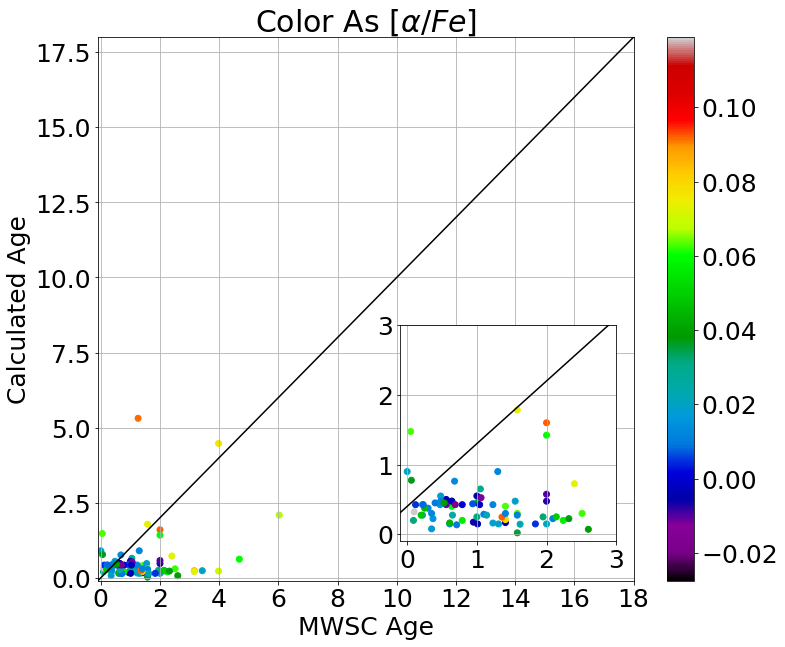

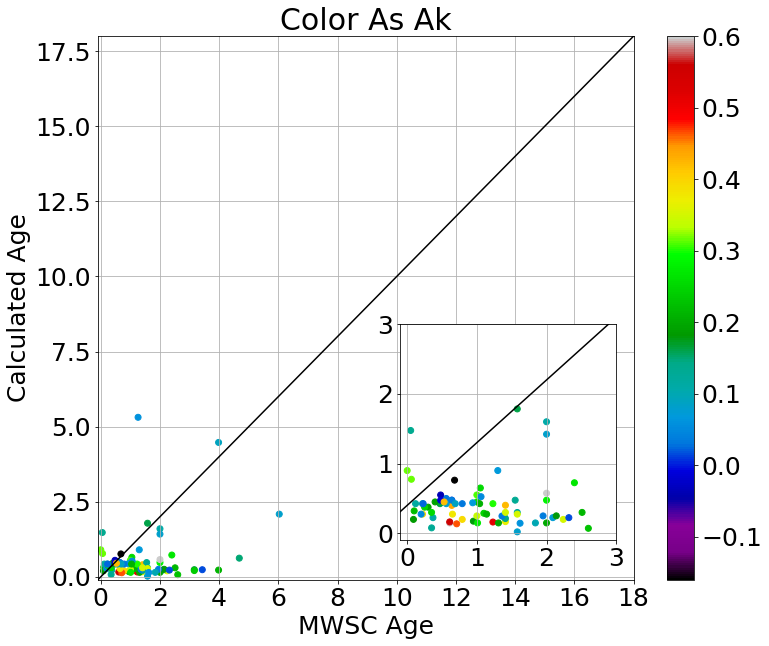

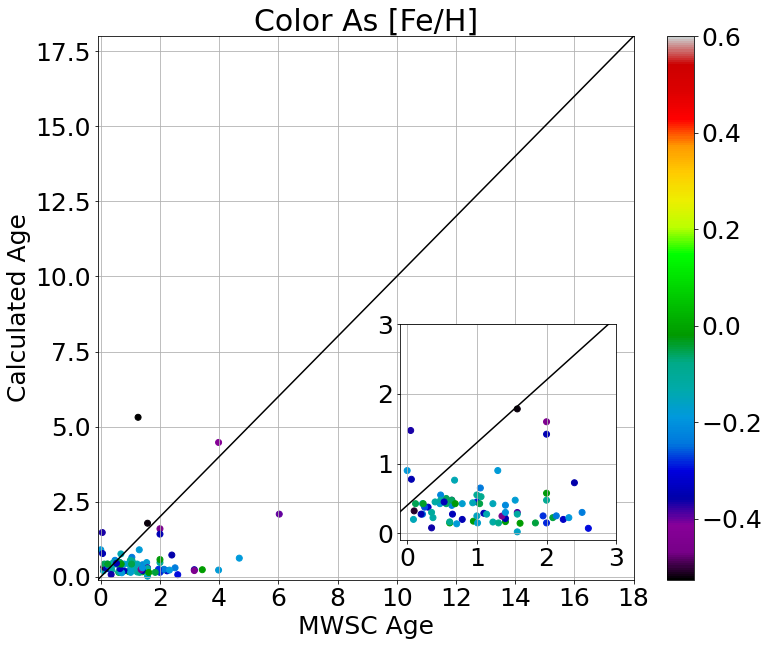

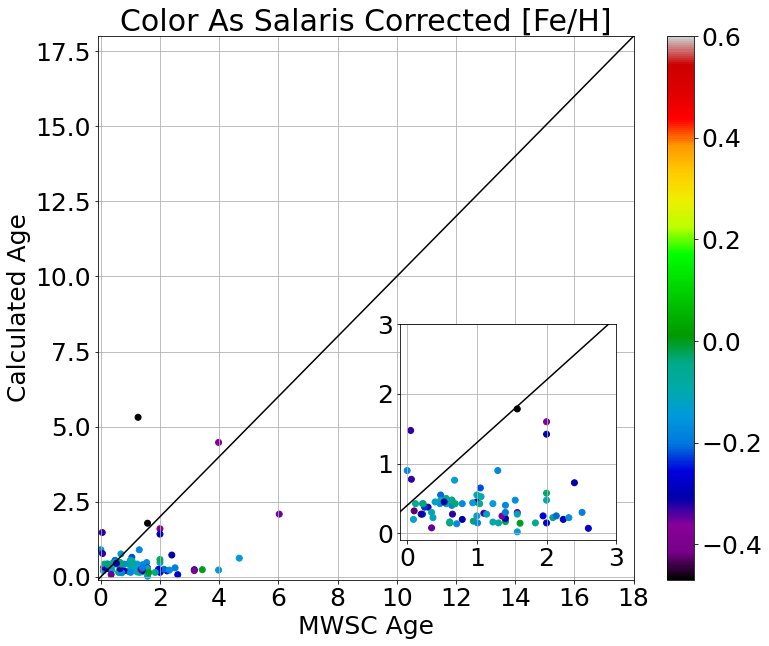

In [137]:
#### Alpha
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_alp,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As [$\alpha/Fe$]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_alp,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/oc_age_age_alpha_litdistcalc.pdf',dpi=300,bbox_inches='tight')
plt.show()

#### AK
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calclit_age,c=calclit_ak,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As Ak')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calclit_age,c=calclit_ak,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
# plt.savefig('../plots/oc_age_age_alpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

#### [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_feh,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As [Fe/H]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_feh,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
plt.savefig('../plots/occam_age_age_feh_litdistcalc.pdf',dpi=300,bbox_inches='tight')
plt.show()

#### Salaris [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_salfeh,vmax=0.6,cmap='nipy_spectral')
plt.colorbar()
plt.plot([-0.5,18],[-0.5,18],c='k')

plt.title(r'Color As Salaris Corrected [Fe/H]')
plt.xlabel(r'MWSC Age')
plt.ylabel(r'Calculated Age')

plt.xlim(-0.1,18.)
plt.ylim(-0.1,18.)
plt.xticks(np.arange(0,20)[::2])
plt.grid()

sub_axes = plt.axes([.45, .18, .3, .3])
sub_axes.set_aspect('equal')
sub_axes.scatter(octab1[tab_ind]['Age'],calclit_age,c=calc_salfeh,vmax=0.6,cmap='nipy_spectral') 
sub_axes.plot([-1.,4.],[-0.5,4.],c='k')
sub_axes.grid()

sub_axes.set_xticks(range(4))
sub_axes.set_xlim(-0.1,3.0)
sub_axes.set_ylim(-0.1,3.0)
# plt.savefig('../plots/oc_age_age_alpha.pdf',dpi=300,bbox_inches='tight')
plt.show()

<ipython-input-136-5cc7f8733dad>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):


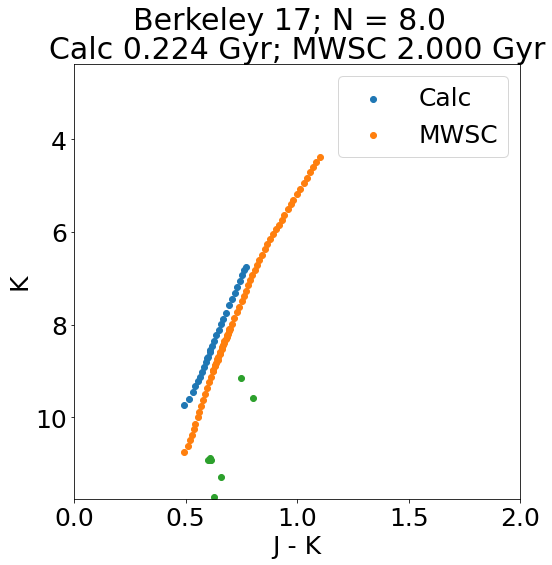

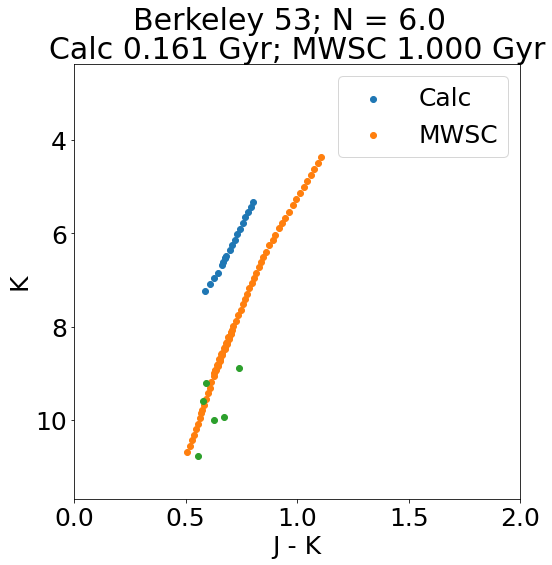

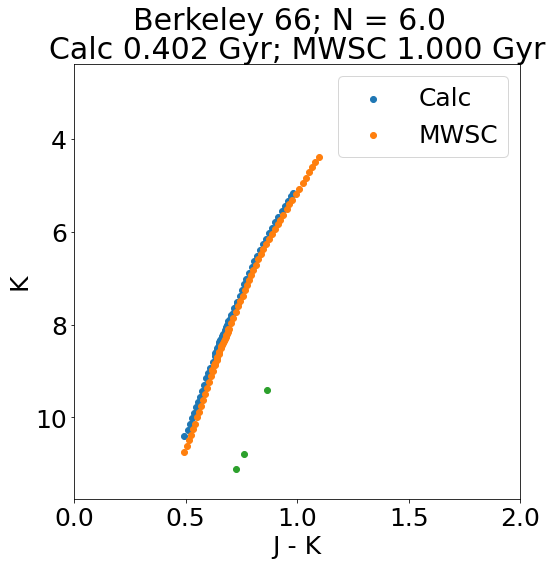

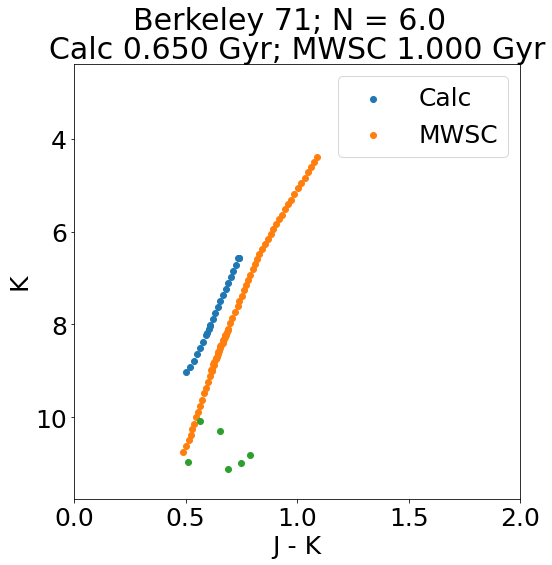

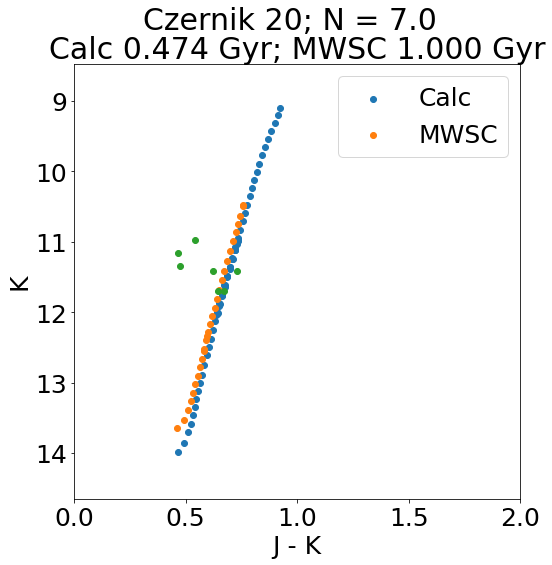

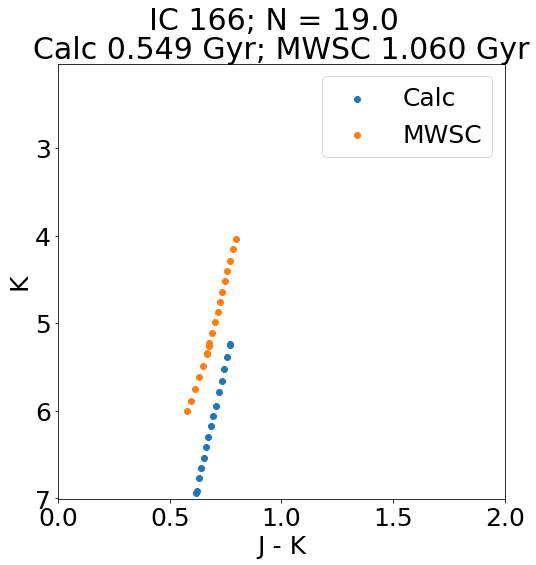

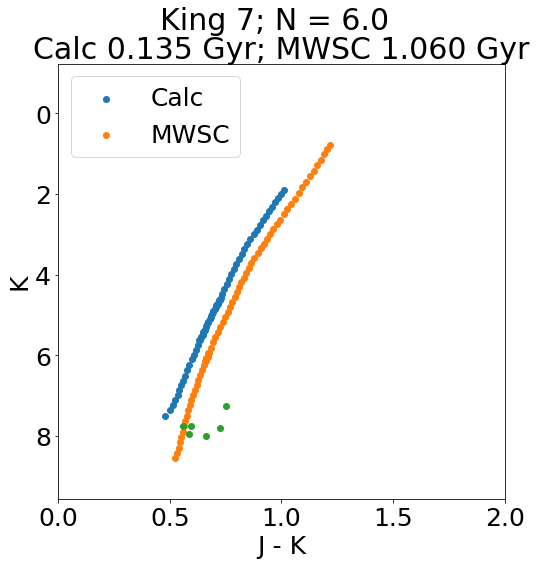

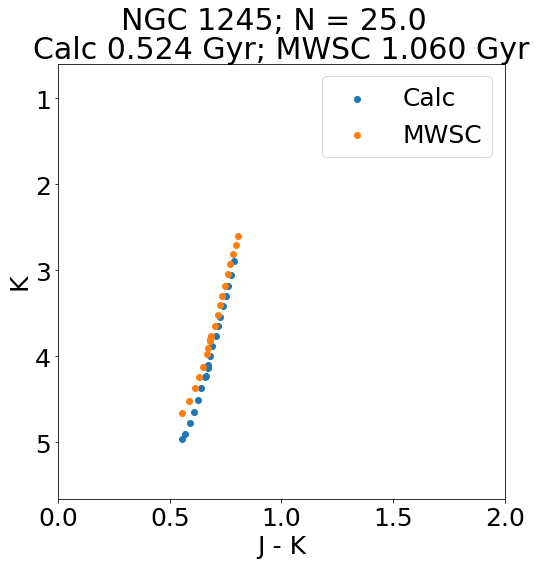

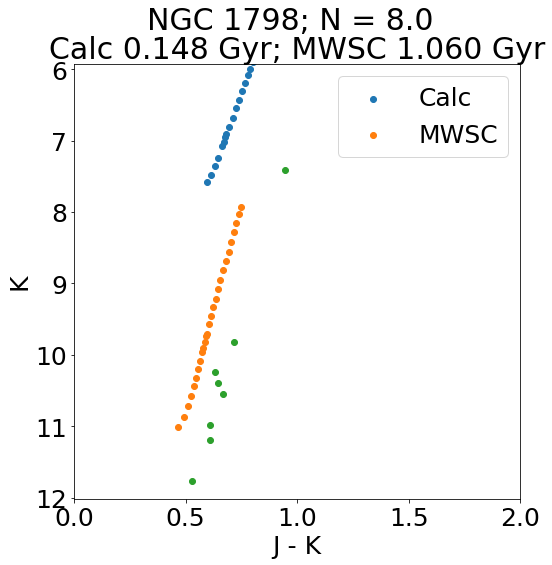

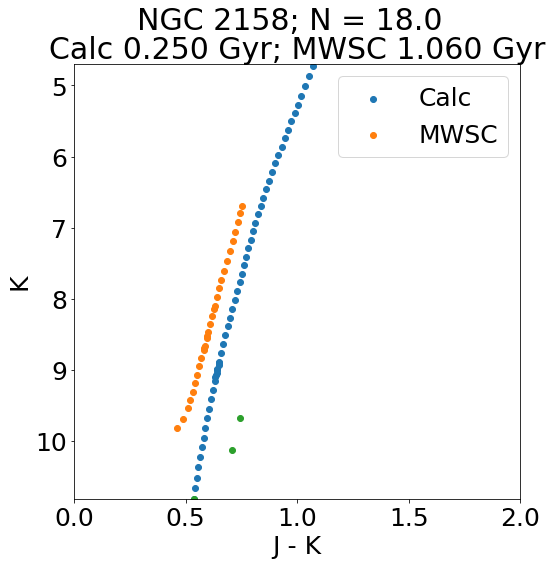

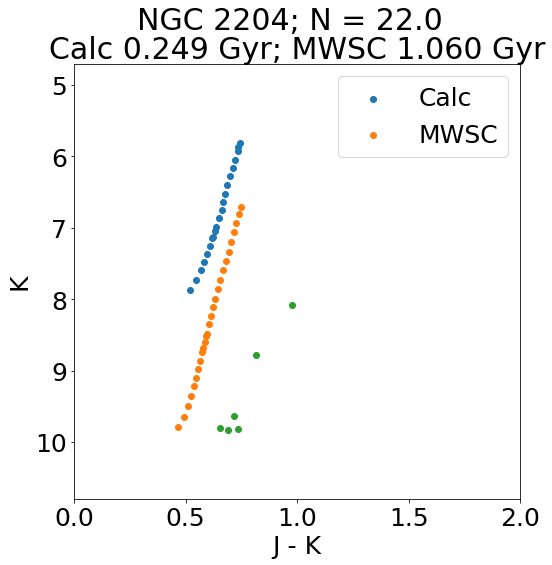

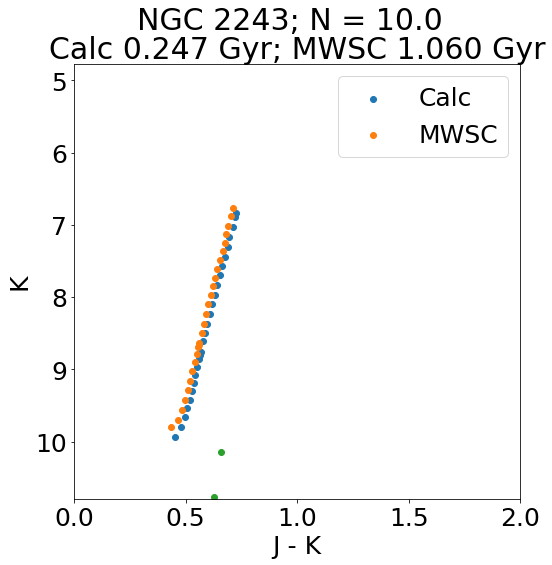

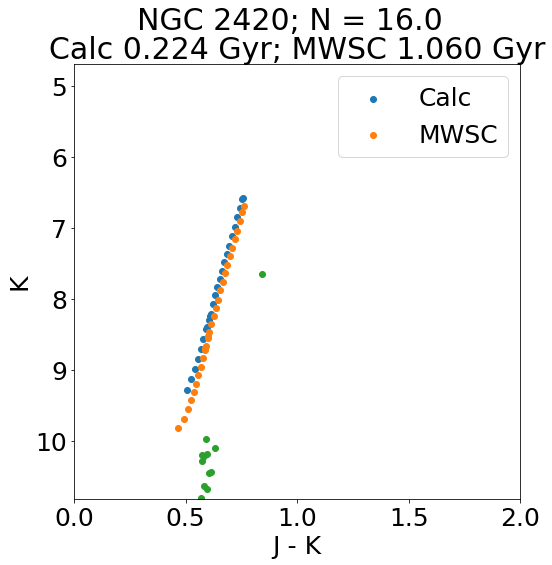

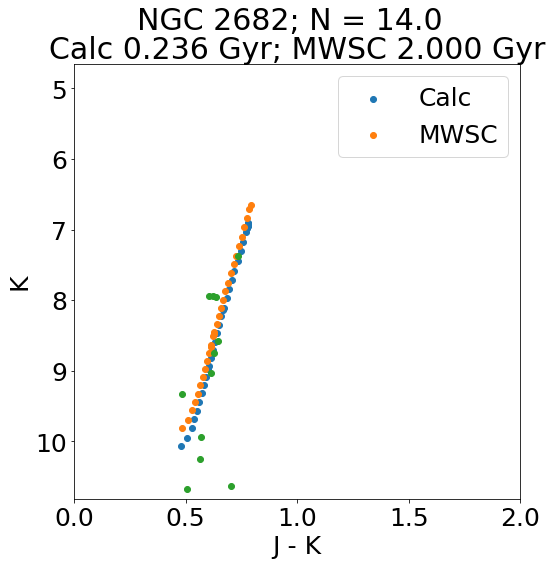

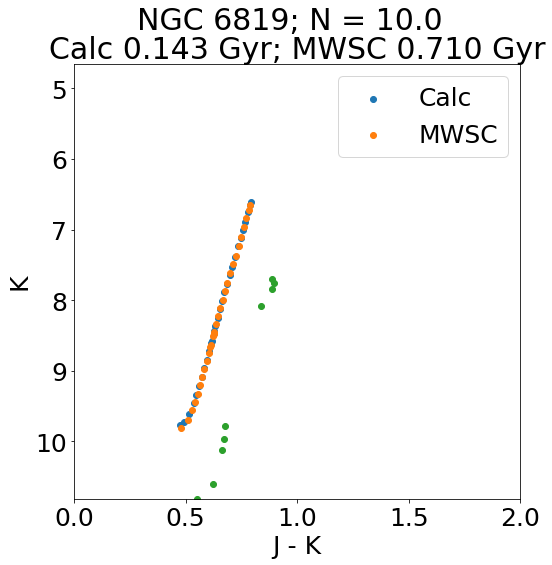

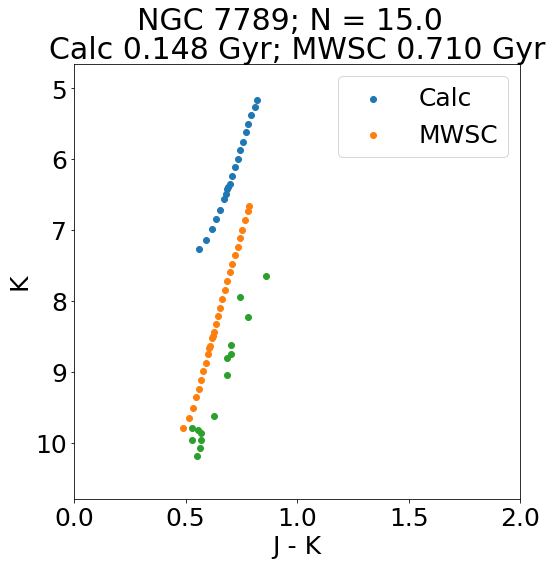

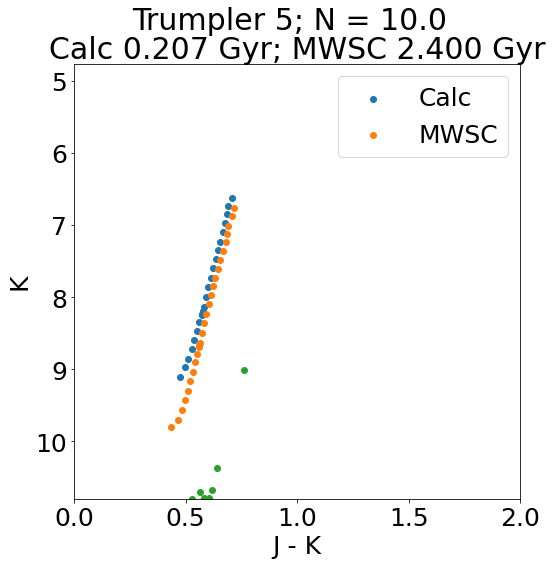

In [136]:
for i in tqdm_notebook(range(len(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)]))):
    clus = np.where(ocmemdr17['CLUSTER']==np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i])
    iso_calc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(calc_age[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(salfeh[clus]))))]
    iso_mwsc = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(litages[i]*10**9)))&
                                (massive['MH']==closest(massive['MH'],np.nanmedian(occamdr17['FE_H'][clus]))))]
    
    plt.figure(figsize=[8,8])
    plt.scatter(iso_calc['Jmag']-iso_calc['Ksmag'],iso_calc['Ksmag']+litdist[i],label='Calc')
    plt.scatter(iso_mwsc['Jmag']-iso_mwsc['Ksmag'],iso_mwsc['Ksmag']+litdist[i],label='MWSC')
    plt.legend()
    plt.scatter((occamdr17['J']-occamdr17['K']-ejk_ak*agetab['AK'])[clus],(occamdr17['K']-agetab['AK'])[clus])
    plt.xlim(0,2)
    plt.ylim(min(iso_mwsc['Ksmag']+litdist[i])-2,1+max(iso_mwsc['Ksmag']+litdist[i]))
    plt.gca().invert_yaxis()
    plt.suptitle(r'{}; N = {}'.format(np.unique(ocmemdr17['CLUSTER'])[np.where(calc_n>5)][i],
                              calc_n[np.where(calc_n>5)][i]))
    plt.title(r'Calc {:.3f} Gyr; MWSC {:.3f} Gyr'.format(calclit_age[np.where(calc_n>5)][i],
                                                         litages[np.where(calc_n>5)][i]))
    
    plt.xlabel('J - K')
    plt.ylabel('K')
    plt.savefig('../plots/occam_2mass_{}_litdistcalc.pdf'.format(oclabs[i]),dpi=300,bbox_inches='tight')
    plt.show()